# Error analysis notebook

## Import packages

In [173]:
import pandas as pd
import math

import seaborn as sns
import matplotlib.pyplot as plt

from elasticsearch import Elasticsearch

import warnings
import matplotlib
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
warnings.filterwarnings("ignore")


## Set filepaths

In [2]:
ranking = '../evaluation/resources/2020/jsonruns/p_controller_default_nle_meta_9_1_theta=0.9.json'
eval_result = '../evaluation/resources/2020/eval_results/p_controller_default_nle_meta_9_1_theta=0.9.tsv'
gt = '../pre_processing/resources/evaluation/2020/TREC-Fair-Ranking-eval-sample.json'

## Prepare dataframes

In [3]:
# ranking df
rdf = pd.read_json(ranking, lines=True)

# ground truth df
gtdf = pd.read_json(gt, lines=True).explode('documents')
gtdf['doc_id'] = gtdf.documents.apply(lambda row: row.get('doc_id'))
gtdf['doc_rel'] = gtdf.documents.apply(lambda row: row.get('relevance'))

# paired down relevances df
reldf = gtdf[['qid','query','doc_id','doc_rel']]

# eval result df
edf = pd.read_csv(eval_result, sep='\t', names=['key', 'qid', 'value'])
edf = edf.pivot(index='qid', columns='key', values='value')

In [4]:
rdf.head(2)

q_num   qid                                            ranking
0    0.0  9087  [c68374b97eb2c214afd3c282175f664fc37c5682, 008...
1    0.1  9087  [cbc33164f9db97698901f130f399f2898d856267, 008...

In [5]:
gtdf.head(2)

qid             query  frequency  \
0  9087  lepidium sativum   0.000013   
0  9087  lepidium sativum   0.000013   

                                           documents  \
0  {'doc_id': '40d8bea494d4ff4c46f7ad5cb2dcdaa6f9...   
0  {'doc_id': '008a2a2c765485af2e035a2572ba9fc110...   

                                     doc_id  doc_rel  
0  40d8bea494d4ff4c46f7ad5cb2dcdaa6f96ed5a4        1  
0  008a2a2c765485af2e035a2572ba9fc1102eabff        1

In [6]:
reldf.head(2)

qid             query                                    doc_id  doc_rel
0  9087  lepidium sativum  40d8bea494d4ff4c46f7ad5cb2dcdaa6f96ed5a4        1
0  9087  lepidium sativum  008a2a2c765485af2e035a2572ba9fc1102eabff        1

In [7]:
edf.head(2)

key  difference  disparity  relevance
qid                                  
95     0.351999   2.936763   1.949844
612    0.991691   1.731472   1.256254

## Select queries/rankings to inspect

[1] select the queries/rankings to inspect based on the MAP value of the rankings. One of the criteria is to select queries whose ranking's MAP is lower than the average for all queries/systems. The metric for our system is Difference in Group Expected Exposure (DGEE).

The mean DGEE across all rankings returned by the P-controller system is 0.428894655. There are 62 queries with a DGEE higher than this mean value, and 138 queries with a DGEE that is lower than the mean. We inspect both top and bottom queries to discover why the ranker performs well on some queries and poorly on others.

In [8]:
edf.difference.mean()

0.428894655

There are 62 items with a difference higher than the total mean, and 138 items with a difference lower than the total mean.

In [9]:
print(edf[edf.difference > edf.difference.mean()].describe())
print()
print(edf[edf.difference <= edf.difference.mean()].describe())

key    difference  disparity  relevance
count   62.000000  62.000000  62.000000
mean     0.960277   1.759598   0.988859
std      0.647813   0.420930   0.328687
min      0.437043   0.998512   0.255715
25%      0.561969   1.469473   0.740174
50%      0.757819   1.671765   1.037014
75%      1.068128   1.899918   1.255380
max      3.700546   2.879598   1.564463

key    difference   disparity   relevance
count  138.000000  138.000000  138.000000
mean     0.190157    1.964270    1.521551
std      0.094710    0.568135    0.452830
min      0.019822    0.985687    0.696810
25%      0.117196    1.623796    1.193393
50%      0.161651    1.865743    1.385916
75%      0.264914    2.230541    1.860925
max      0.409372    3.813899    2.685266


The worst ten queries are:

In [147]:
edf.sort_values(by='difference',ascending=False).head(10)

key     difference  disparity  relevance
qid                                     
657       3.700546   2.631709   0.255715
100510    3.252370   2.703133   0.514383
16607     3.034450   2.557715   0.550634
89881     1.987253   1.570899   0.577918
12885     1.941179   1.874742   0.848831
18060     1.725684   1.519402   0.684165
59483     1.619563   1.586472   0.469430
52501     1.429890   1.625181   0.943276
89569     1.210698   1.378091   0.572047
2438      1.193136   1.397599   0.397092

The best ten queries are:

In [11]:
edf.sort_values(by='difference',ascending=True).head(10)

key    difference  disparity  relevance
qid                                    
91643    0.019822   1.006921   0.868206
5191     0.044683   1.448939   1.344147
81479    0.046552   2.044160   1.889465
21237    0.053041   1.358547   1.149610
7363     0.053171   1.313280   1.085770
18112    0.057675   1.327767   1.079491
61688    0.061505   1.061153   0.834400
4319     0.063171   1.892463   1.585866
43723    0.065366   1.839158   1.496630
51335    0.071198   1.577270   1.252222

## Extract information for specific query

In [12]:
def extract_results_based_on_qid(qid, ranking_df):
    return ranking_df[ranking_df.qid == qid]

def extract_relevances_based_on_qid(qid, relevance_df):
    return relevance_df[relevance_df.qid == qid]

In [13]:
extract_results_based_on_qid(657, rdf).head(5)

q_num  qid                                            ranking
24150  161.0  657  [1436449e0234166b13135df45be1f072df059007, 863...
24151  161.1  657  [18f883bd5b9ab9771e561a0214af6bd5ddda0d61, 863...
24152  161.2  657  [e9cfbf58d87e9f5afae813e8b8294b7719c176da, b79...
24153  161.3  657  [128611b63b268a1bffb69d3276a11ae7f6b068d7, 3c9...
24154  161.4  657  [e686c4e74d9085c78813355d582102d973b157cf, b79...

In [14]:
extract_relevances_based_on_qid(657, reldf).head(5)

qid query                                    doc_id  doc_rel
161  657  iran  a1b0feb1f82716b0e343453ca214912cfd3ea0e5        0
161  657  iran  b59004dc46558189fa4d846029ccb1ce3f079484        0
161  657  iran  17475d93c5d0b5b6396aa1d3a3928d6154b65695        0
161  657  iran  1436449e0234166b13135df45be1f072df059007        0
161  657  iran  18f883bd5b9ab9771e561a0214af6bd5ddda0d61        0

## Visualization

We use different visualizations to gain more insight into the way rankings are formed.

- Given a query with N documents to be re-ranked, for each rank in a list of size N we compute the number of times a relevant or non-relevant item appears at this rank. For poorly performing queries, we expect to see more non-relevant items in top positions and fewer relevant items. These plots can show us whether the relevant items occur towards the middle or the back of the rankings instead.
    - We either plot the relevant and non-relevant items per rank in the same plot, or in separate plots. The separate plots are more readable, since the number of relevant and non-relevant documents across 150 rankings are in different orders of magnitude.
    
    
- Given a query with N documents to be re-ranked, for a specific rank in a list of size N we compute how often each of the documents occurs at that rank. We color-code the documents by relevant/non-relevant. In an ideal scenario, we expect all relevant documents to occur roughly equally as often at the top positions, and more often than non-relevant documents at that. For non-relevant documents, we expect the same behavior at bottom positions. Departures from this behavior can show us whether there are documents that are treated differently than they should. Inspecting these documents may teach us more about *why* they show up in a place where they do not belong.


- Complementary to the previous plot, we show the number of times each document occurs in a "top" or in a "bottom" position. Under the expected exposure model [2], an ideal ranking is any ranking where all documents with a higher relevance grade are followed by all documents with a lower relevance grade. For example, if doc1 and doc2 both have relevance 1, then a ranking that starts as [doc1, doc2, ...] is identical in quality to one that starts with [doc2, doc1, ...]. A "top" position is then any position with rank <= # relevant documents, and a "bottom" position is any position with rank > # relevant documents. 

  In an ideal scenario, we expect each relevant document to occur equally as often in a "top" position, and each non-relevant document to occur equally as often in a "bottom" position. The additional information gained by this plot compared to the previous plot is that we can see whether there are documents that are systematically in a "wrong" (top if they are non-relevant, bottom if they are relevant) position, where the previous plot only shows if they are missing from a *specific* top or bottom rank.

- 


We visualize how often a ranking position is occupied by a relevant versus a non-relevant document, aggregated over all 150 returned rankings for that query.


In [15]:
def count_relgrades(relevance_df):
    rel_counts = relevance_df.doc_rel.value_counts()
    rel_count = rel_counts[1]
    nonrel_count = rel_counts[0]
    return rel_count, nonrel_count

In [16]:
def count_relgrades_qid(qid, relevance):
    subrelevance = extract_relevances_based_on_qid(qid, relevance)
    return count_relgrades(subrelevance)
    

In [17]:
def count_rel_nonrel_per_rank(rankings_df, relevance_df):
    """rankings_df and relevance_df should already be reduced to the information for a single qid"""
    countdict = {k :{'r':0,'nr':0} for k in range(1,len(rankings_df['ranking'].iloc[0]) + 1)}
    for idx, row in rankings_df.iterrows():
        for i, doc in enumerate(row['ranking']):
            rel = relevance_df[relevance_df.doc_id == doc].doc_rel.iloc[0]
            if rel == 0:
                countdict[i+1]['nr'] = countdict[i+1]['nr'] + 1
            elif rel == 1:
                countdict[i+1]['r'] = countdict[i+1]['r'] + 1
            else:
                raise ValueError
    return countdict
            

In [18]:
def rel_nonrel_per_rank_counts_to_sns_df(countdict):
    unpacked = [record for reclist in [[{**{'rank':k},**{'relkind':k2,'count':v2}} for k2,v2 in v.items()] for k,v in countdict.items()] for record in reclist]
    return pd.DataFrame(unpacked)

In [19]:
def count_doc_occurrence_per_rank(rankings_df):
    """Count how often each document occurs at each rank."""
    count_per_doc_per_rank = {i: {} for i in list(range(1,len(rankings_df['ranking'].iloc[0]) + 1))}

    for idx, row in rankings_df.iterrows():
        for j, doc in enumerate(row['ranking']):
            i = j + 1
            if not doc in count_per_doc_per_rank[i]:
                count_per_doc_per_rank[i][doc] = 0
            count_per_doc_per_rank[i][doc] = count_per_doc_per_rank[i][doc] + 1
    return count_per_doc_per_rank

In [20]:
def doc_occurrence_per_rank_to_sns_df(occurrence_dict, relevance_df):
    unpacked = [d for dlist in [[{'rank':k, 'doc_id':k2, 'count':v2} for k2, v2 in v.items()] for k,v in occurrence_dict.items()] for d in dlist]
    unpacked_df = pd.DataFrame(unpacked)

    return pd.merge(unpacked_df,reldf[['doc_id','doc_rel']],on='doc_id',how='left')

In [21]:
def count_pos_of_documents(ranking_df, num_relevant_docs):
    doc_pos_count_dict = {}

    for idx, row in ranking_df.iterrows():
        for i, doc in enumerate(row['ranking']):
            if not doc in doc_pos_count_dict:
                doc_pos_count_dict[doc] = {"top": 0, "bot": 0}
            if i < num_relevant_docs:
                doc_pos_count_dict[doc]["top"] = doc_pos_count_dict[doc]["top"] + 1
            else:
                doc_pos_count_dict[doc]["bot"] = doc_pos_count_dict[doc]["bot"] + 1

    return doc_pos_count_dict        

In [22]:
def document_pos_count_to_sns_df(doc_pos_count_dict, relevance_df):
    unpacked = [d for dlist in [[{'doc_id':k, 'pos':k2, 'count':v2} for k2, v2 in v.items()] for k,v in doc_pos_count_dict.items()] for d in dlist]
    unpacked_df = pd.DataFrame(unpacked)

    return pd.merge(unpacked_df,reldf[['doc_id','doc_rel']],on='doc_id',how='left')

In [71]:
def plot_rel_nonrel_per_rank(data):
    """Plot the number of times a (non)relevant item appeared at a rank."""
    
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.barplot(x="rank", y="count", hue="relkind", data=data)

In [156]:
def plot_rel_nonrel_per_rank_per_relkind(data,regline=False):
    """Plot the number of times a (non)relevant item appeared at a rank, split by rank."""
    
    pi = iter(sns.color_palette())
    f = next(pi)
    s = next(pi)
    next(pi)
    t = next(pi)

    fig, ax = plt.subplots(1,2,figsize = (17.7,8.27))
    ax[0].title.set_text('Relevant item counts')
    ax[1].title.set_text('Nonrelevant item counts')

    sns.barplot(x="rank", y="count", data=data[data.relkind=='r'],ax=ax[0],color=f)
    sns.barplot(x="rank", y="count", data=data[data.relkind=='nr'],ax=ax[1],color=s)

    if regline:
        sns.regplot(x="rank", y="count", data=data[data.relkind=='r'],ax=ax[0], scatter_kws={"s": 0}, color=t)
        sns.regplot(x="rank", y="count", data=data[data.relkind=='nr'],ax=ax[1], scatter_kws={"s": 0},color=t)
    return fig


In [157]:
def plot_rel_nonrel_per_rank_per_relkind_for_qid(qid, ranking, relevance, regline=False):
    subranking = extract_results_based_on_qid(qid, ranking)
    subrelevance = extract_relevances_based_on_qid(qid, relevance)
    
    num_rel_docs, num_nonrel_docs = count_relgrades(subrelevance)
    
    rel_nonrel_counts = count_rel_nonrel_per_rank(subranking, subrelevance)
    rel_nonrel_df = rel_nonrel_per_rank_counts_to_sns_df(rel_nonrel_counts)
    fig = plot_rel_nonrel_per_rank_per_relkind(rel_nonrel_df,regline=regline)
    fig.suptitle(f"(Non-)relevant documents per rank for {qid}")
    

In [162]:
def plot_doc_occurrence_per_rank(data, k=2, rev=False):
    """Show how often each document in :data: appears at each rank <= k."""
    sns.set_palette("tab10")
    pi = iter(sns.color_palette())
    first = next(pi)
    second = next(pi)
    
    data["doc_labels"] = data.doc_id.apply(lambda row: f"{row[:4]}...")
    
#     numrows = math.ceil(num_rel_docs / 2)
    fig, ax = plt.subplots(1, k, figsize = (9*k, 8))
    
    for i in range(0,k):
        rank = i + 1
        if rev:
            rank = len(set(data["rank"].to_list())) - rank
    
        thisaxdata = data[data['rank'] == rank].sort_values(by='count',ascending=False)
        
    
        clrs = [first if rel == 1 else second for rel in thisaxdata.doc_rel.to_list()]
        sns.barplot(x="doc_labels", y="count",palette=clrs, data=thisaxdata,ax=ax[i])
        ax[i].title.set_text(f'Rank {rank}')
        _ = ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation = -70)
        ax[i].legend(labels=["rel","nonrel"], title='relkind')
        leg = ax[i].get_legend()
        leg.legendHandles[0].set_color(first)
        leg.legendHandles[1].set_color(second)
    return fig

In [163]:
def plot_doc_occurrence_per_rank_for_qid(qid, ranking, relevance, k=2, rev=False):
        subranking = extract_results_based_on_qid(qid, ranking)
        subrelevance = extract_relevances_based_on_qid(qid, relevance)
                
        doc_per_rank_counts = count_doc_occurrence_per_rank(subranking)
        rank_occurrence_df = doc_occurrence_per_rank_to_sns_df(doc_per_rank_counts, subrelevance)
    
        fig = plot_doc_occurrence_per_rank(rank_occurrence_df, k, rev)
        fig.suptitle(f"Document counts per rank for {qid}")
    
    

In [182]:
def plot_doc_pos_count(data,numrel,numnrel):
    """Plot how many times each document occurred in the top and bottom positions."""
    sns.set_palette("tab10")
    pi = iter(sns.color_palette())
    first = next(pi)
    second = next(pi)

    data["doc_labels"] = data.doc_id.apply(lambda row: f"{row[:4]}...")


    fig, ax = plt.subplots(1, 2, figsize = (18, 8))
    _ = ax[0].title.set_text(f'Occurrence of doc in top pos (k={numrel})')
    _ = ax[1].title.set_text(f'Occurrence of doc in bottom pos (k={numnrel})')

    for i, pos in enumerate(["top","bot"]):
        _ = ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation = -70)
        thisaxdata = data[data['pos'] == pos].sort_values(by='doc_rel',ascending=False)
        
        clrs = [first if rel == 1 else second for rel in thisaxdata.doc_rel.to_list()]
        sns.barplot(x="doc_labels", y="count",palette=clrs, data=thisaxdata,ax=ax[i])
        ax[i].legend(labels=["rel","nonrel"], title='relkind')
        leg = ax[i].get_legend()
        leg.legendHandles[0].set_color(first)
        leg.legendHandles[1].set_color(second)
    return fig


In [183]:
def plot_doc_pos_count_for_qid(qid, ranking, relevance):
    subranking = extract_results_based_on_qid(qid, ranking)
    subrelevance = extract_relevances_based_on_qid(qid,relevance)
    num_rel_docs, num_nonrel_docs = count_relgrades(subrelevance)
    doc_position_counts = count_pos_of_documents(subranking, rel_count)
    doc_pos_count_df = document_pos_count_to_sns_df(doc_position_counts, subrelevance)
    fig = plot_doc_pos_count(doc_pos_count_df,num_rel_docs,num_nonrel_docs)


    fig.suptitle(f"Document position counts {qid}")

    

In [101]:
def plots_for_qid(qid,ranking,relevance,k=2):
    plot_rel_nonrel_per_rank_per_relkind_for_qid(qid, ranking, relevance, regline=False)
    plot_rel_nonrel_per_rank_per_relkind_for_qid(qid, ranking, relevance, regline=True)

    plot_doc_occurrence_per_rank_for_qid(qid, ranking, relevance,k)
    plot_doc_occurrence_per_rank_for_qid(qid, ranking, relevance,k,rev=True)
    plot_doc_pos_count_for_qid(qid, ranking, relevance)

In [102]:
plotoptions_qid = ["plot_rel_nonrel_per_rank_per_relkind_for_qid","plot_doc_occurrence_per_rank_for_qid","plot_doc_pos_count_for_qid"]

### QID: 657

We inspect the the worst-performing query, query 657.

In [103]:
qid = 657
subrdf = extract_results_based_on_qid(qid, rdf)
subreldf = extract_relevances_based_on_qid(qid,reldf)

In [104]:
rel_counts = subreldf.doc_rel.value_counts()
rel_count = rel_counts[1]
nonrel_count = rel_counts[0]

In [105]:
rel_nonrel_counts = count_rel_nonrel_per_rank(subrdf, subreldf)

In [106]:
rel_nonrel_df = rel_nonrel_per_rank_counts_to_sns_df(rel_nonrel_counts)
rel_nonrel_df.head(4)

rank relkind  count
0     1       r      1
1     1      nr    149
2     2       r      7
3     2      nr    143

We plot the number of relevant/nonrelevant items that appear at each rank. An issue with this approach is that most rankings contain more nonrelevant than relevant items. As a result, there bars for the nonrelevant items are on a different scale than those for the relevant items. This makes the plot harder to read.

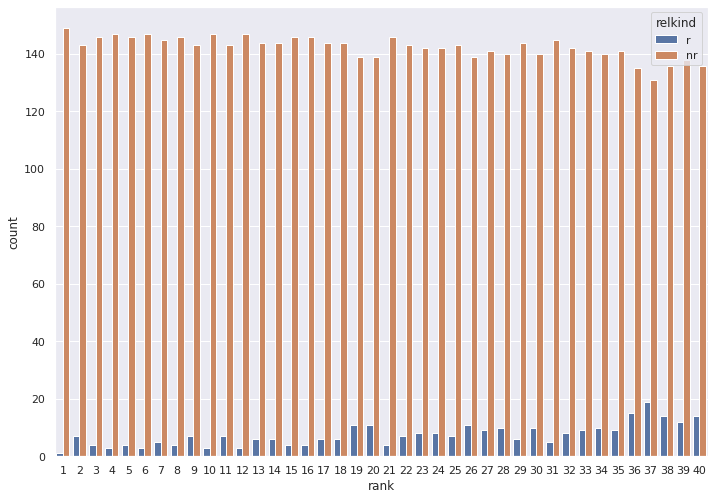

In [107]:
plot_rel_nonrel_per_rank(rel_nonrel_df)

We split the plot into relevant and nonrelevant item counts for readability.

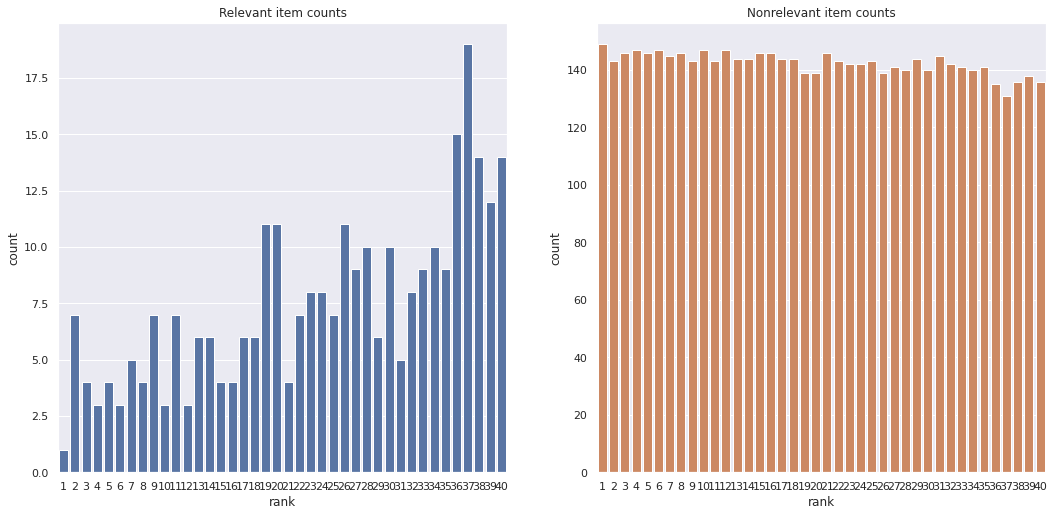

In [108]:
plot_rel_nonrel_per_rank_per_relkind(rel_nonrel_df,regline=False)

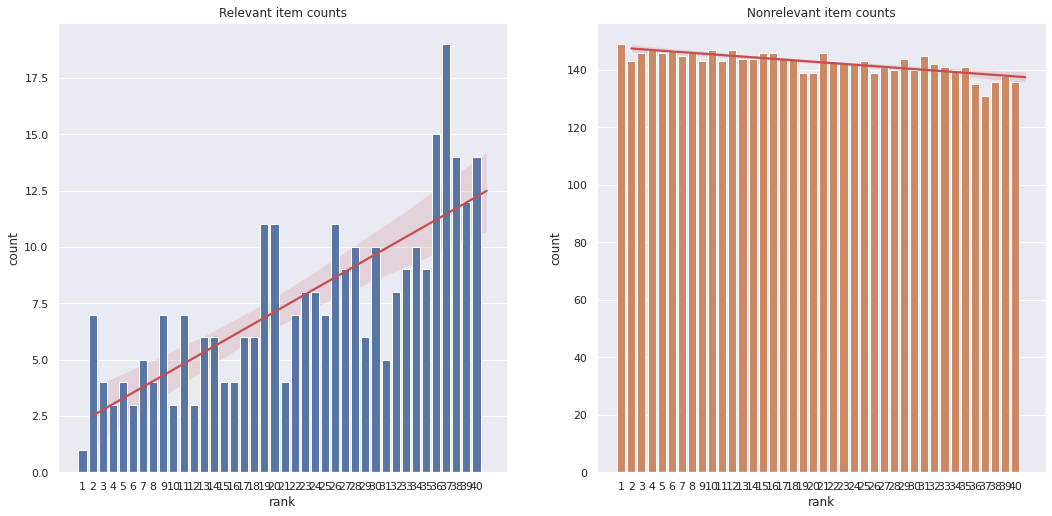

In [109]:
plot_rel_nonrel_per_rank_per_relkind(rel_nonrel_df,regline=True)

We see that the number of relevant items *increases* with increasing rank. This makes sense for a query that performs poorly, but we don't yet know *why* the relevant items are ranked towards the back. After all, if we ranked completely at random we would expect a uniform distribution instead.

In [110]:
doc_per_rank_counts = count_doc_occurrence_per_rank(subrdf)

In [111]:
rank_occurrence_df = doc_occurrence_per_rank_to_sns_df(doc_per_rank_counts,subreldf)
rank_occurrence_df.head(4)

rank                                    doc_id  count  doc_rel
0     1  1436449e0234166b13135df45be1f072df059007      7        0
1     1  18f883bd5b9ab9771e561a0214af6bd5ddda0d61      6        0
2     1  e9cfbf58d87e9f5afae813e8b8294b7719c176da      6        0
3     1  128611b63b268a1bffb69d3276a11ae7f6b068d7      5        0

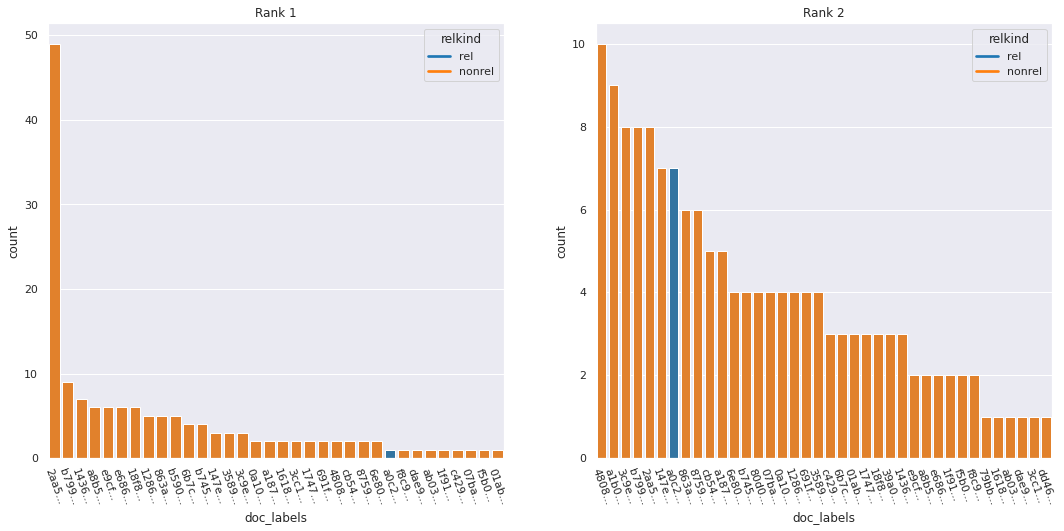

In [187]:
_ = plot_doc_occurrence_per_rank(rank_occurrence_df,2)

In the figures above we see how many times each document was put in the first or second ranking position, aggregated across 150 rankings. The blue line indicates which document is relevant; only one relevant document is put in either the first or second rank, and only one time in the first and 5 times in the second ranking.

We also want to know how often each file was in a top position and how often it was in a bottom position. In the ideal case, we expect each relevant file to be equally often in the top positions and each irrelevant file to be equally often in the bottom positions.

In [114]:
doc_position_counts = count_pos_of_documents(subrdf, rel_count)

In [125]:
doc_pos_count_df = document_pos_count_to_sns_df(doc_position_counts, subreldf)
doc_pos_count_df.head(5)

doc_id  pos  count  doc_rel
0  1436449e0234166b13135df45be1f072df059007  top     10        0
1  1436449e0234166b13135df45be1f072df059007  bot    140        0
2  863a0360e4345b2e106e4f44cd95821f68b28036  top     11        0
3  863a0360e4345b2e106e4f44cd95821f68b28036  bot    139        0
4  e9cfbf58d87e9f5afae813e8b8294b7719c176da  top      8        0

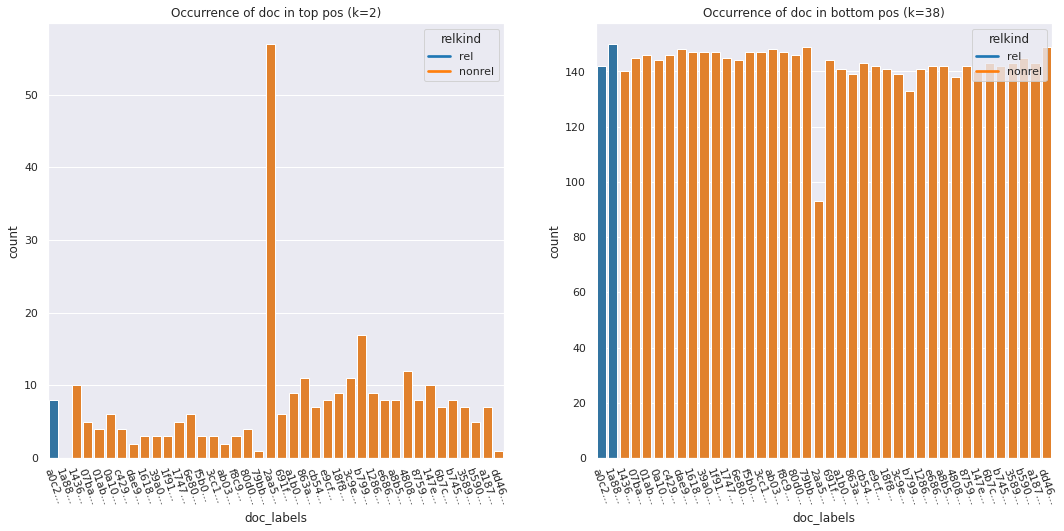

In [186]:
_ = plot_doc_pos_count(doc_pos_count_df,2,38)


We see that only one of the relevant files occurs in the top positions, and that one of the non-relevant files appears markedly less often in a bottom positions.

### Multiple queries
Let's compare multiple queries and see if we can determine a pattern.

We see that poor performance does not necessarily mean that relevant documents are clustered towards the bottom rankings. For queries 100510, 16607, and 89881 the distribution of relevant items more closely resembles a normal distribution.

In [159]:
for q in topqueries.index.unique():
    print(q)

91643
5191
81479
21237
7363
18112
61688
4319
43723
51335


In [149]:
topqueries = edf.sort_values(by='difference',ascending=True).head(10)
bottomqueries = edf.sort_values(by='difference',ascending=False).head(10)

#### (Non-)relevant documents at each rank
For the top and bottom k=10 queries, we plot the number of (non-)relevant items at each rank.

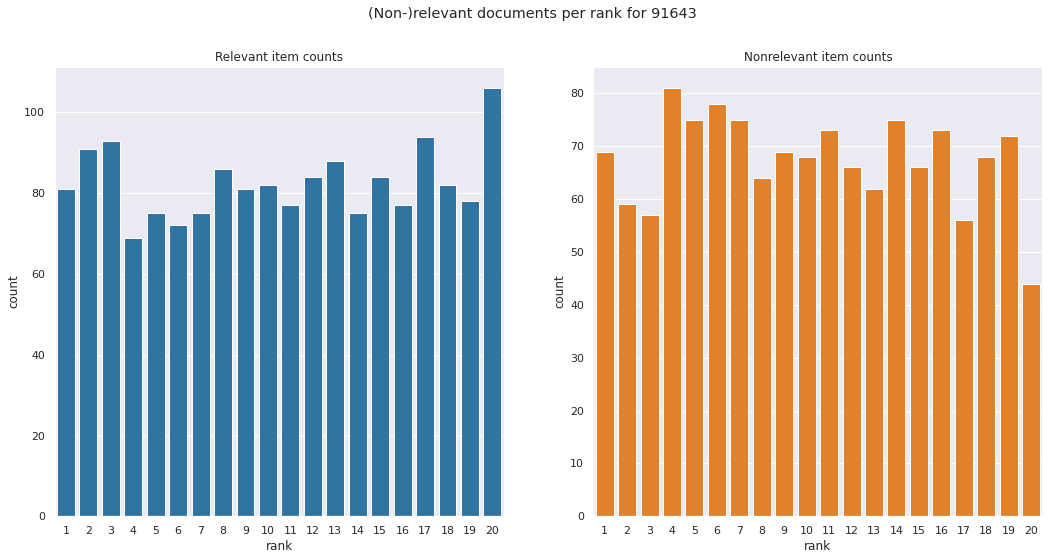

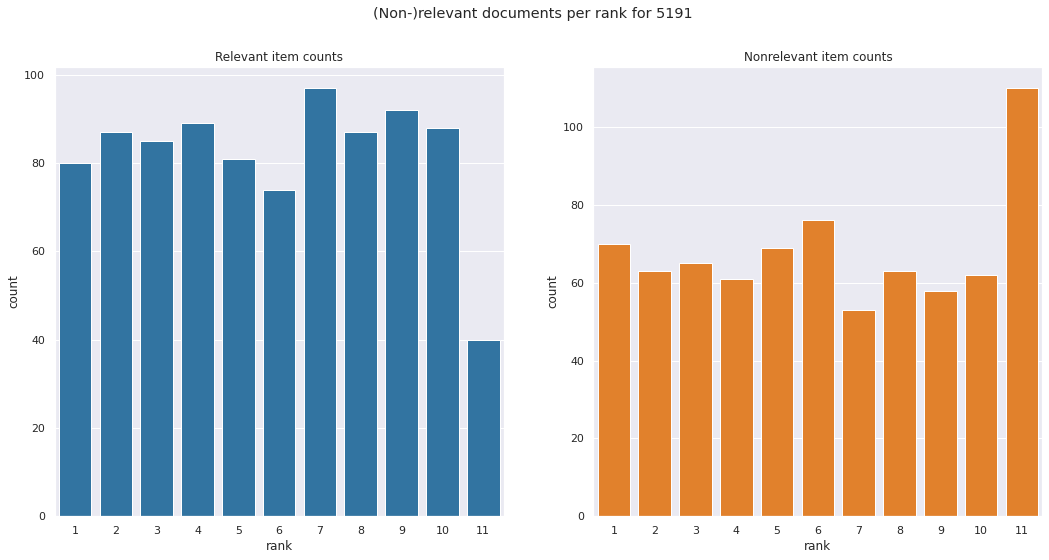

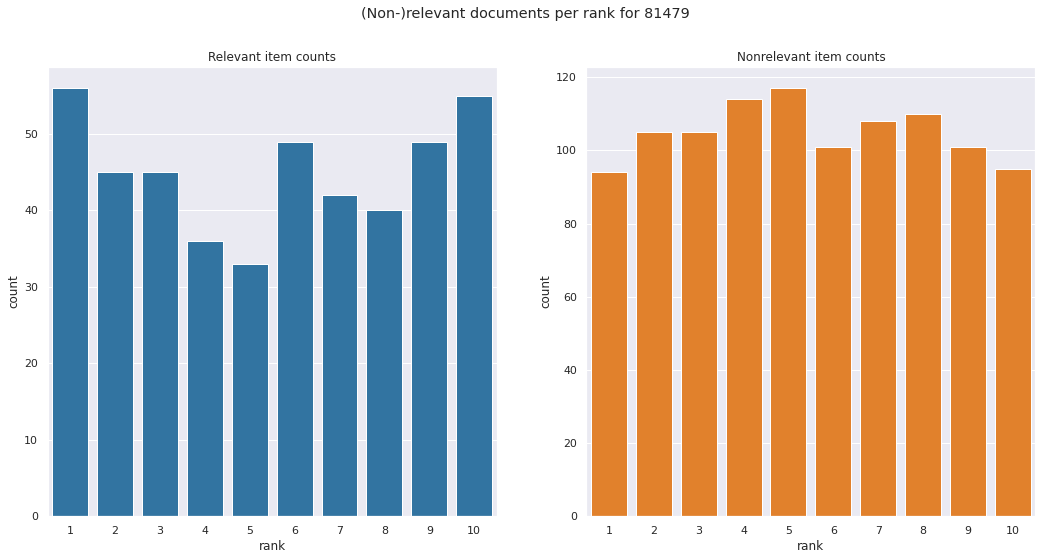

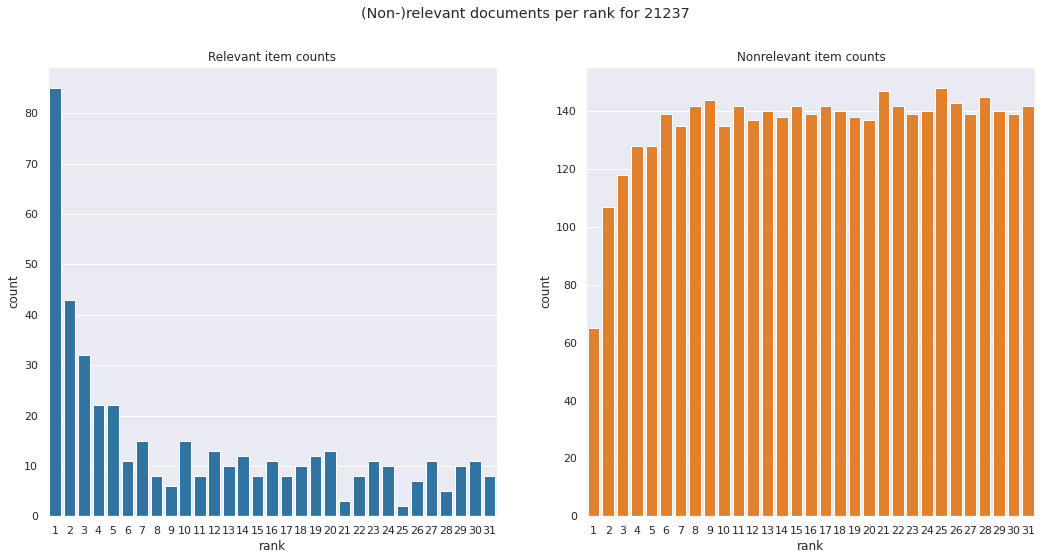

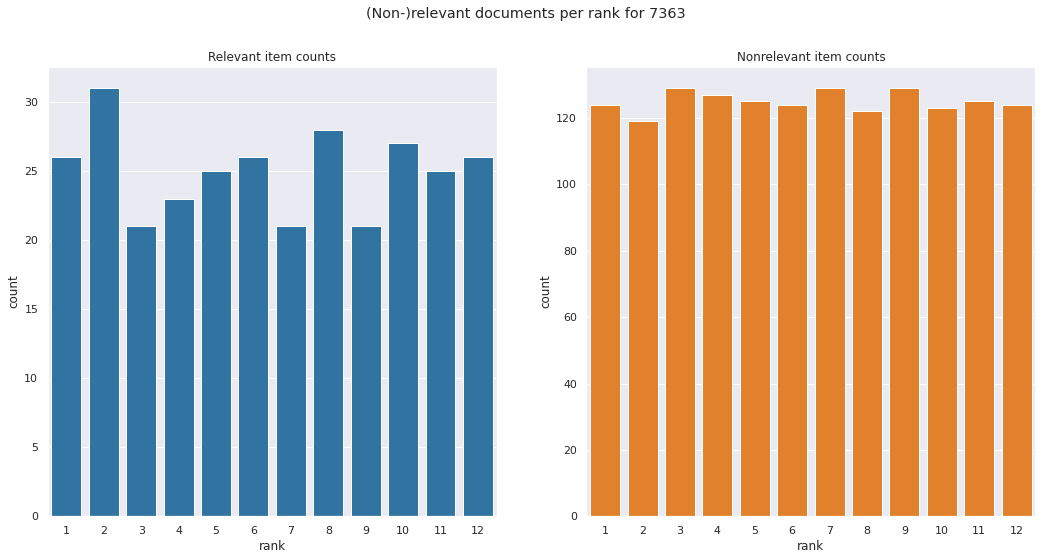

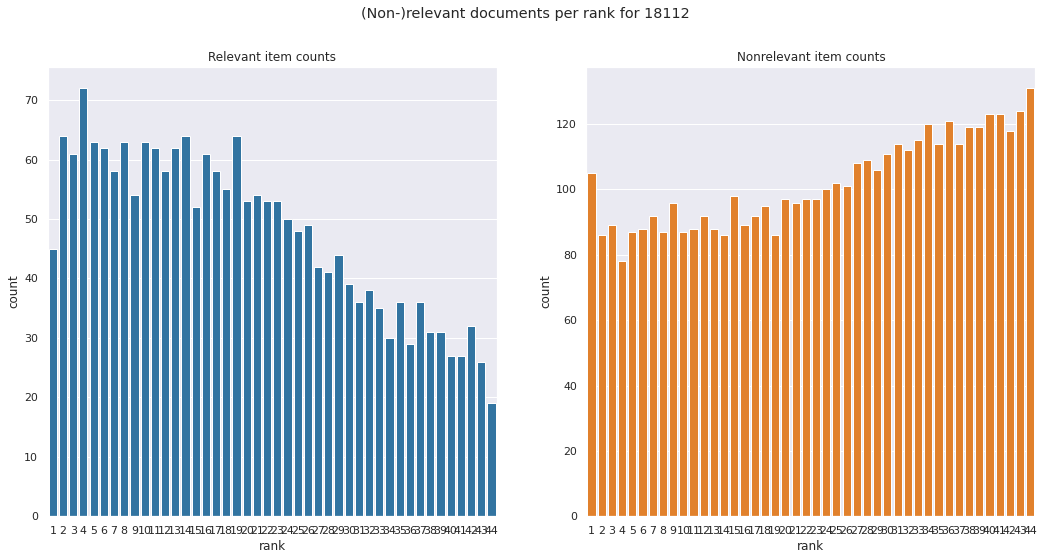

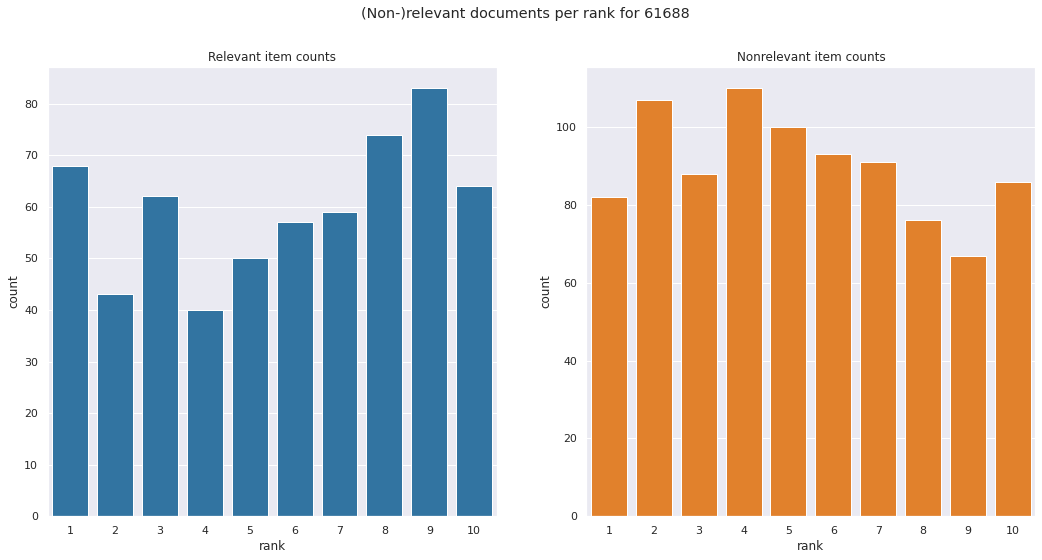

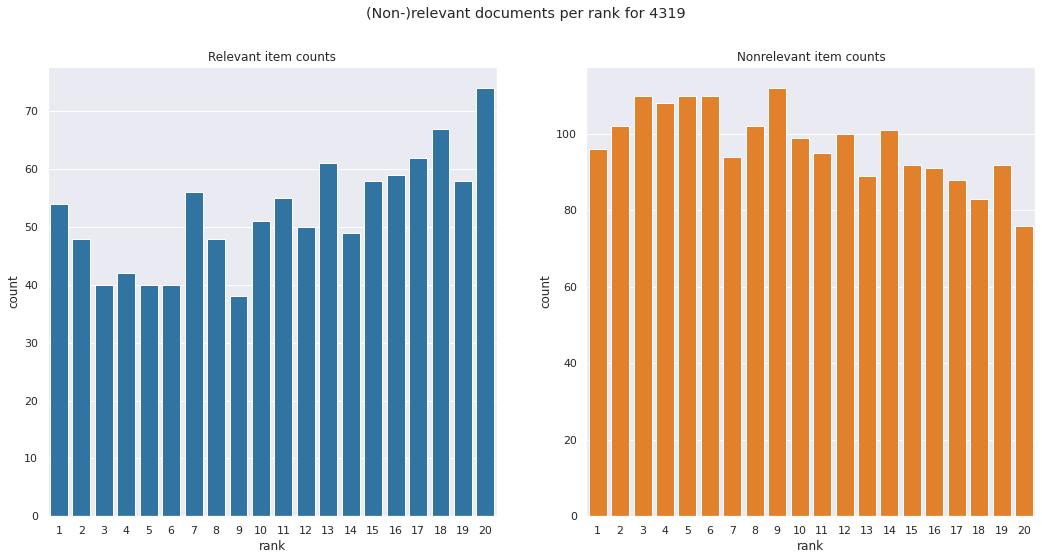

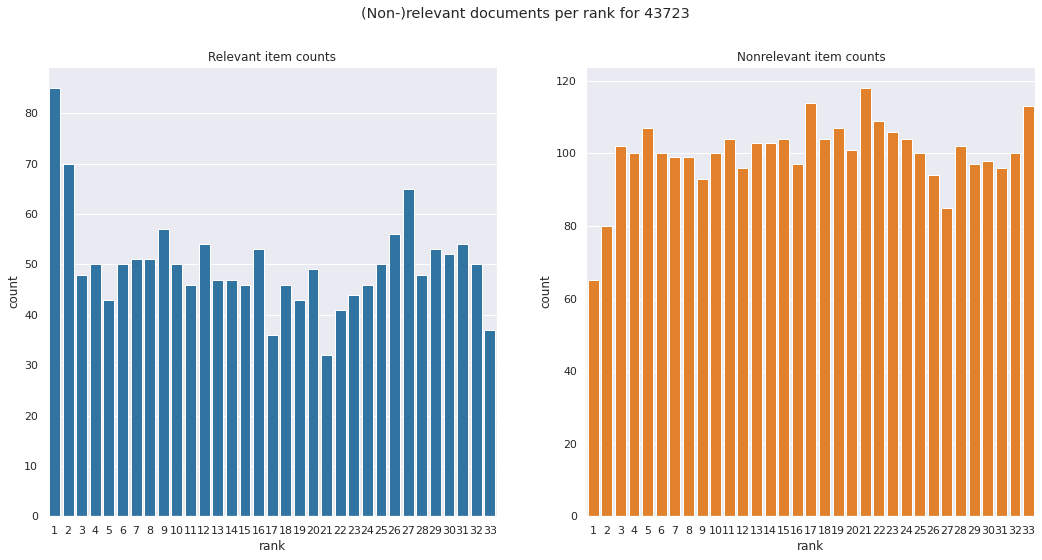

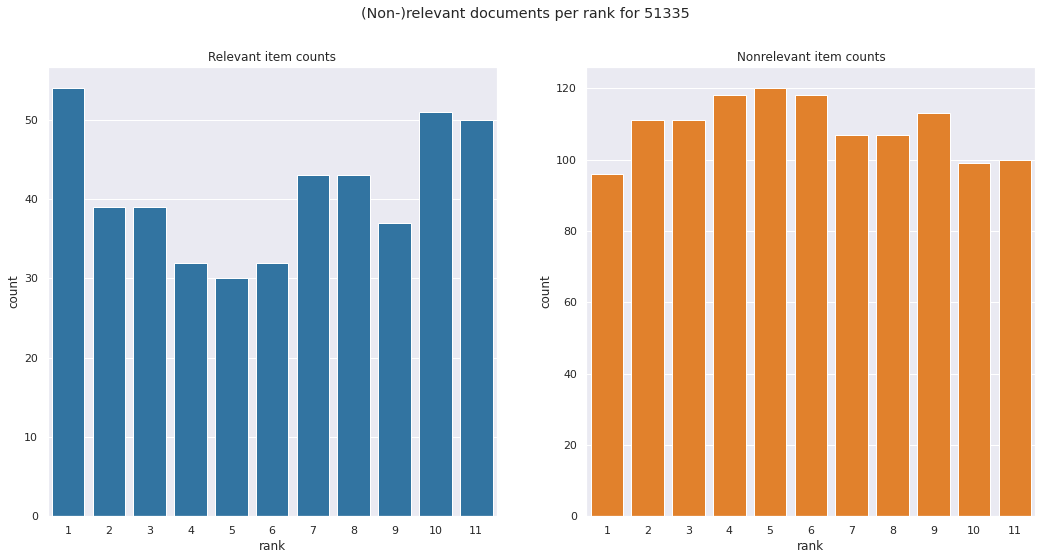

In [158]:
for q in topqueries.index.unique():
    plot_rel_nonrel_per_rank_per_relkind_for_qid(q, rdf, reldf)


##### Top queries
For the top queries, we see that the relevant documents are reasonably evenly distributed or skewed towards the higher rankings.

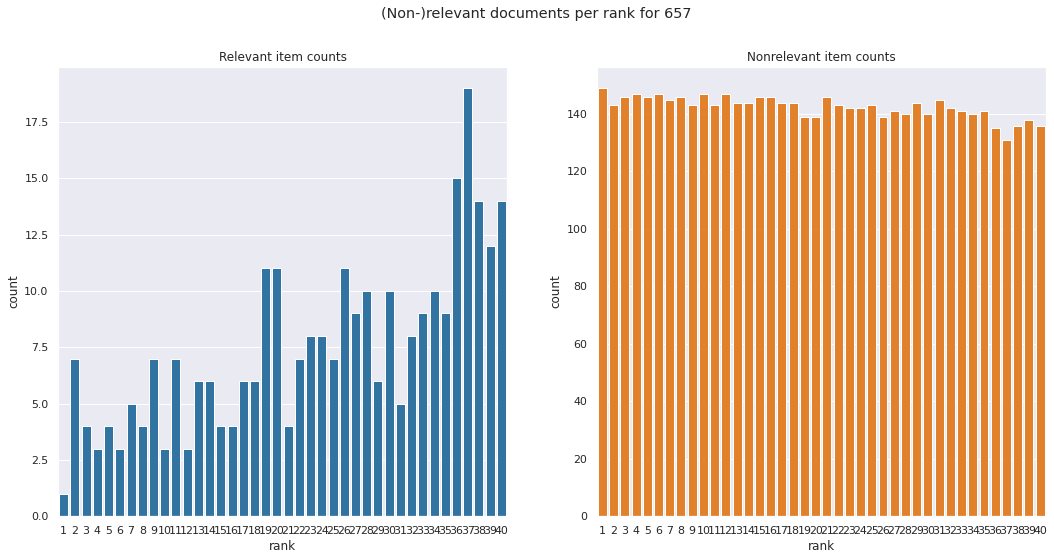

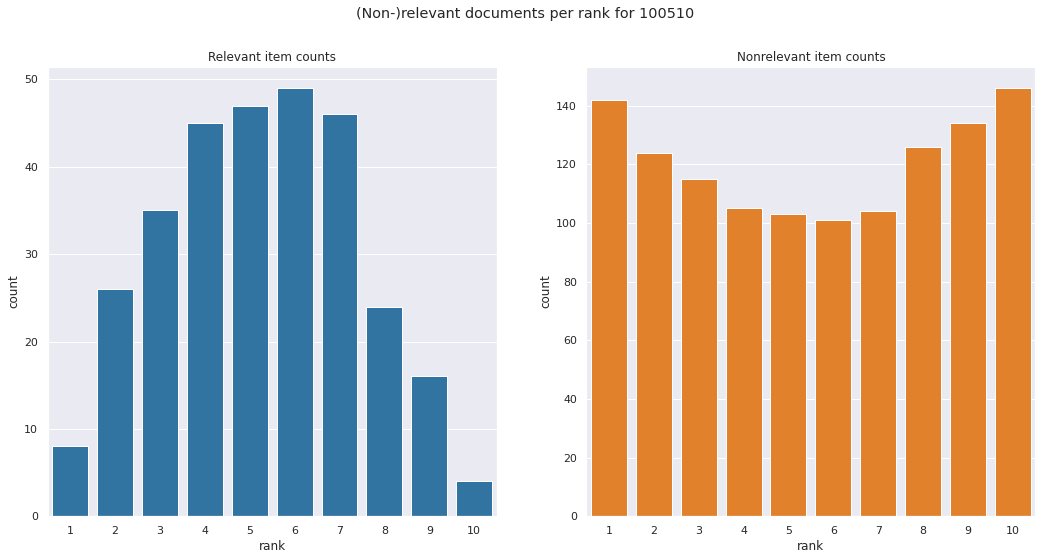

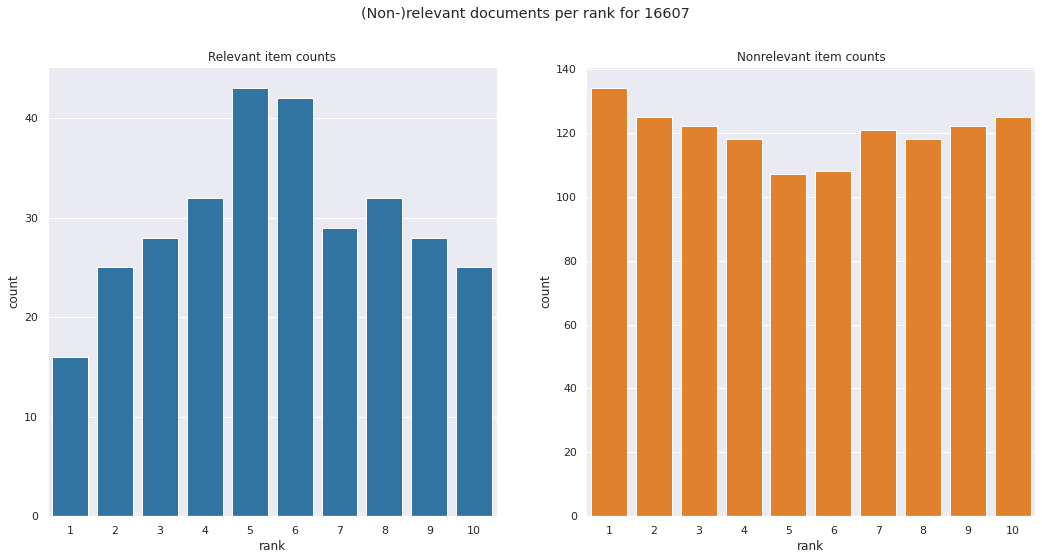

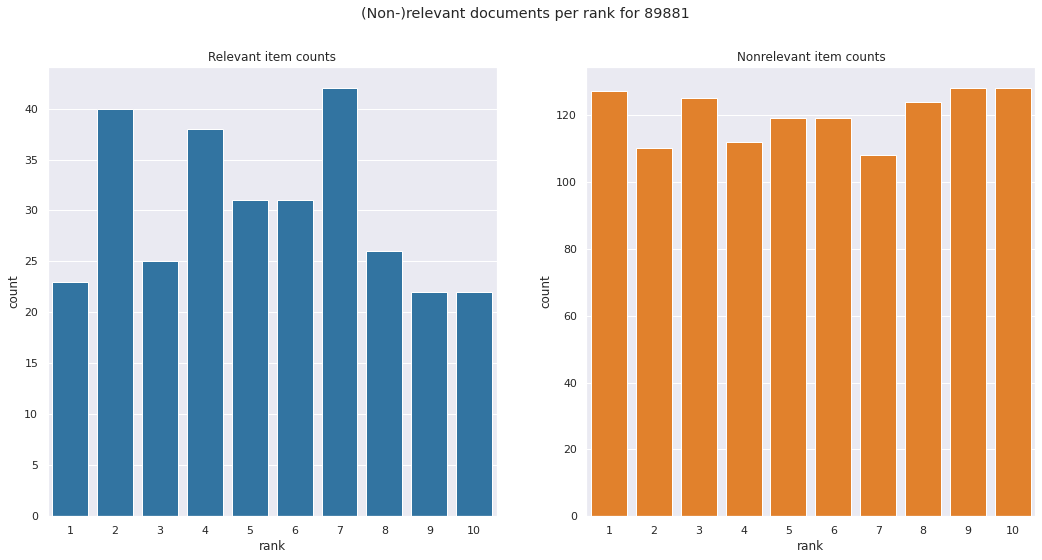

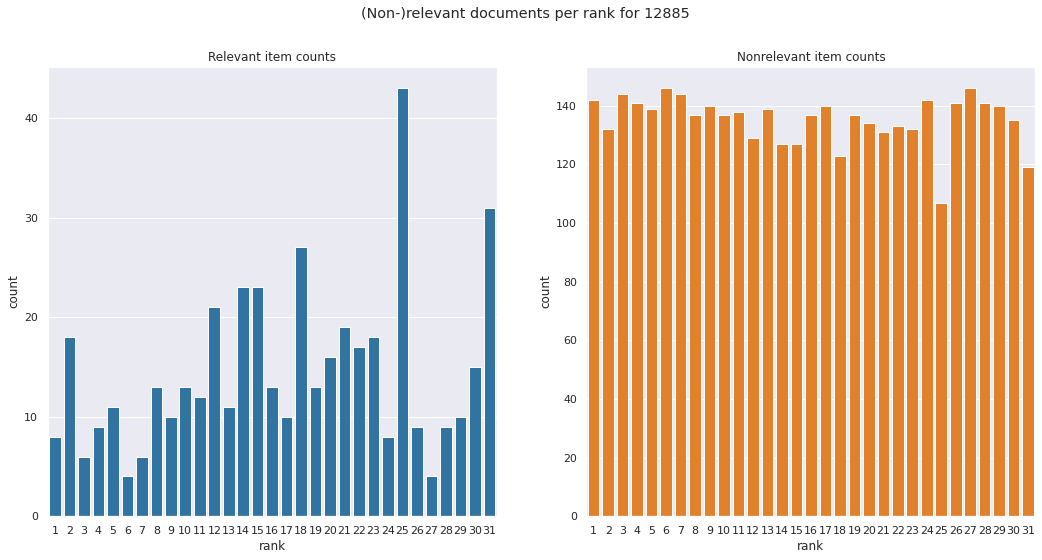

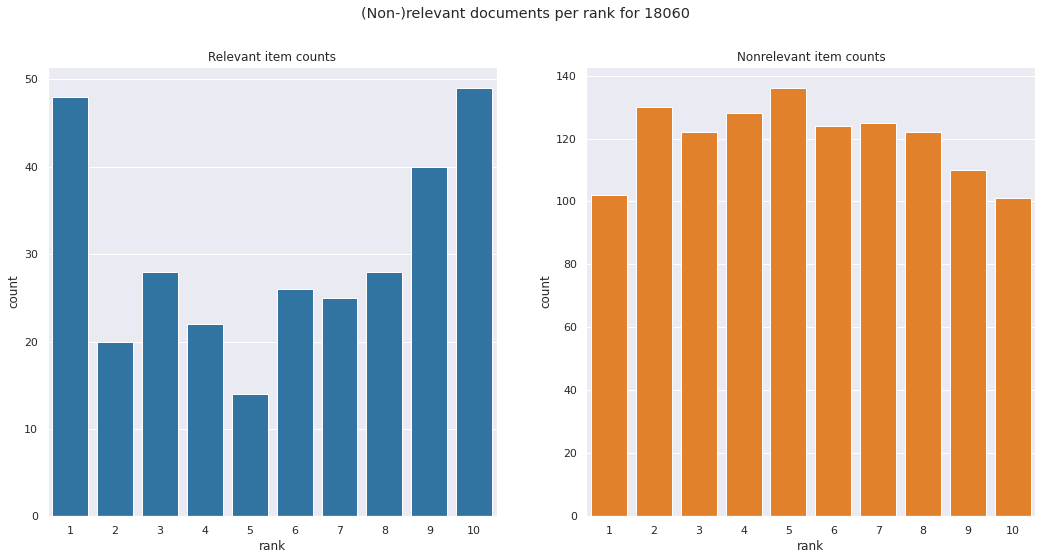

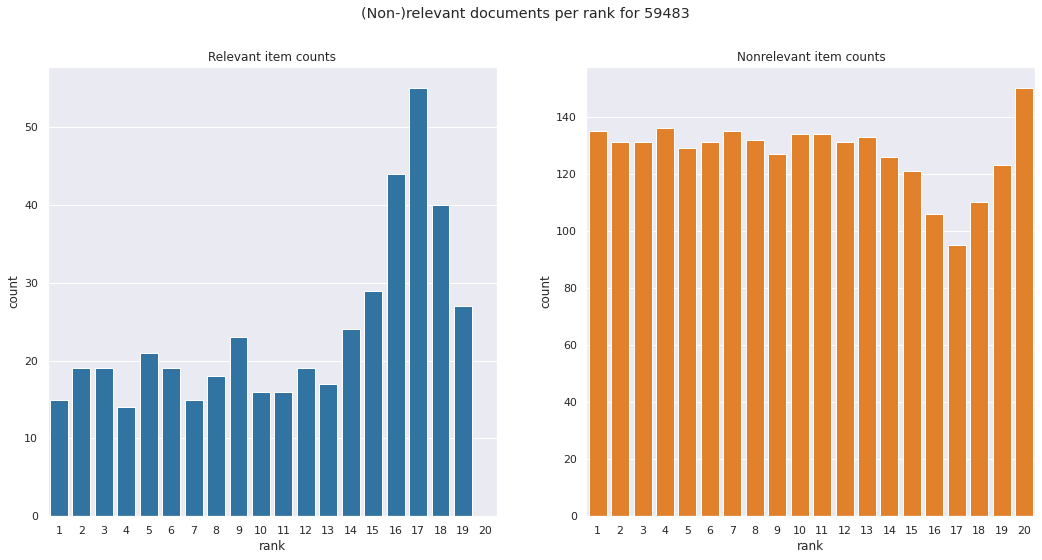

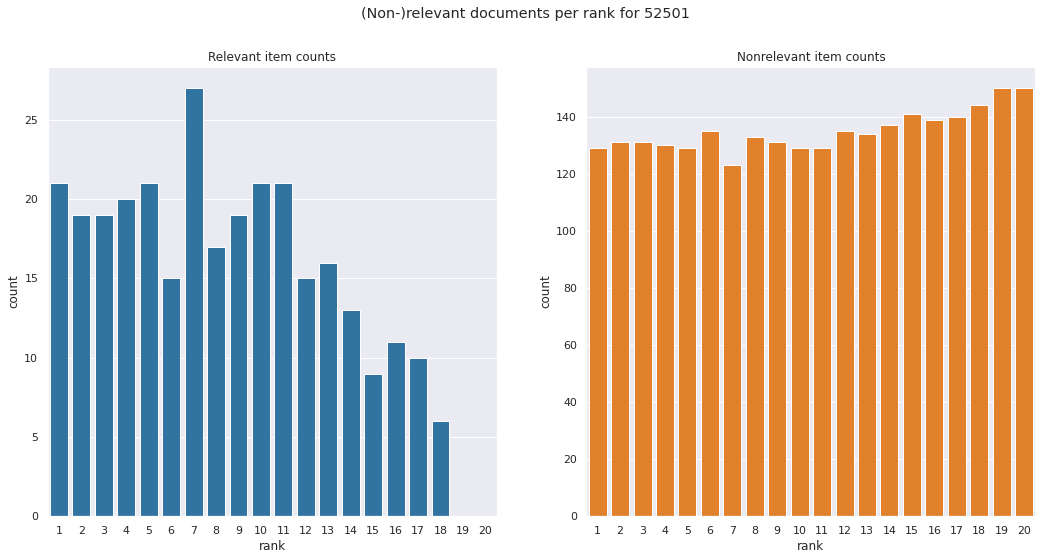

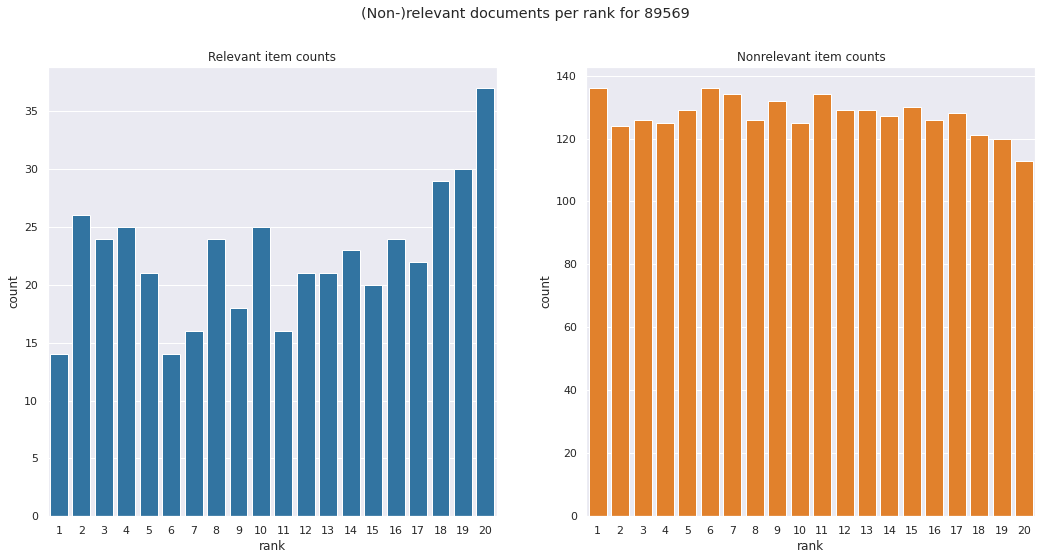

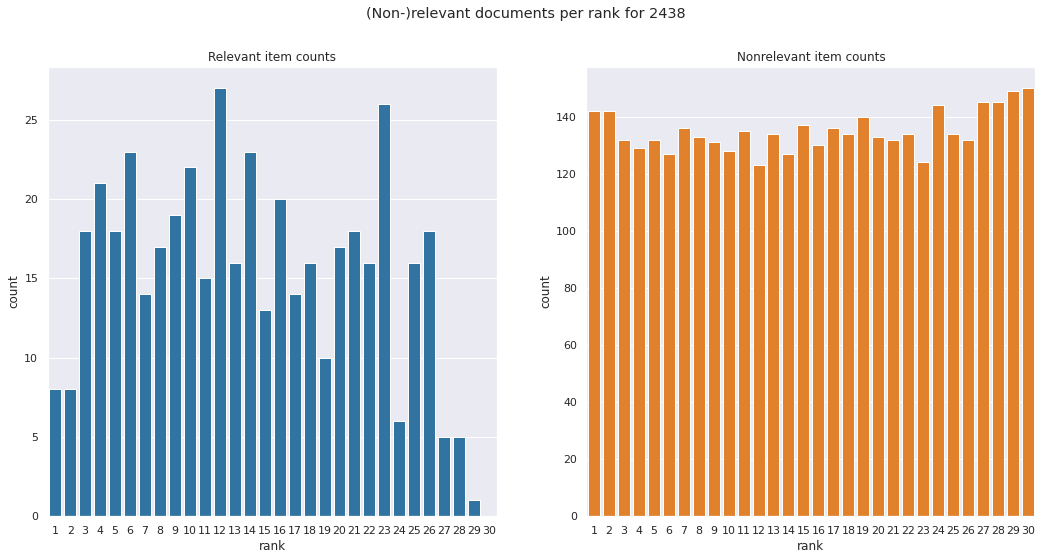

In [160]:
for q in bottomqueries.index.unique():
    plot_rel_nonrel_per_rank_per_relkind_for_qid(q, rdf, reldf)


##### Bottom queries
For the bottom queries we see that the relevant items are concentrated to either the middle or bottom ranks. **An exception is query 52501, where the relevant documents skew towards the top positions, and no relevant items are in the bottom positions at all.**

#### Doc occurrence per rank
We plot how often each document occurs at each rank. We plot all of the top positions and the bottom 5 positions.

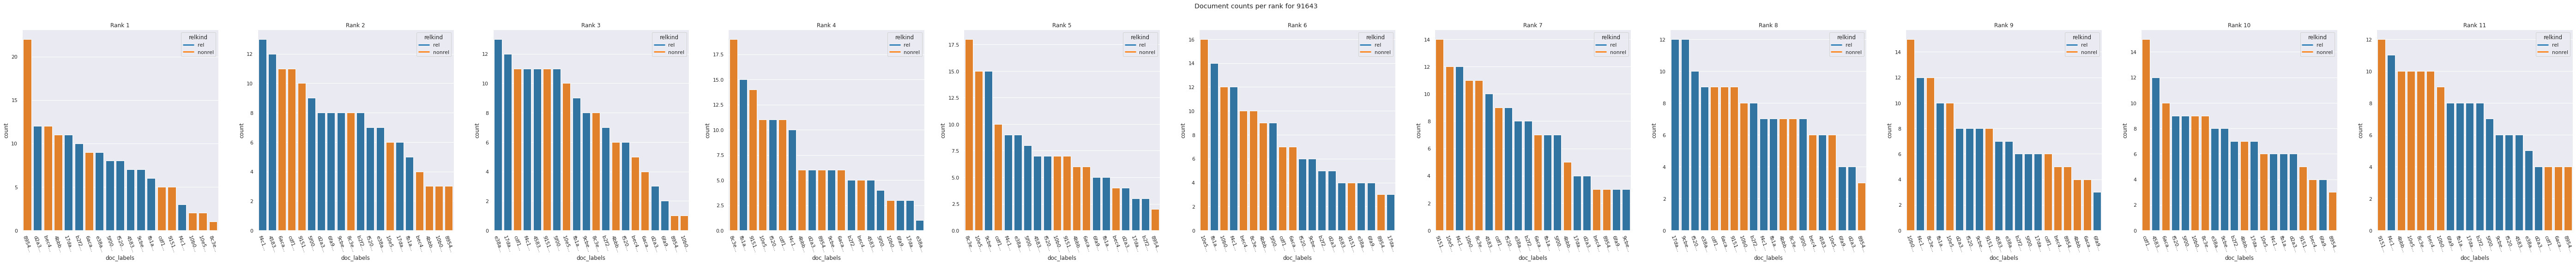

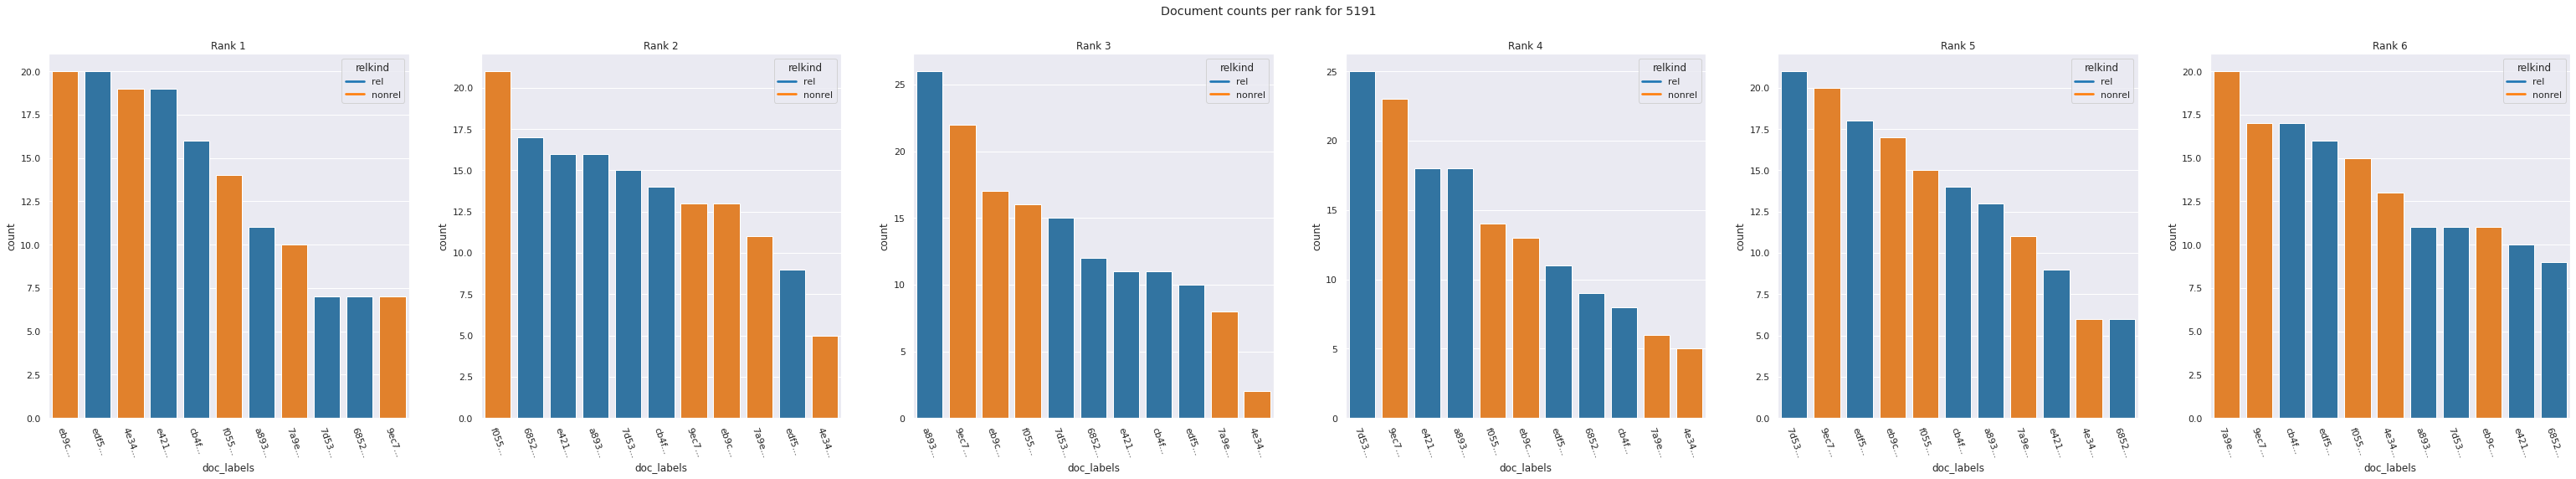

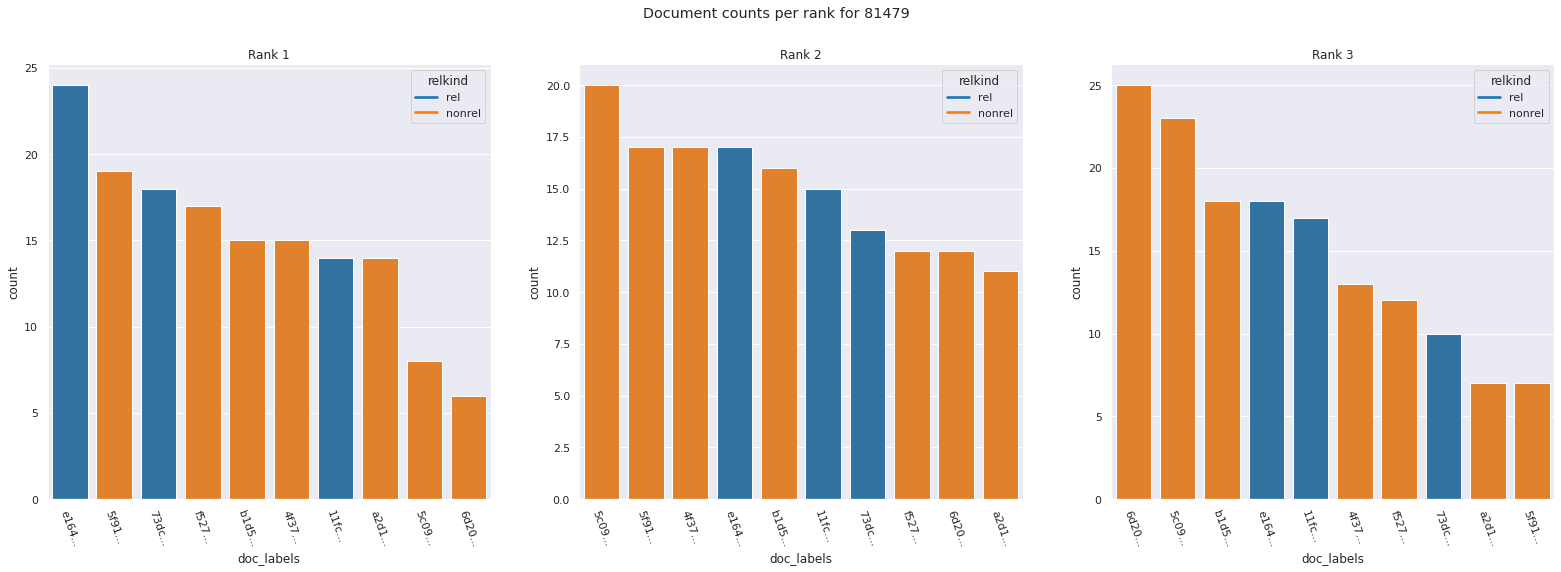

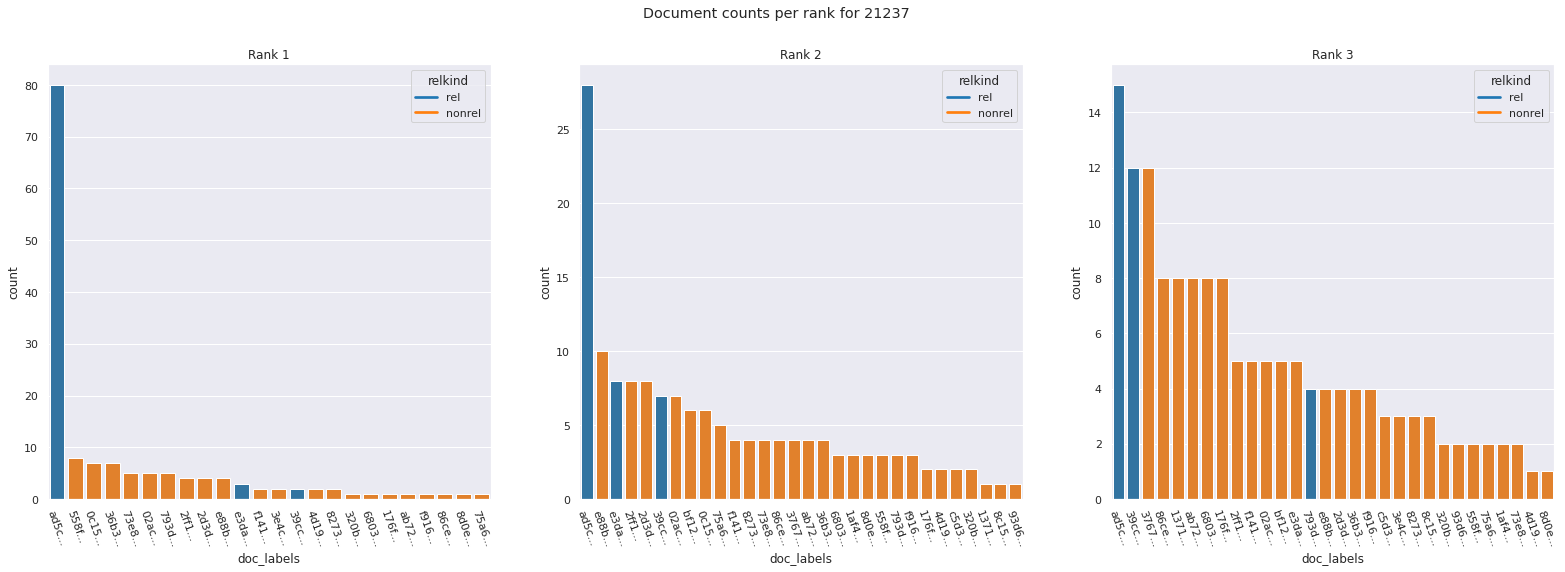

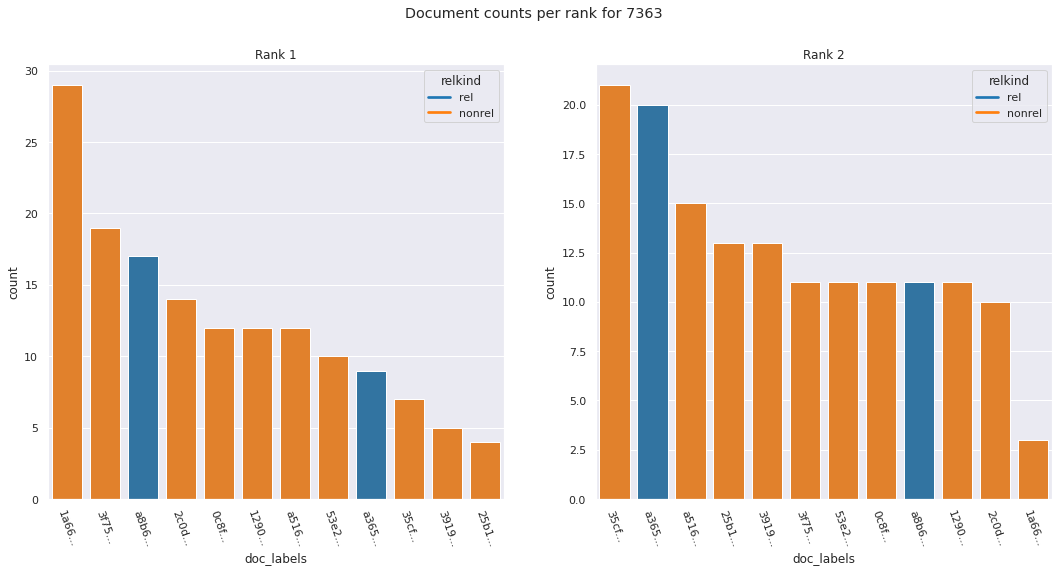

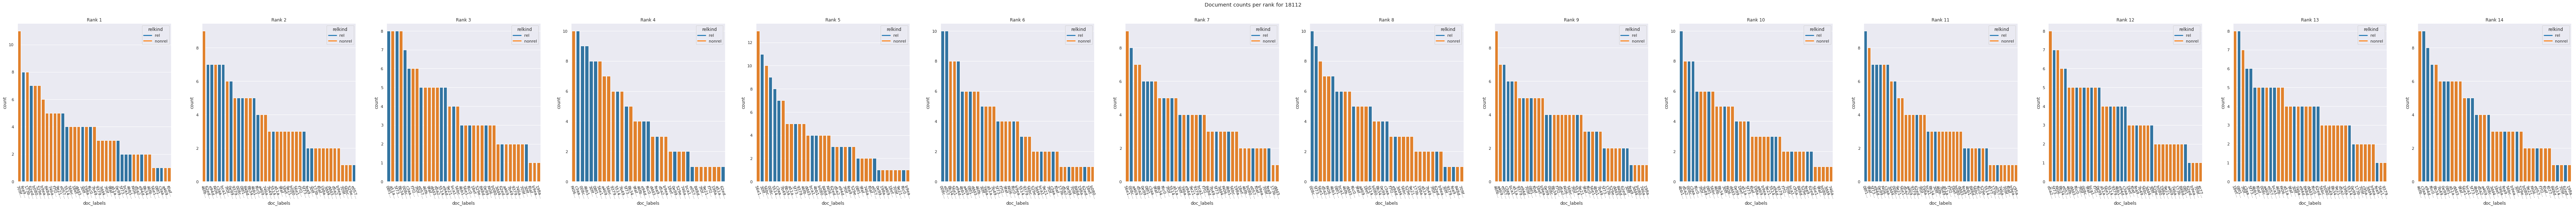

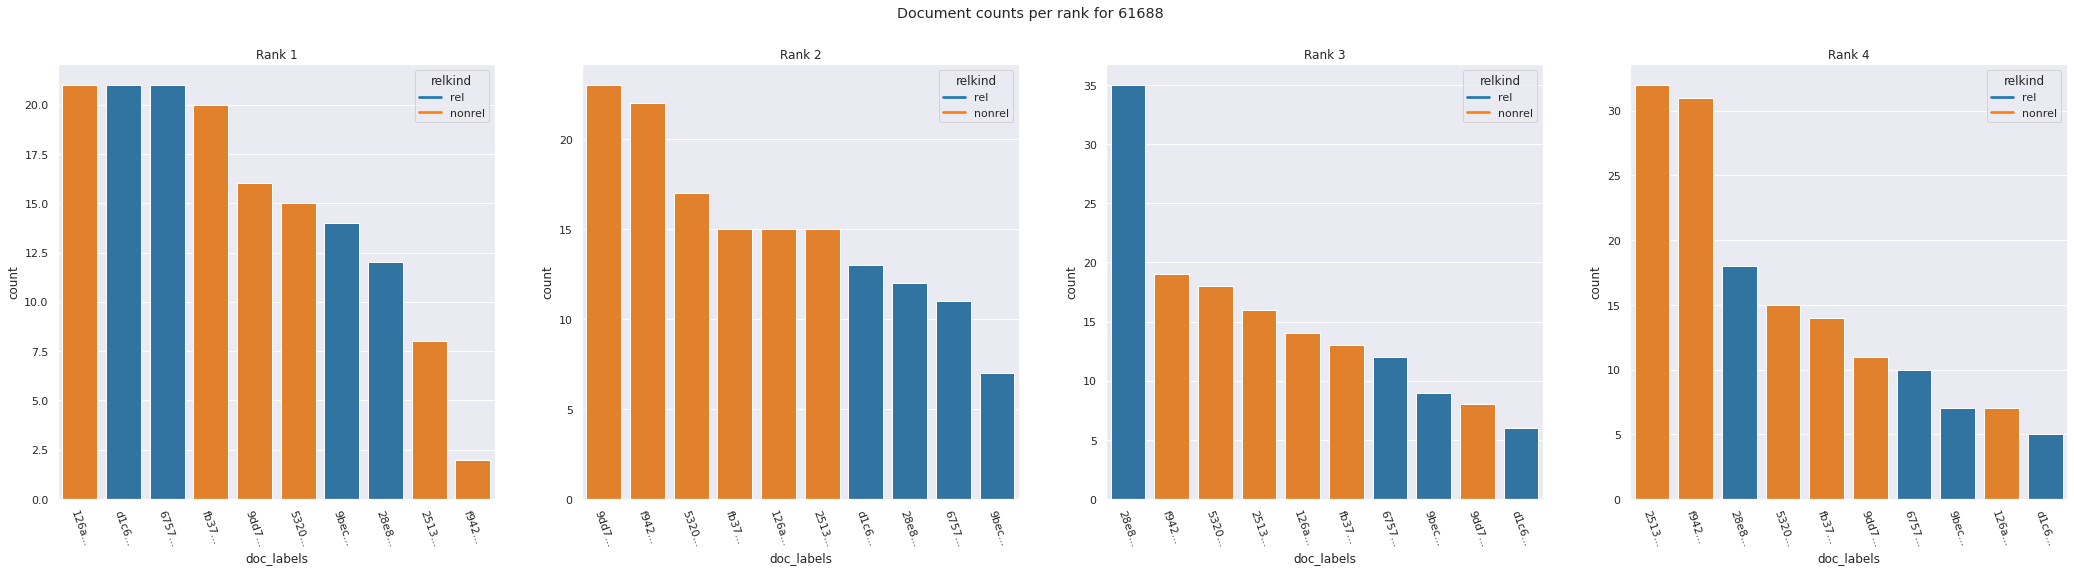

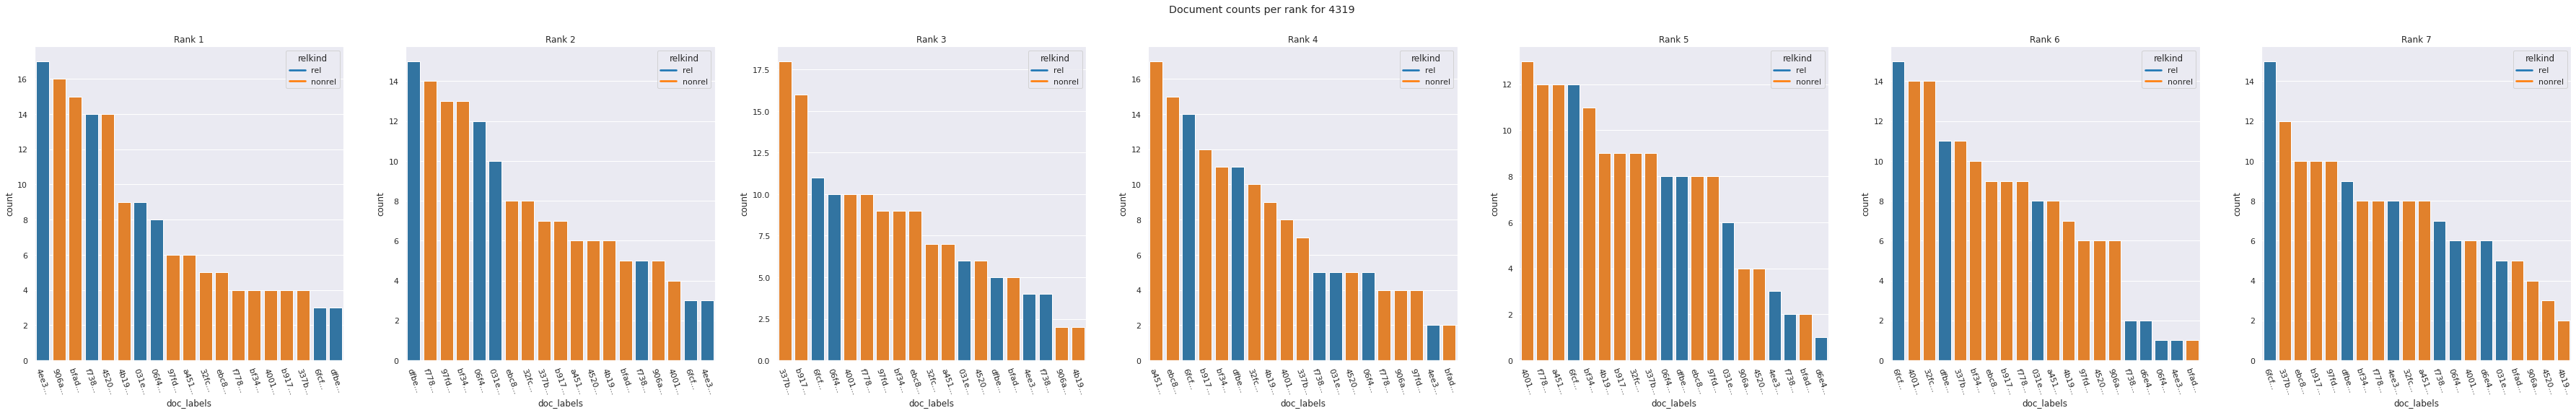

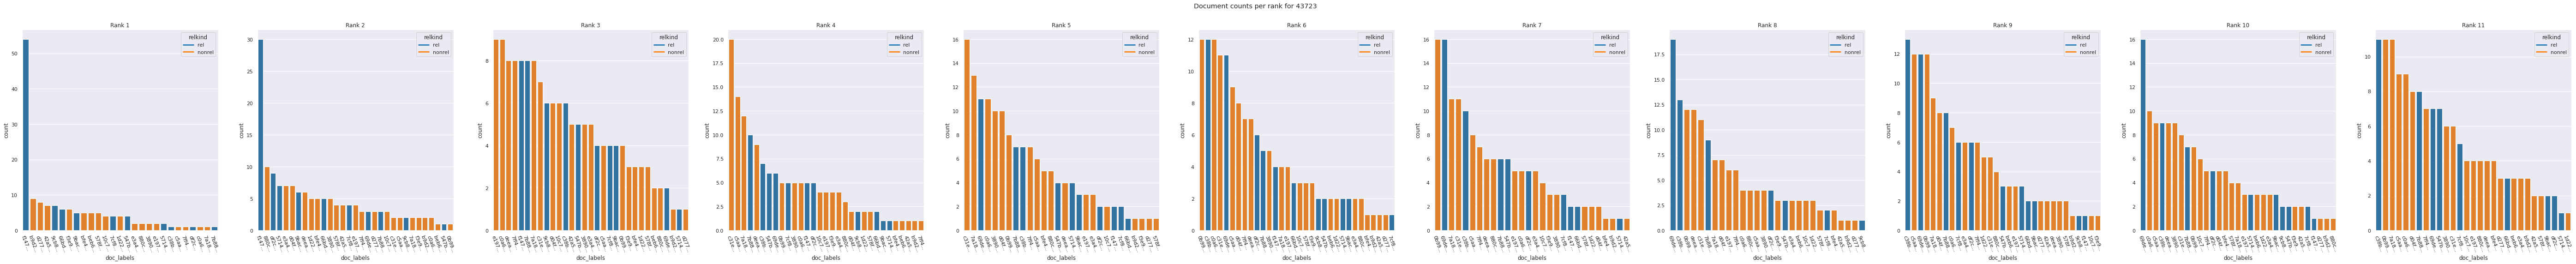

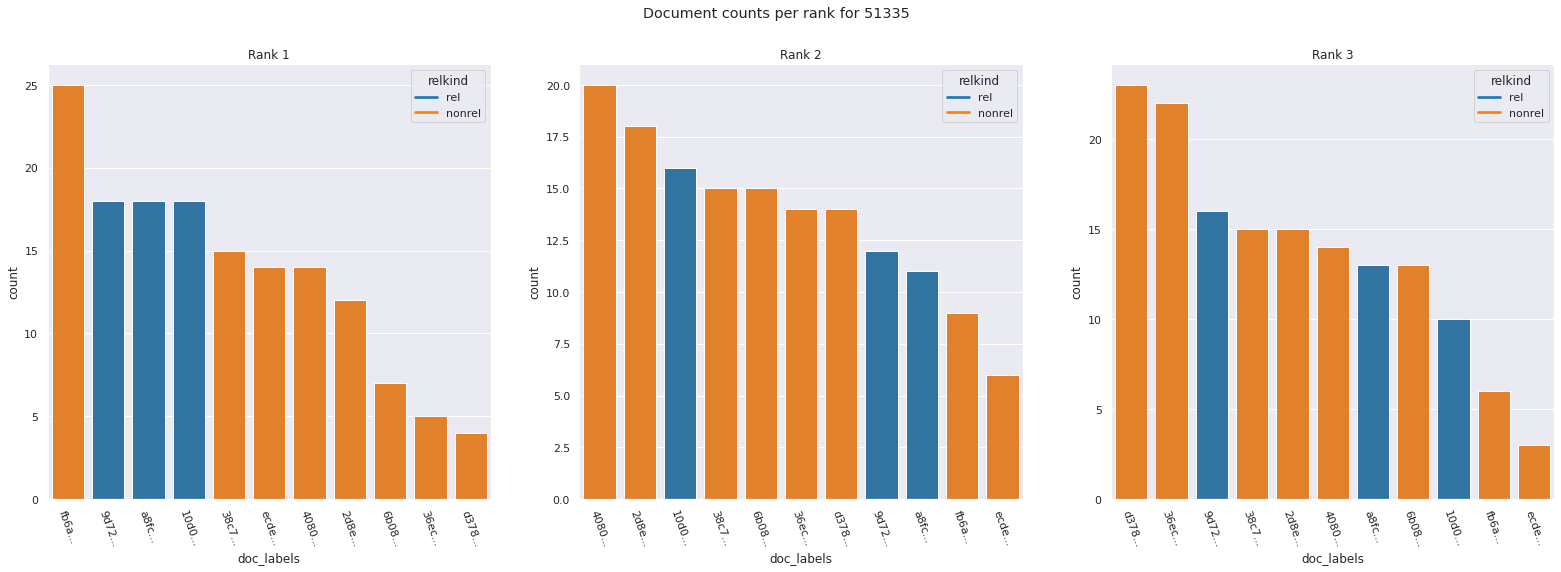

In [164]:
for q in topqueries.index.unique():
    rel,nonrel = count_relgrades_qid(q,reldf)
    plot_doc_occurrence_per_rank_for_qid(q,rdf,reldf,k=rel)


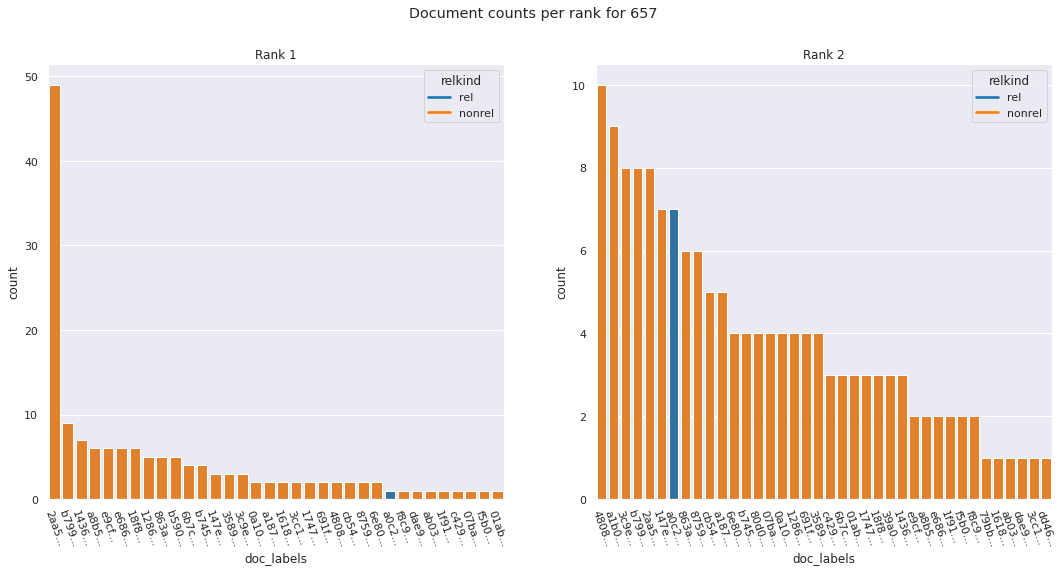

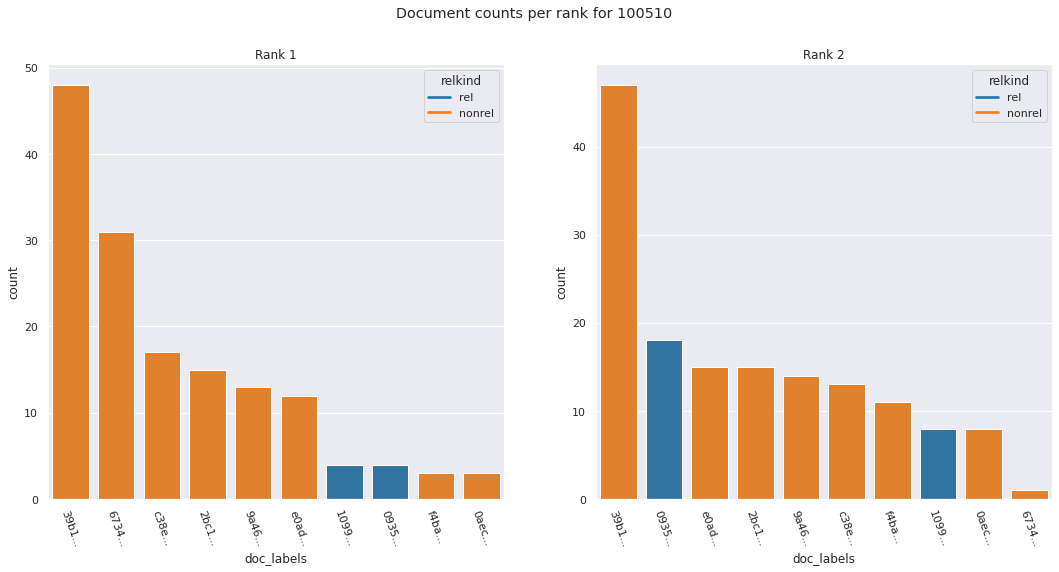

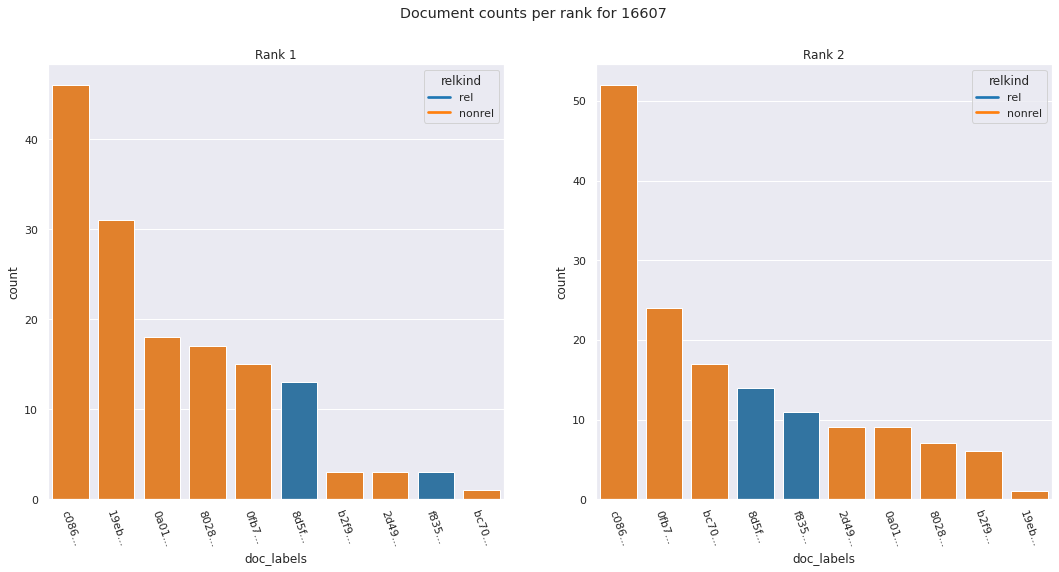

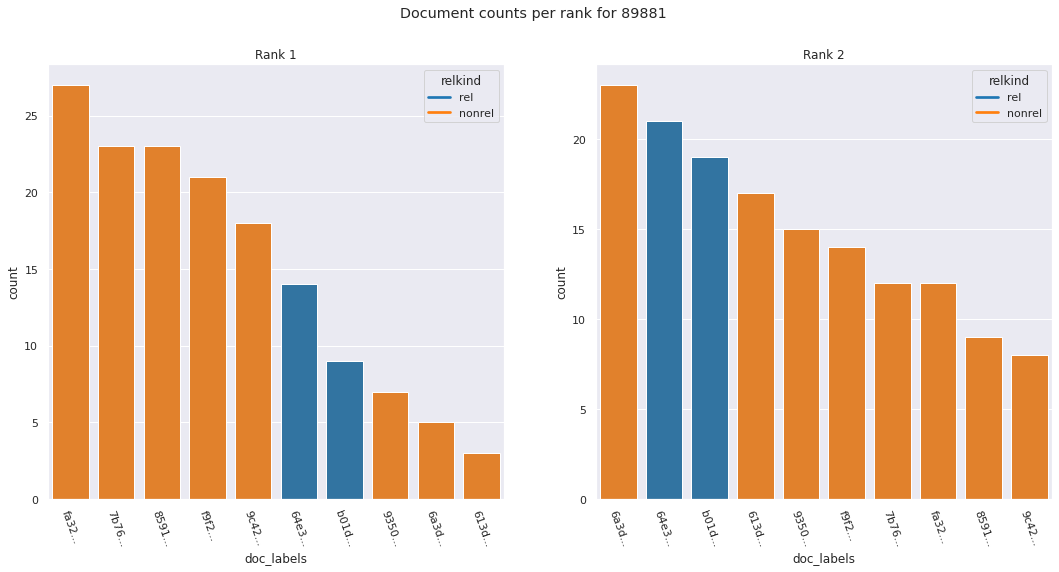

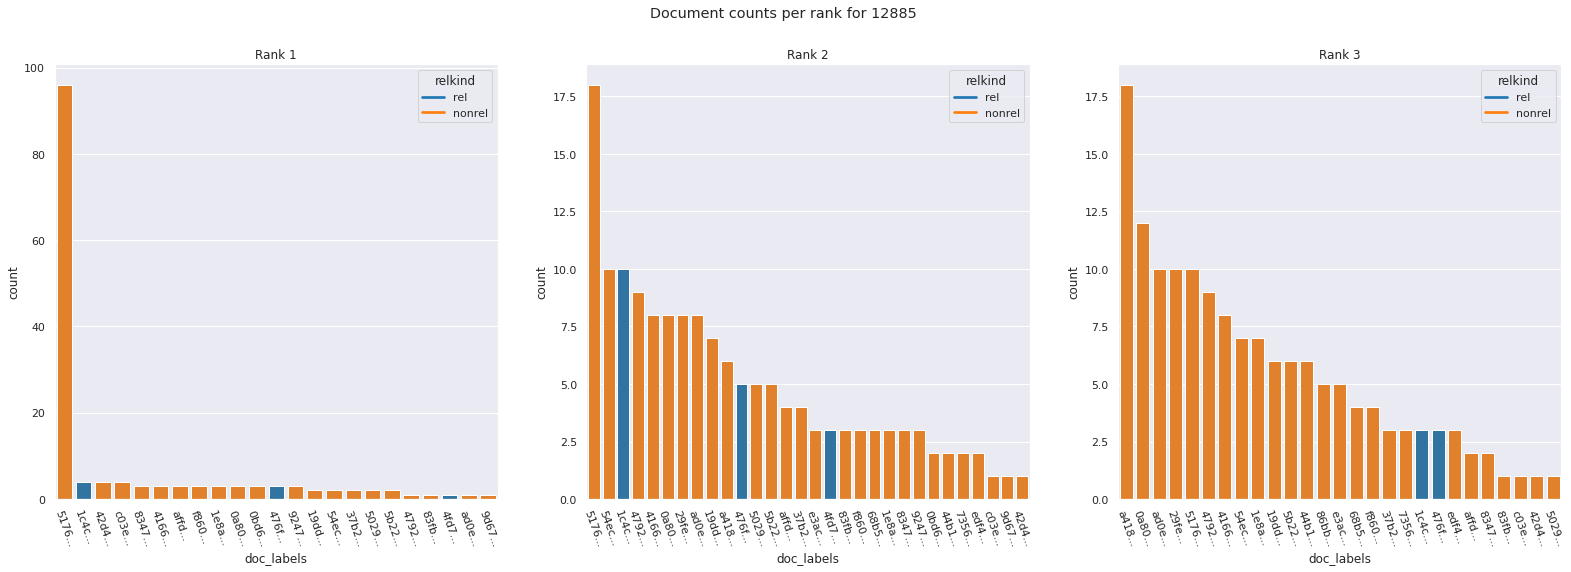

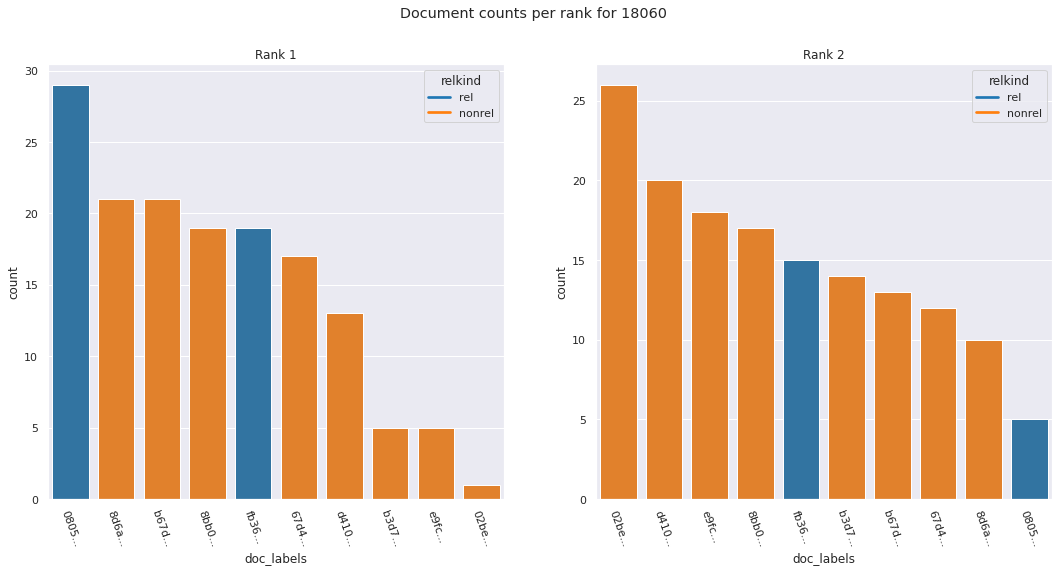

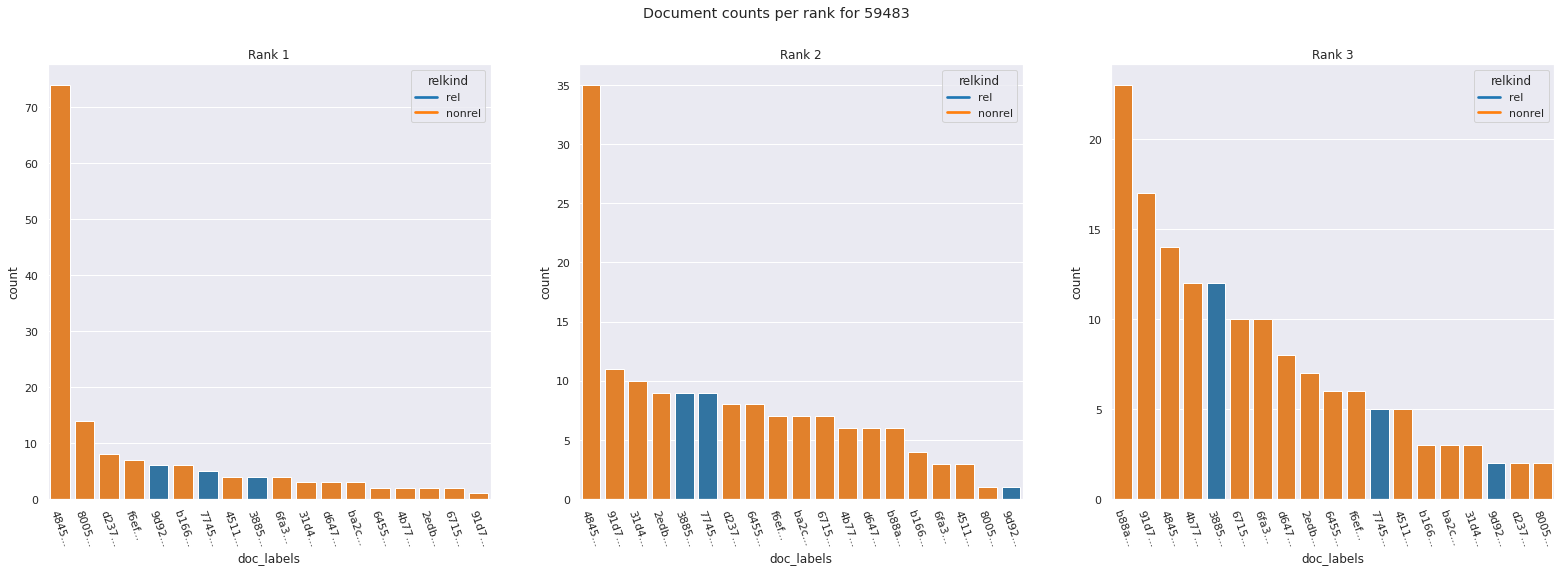

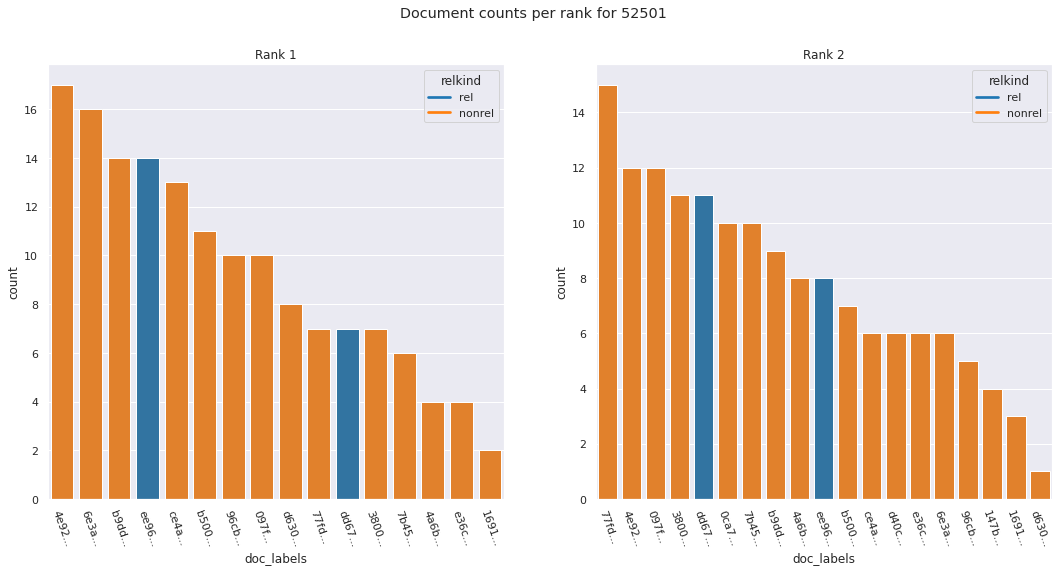

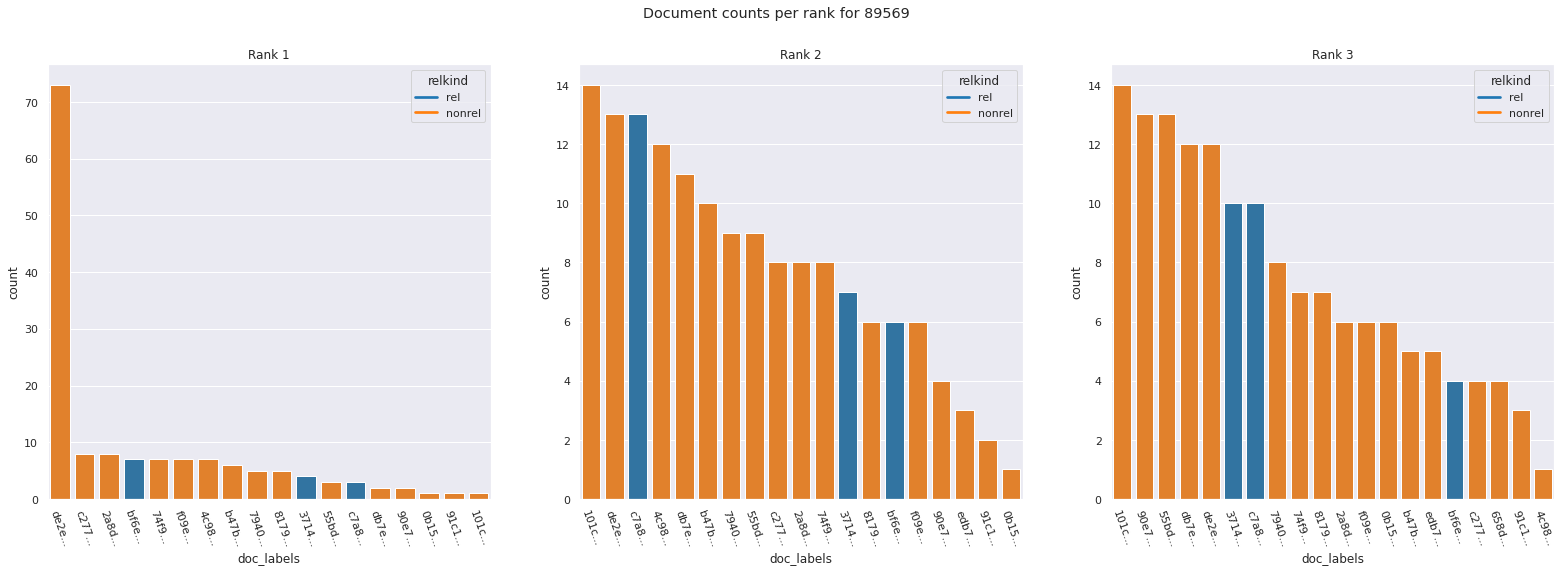

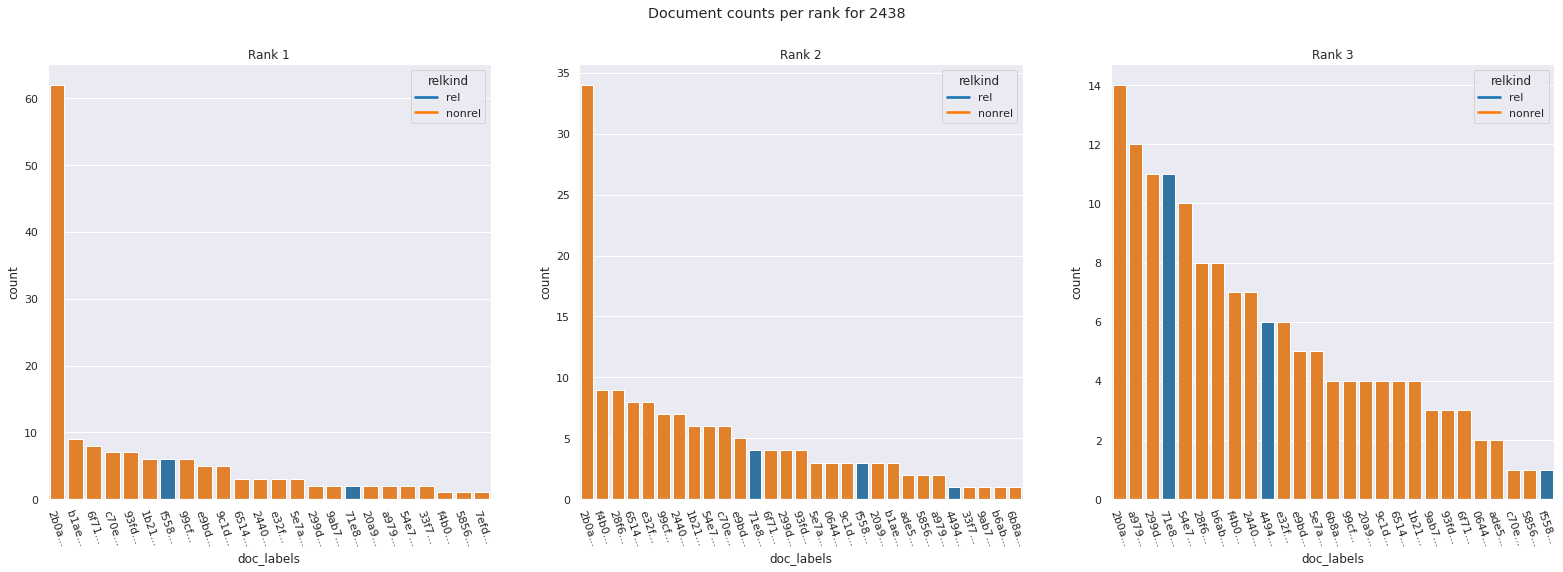

In [165]:
for q in bottomqueries.index.unique():
    rel,nonrel = count_relgrades_qid(q,reldf)
    plot_doc_occurrence_per_rank_for_qid(q,rdf,reldf,k=rel)
    

##### Top positions

Remarks:
- The top queries have a larger number of relevant items than the bottom queries on average
  - **Hypothesis**: if a query has a larger *fraction* of relevant items it performs better, because the chance that a a relevant item lands in a top position is larger.
  
- The top queries in general have a gently diminishing distribution over the number of times documents occur in a rank, with some exceptions.


    - The top performing query, qid=91643, has a single irrelevant document spike in the first position.
        - The negative contribution of this document is offset by the fact that the rest of the top positions are reasonably often filled with relevant items?

    - 21237, 43723 have a large spiked document, but it is relevant so therefore doesn't negatively influence the DGEE?
        - Is this also an authorless document?


- For the top queries, the relevant documents all at least appear in the top positions.
     - Exception: 4319, 18118 sometimes one of the relevant docs is missing. Which one is this and why is it missing?

- Many of the bottom queries have a large spike of an irrelevant document in a top position.
    - Aside from the spike the distribution generally diminishes gently.
- Some of the bottom queries are missing a relevant document in the top position:
    - 657, 12885


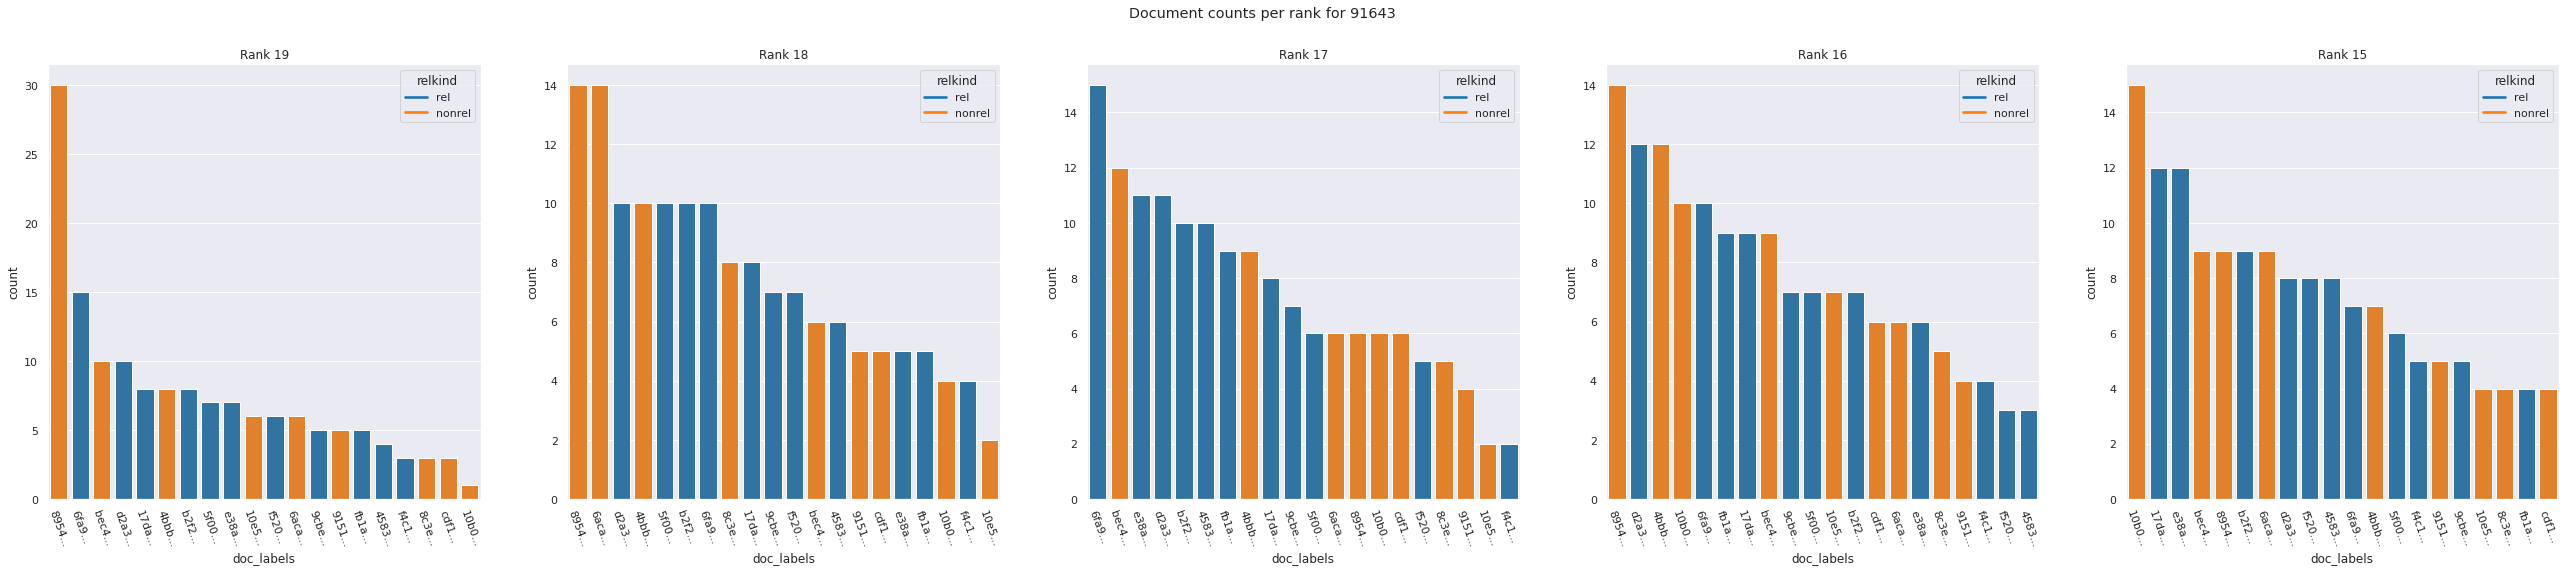

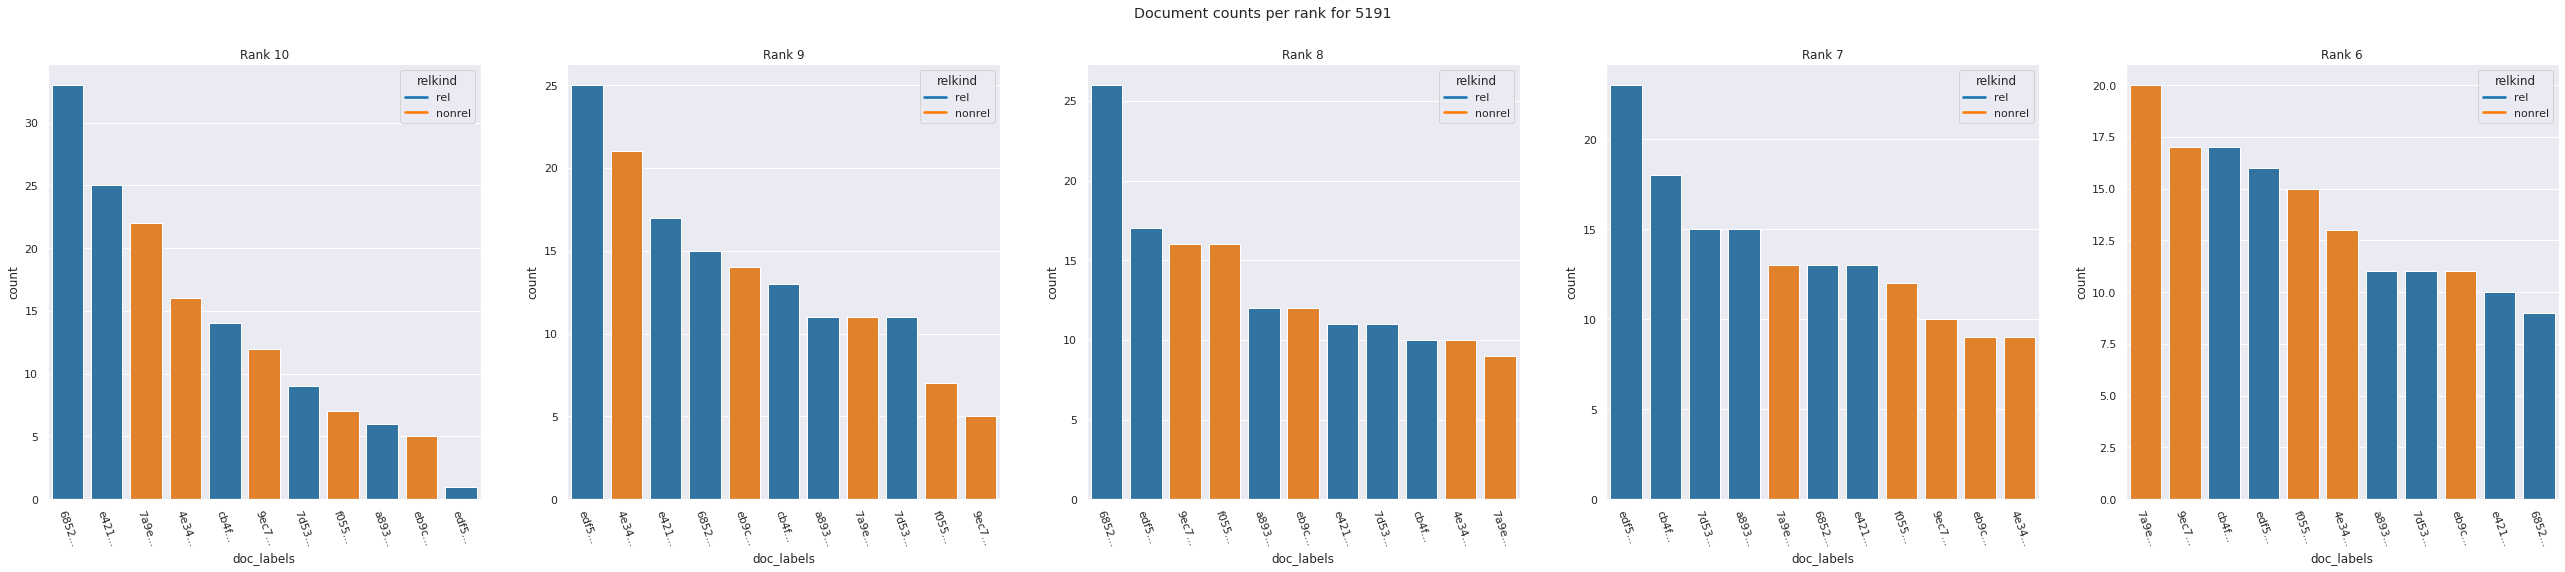

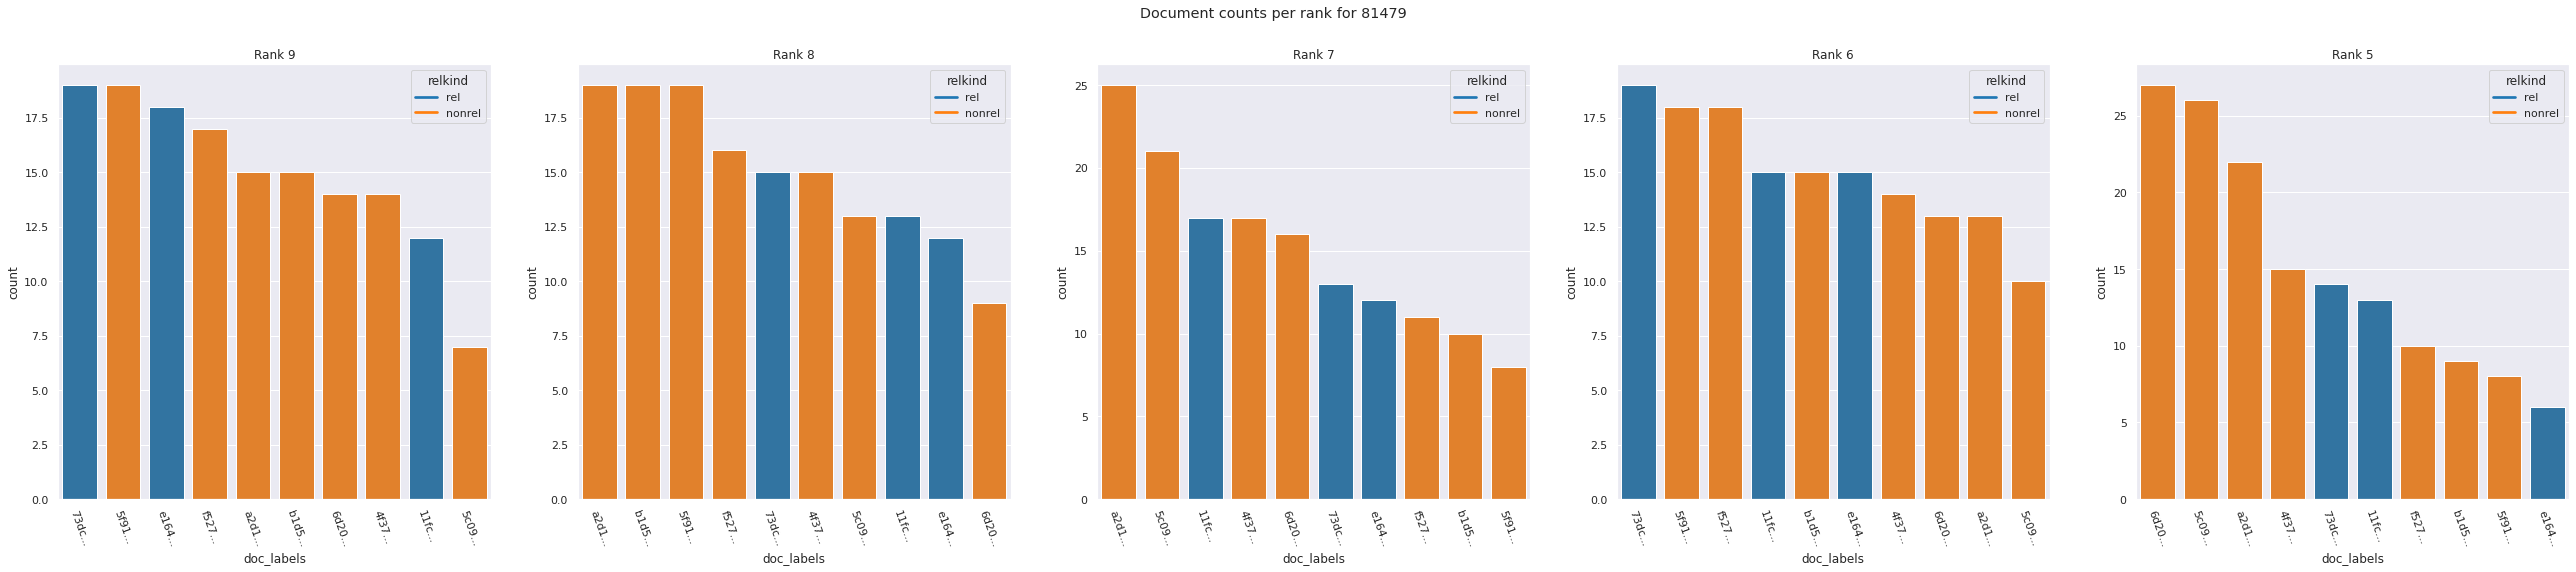

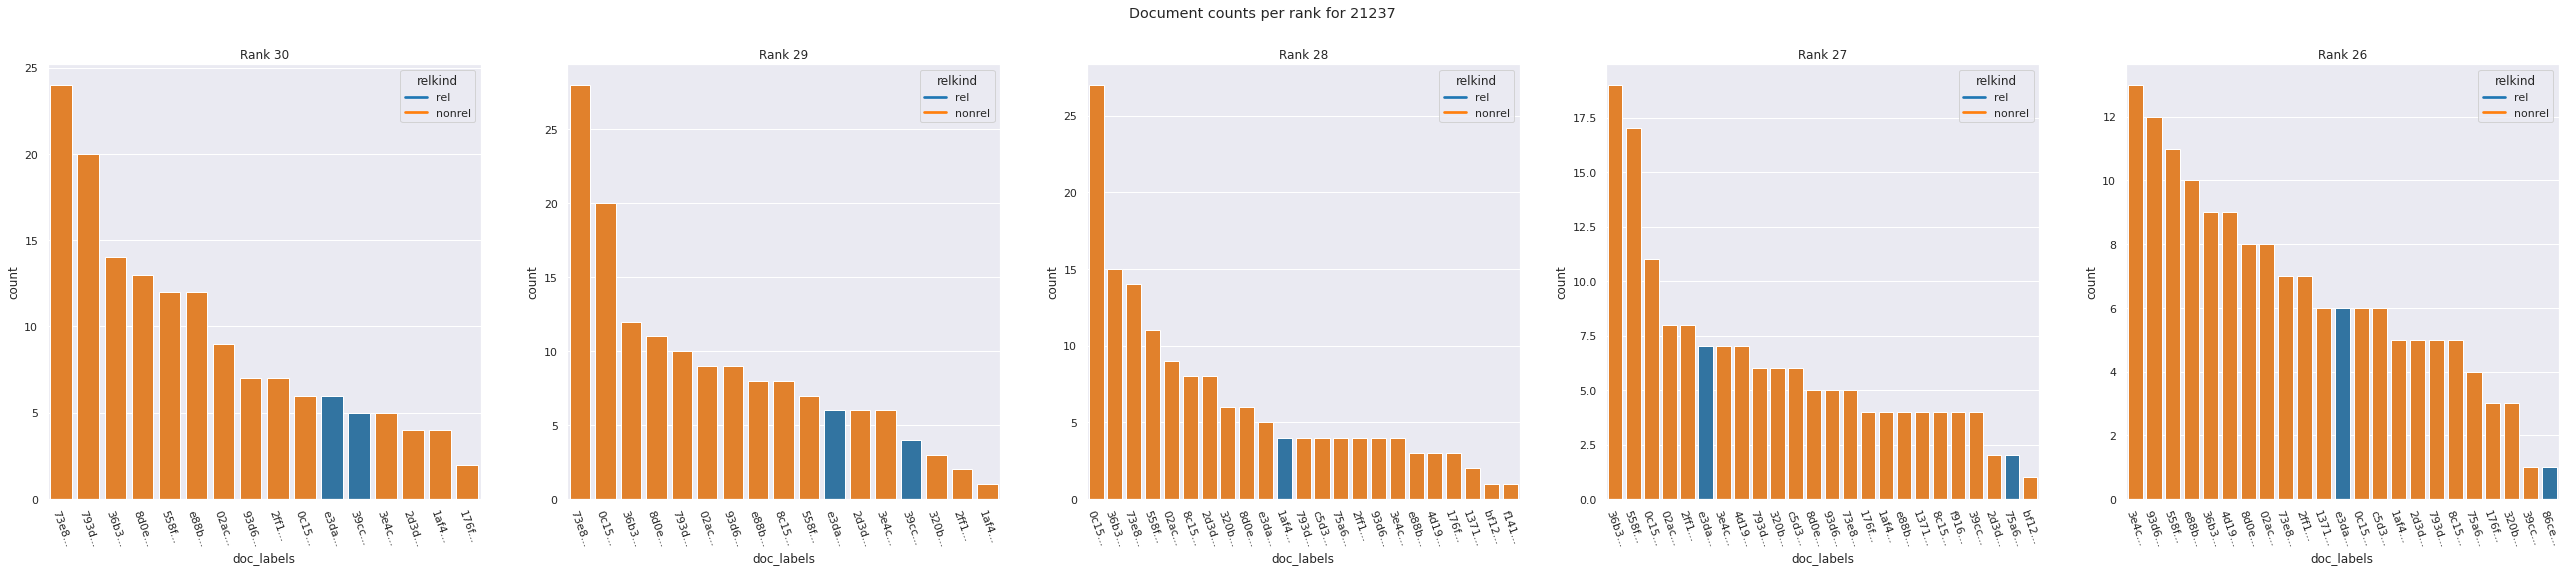

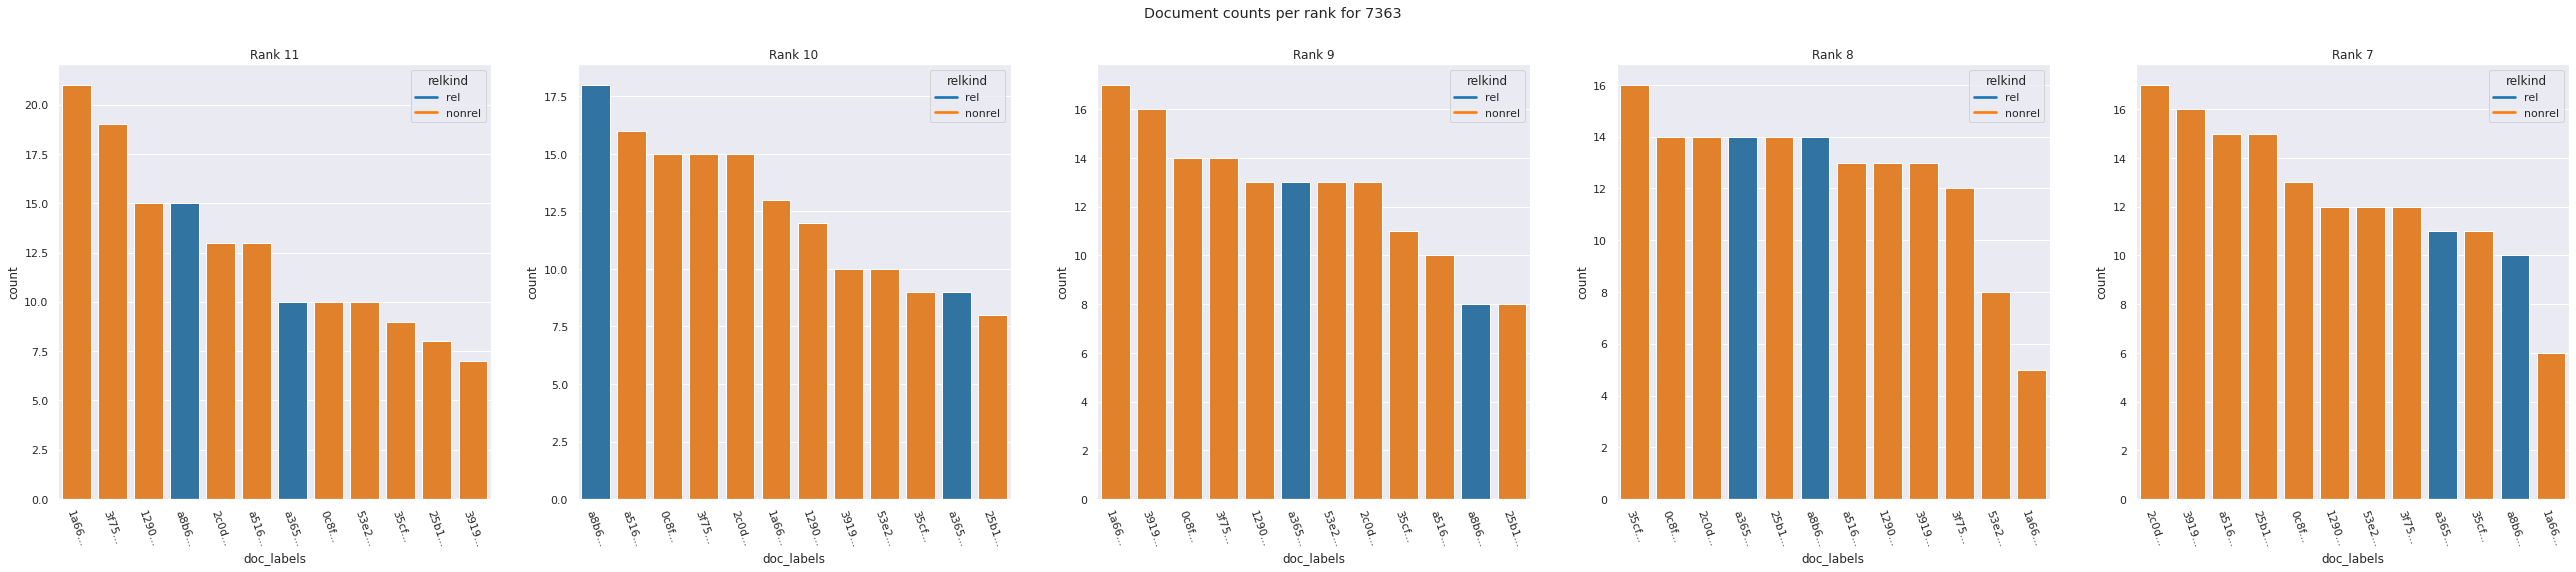

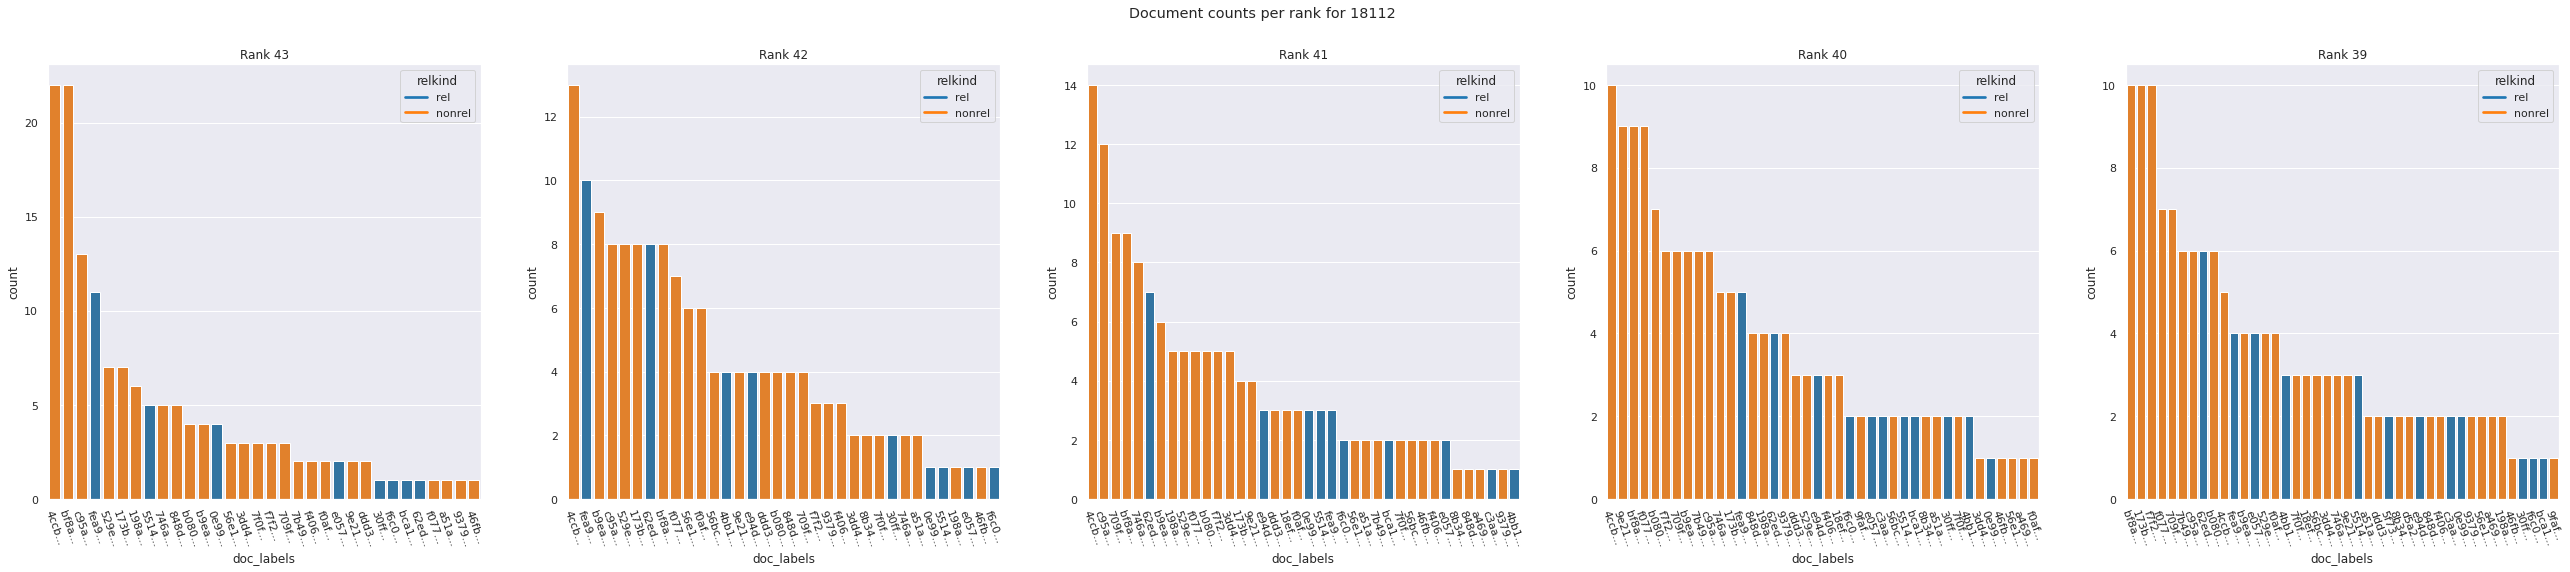

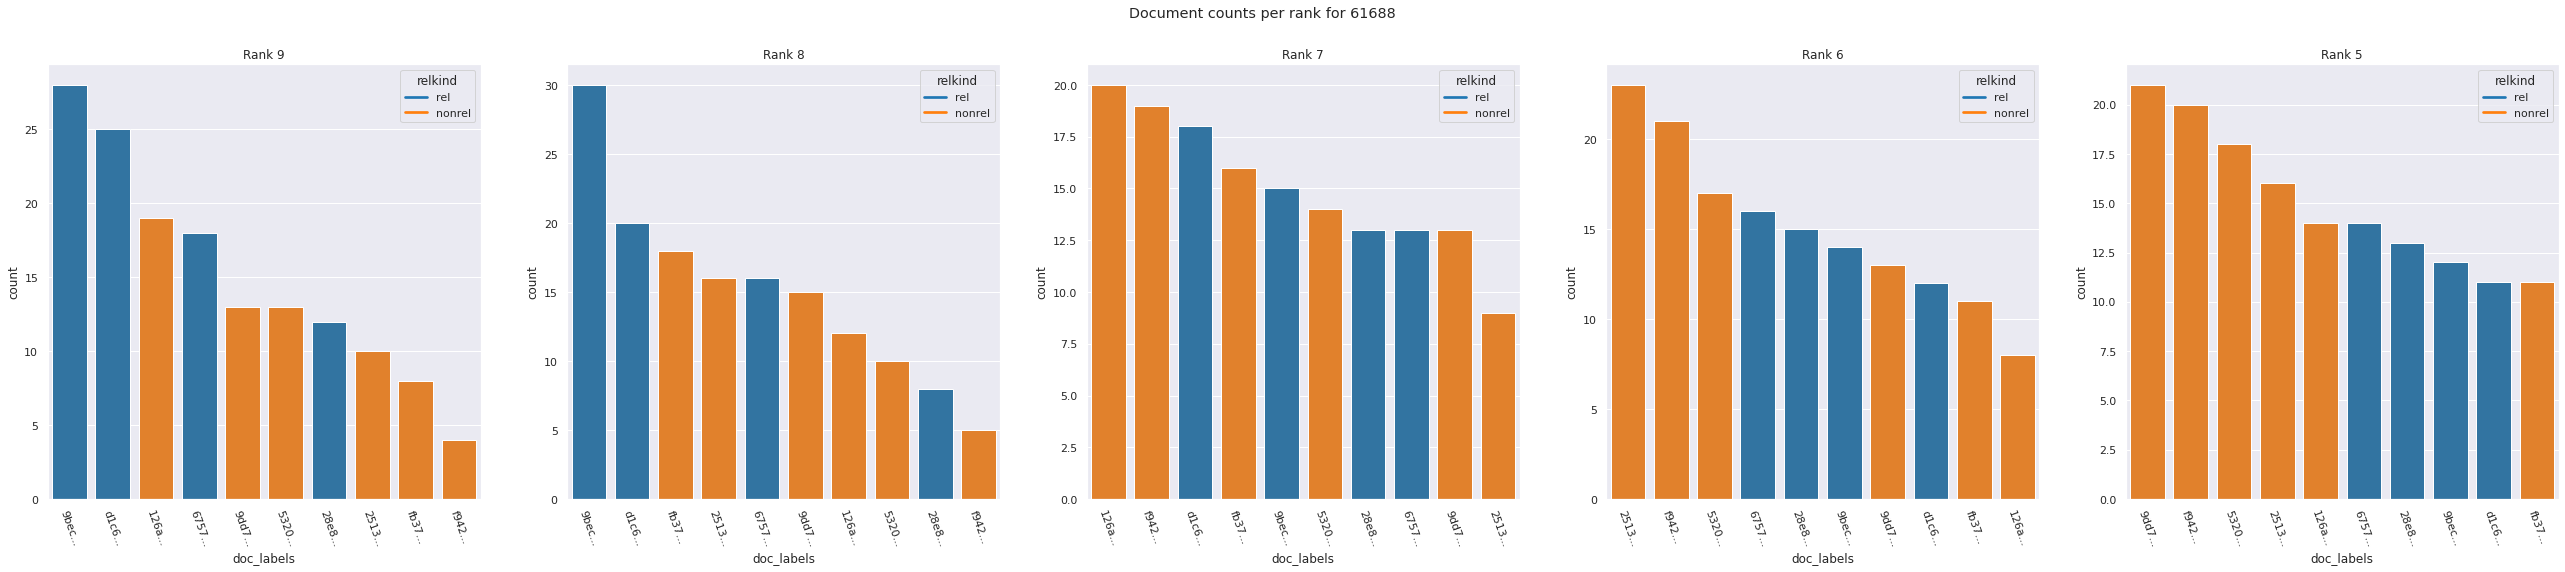

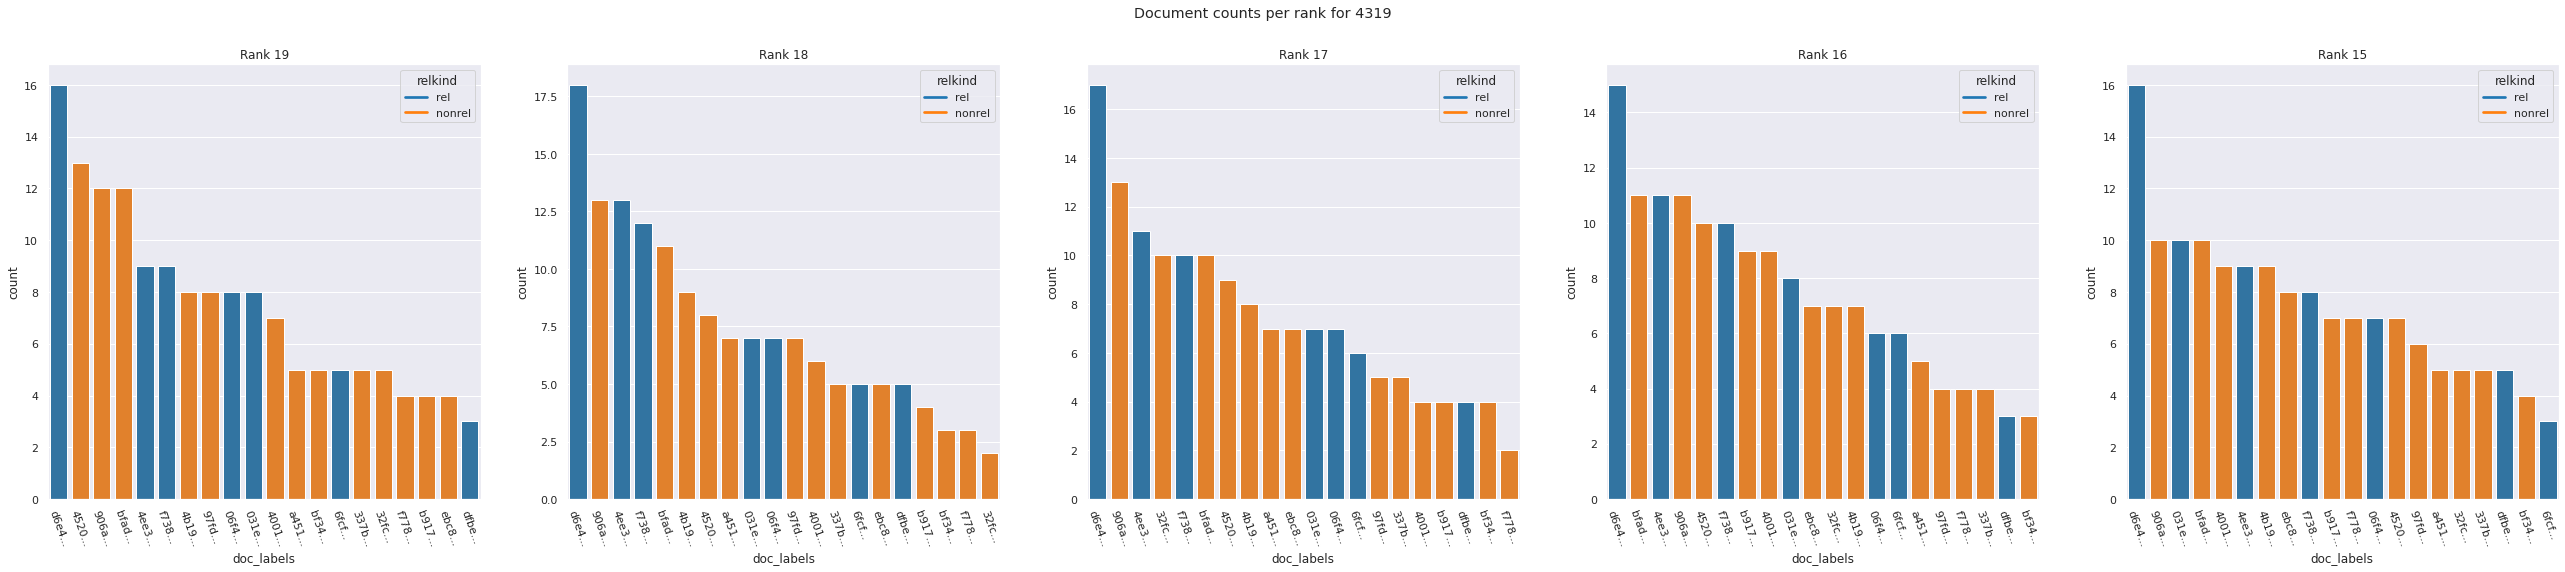

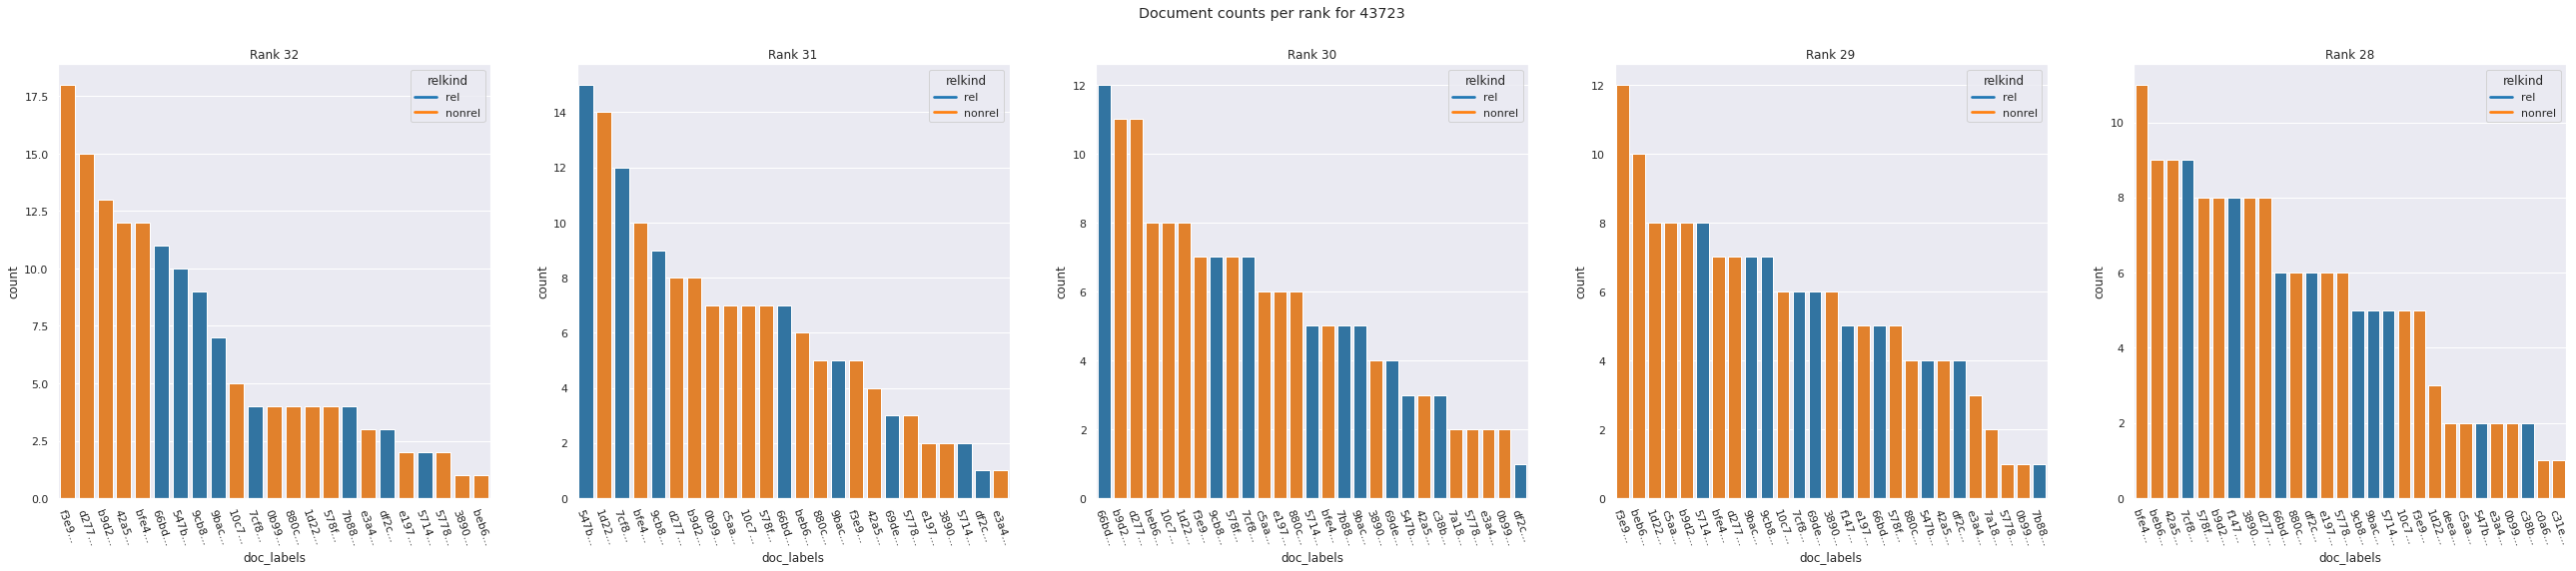

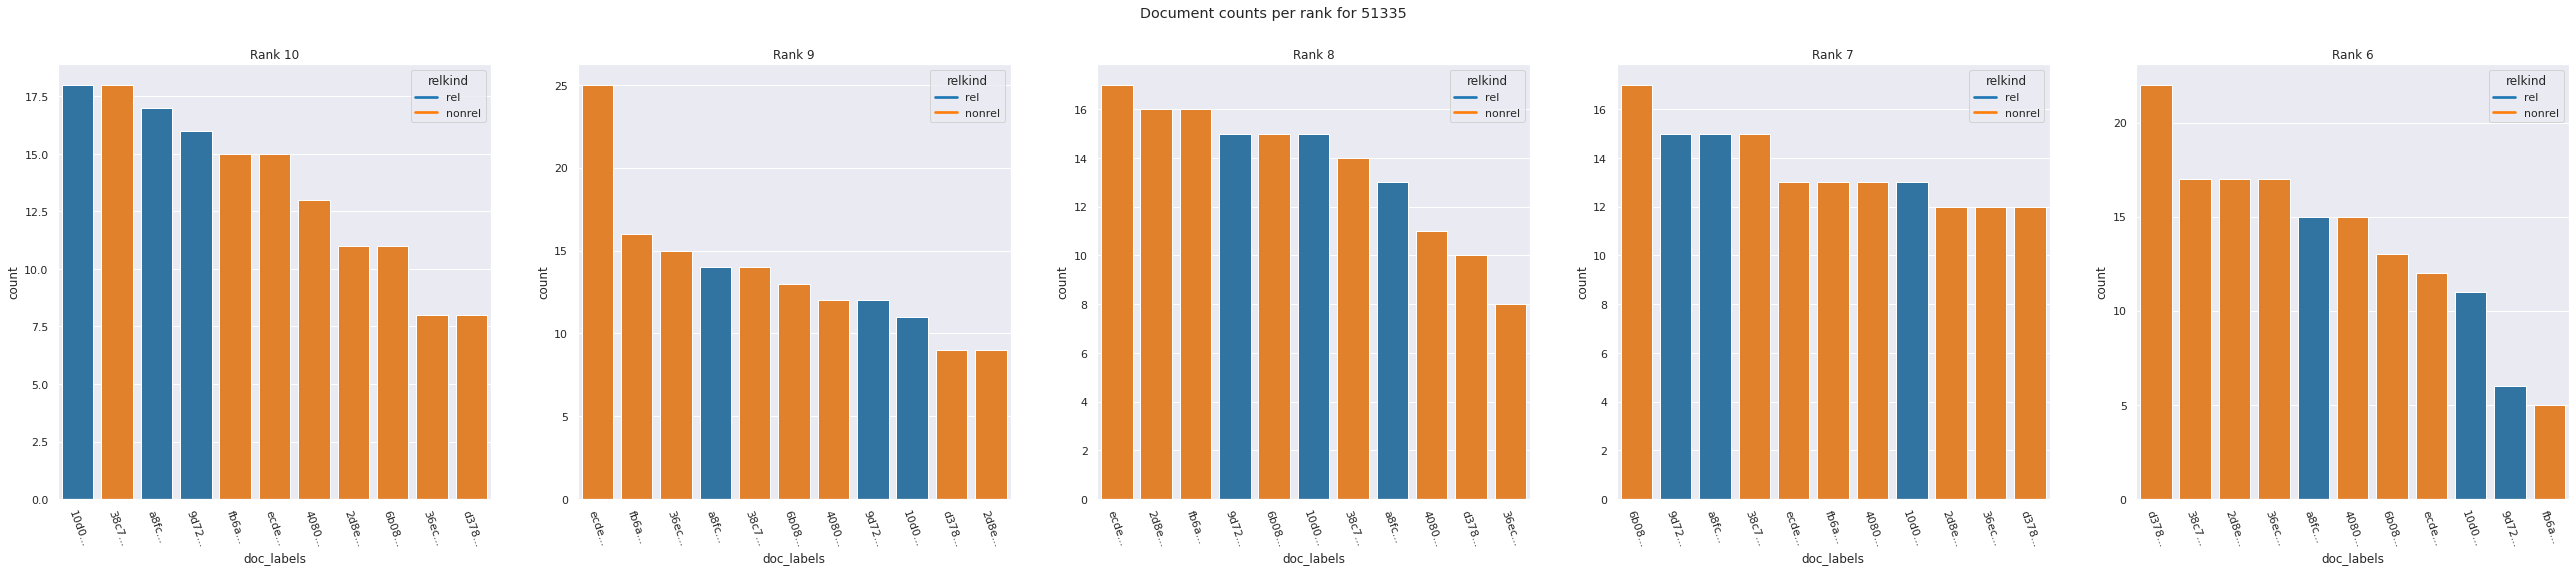

In [166]:
for q in topqueries.index.unique():
    rel,nonrel = count_relgrades_qid(q,reldf)
    plot_doc_occurrence_per_rank_for_qid(q,rdf,reldf,k=5,rev=True)

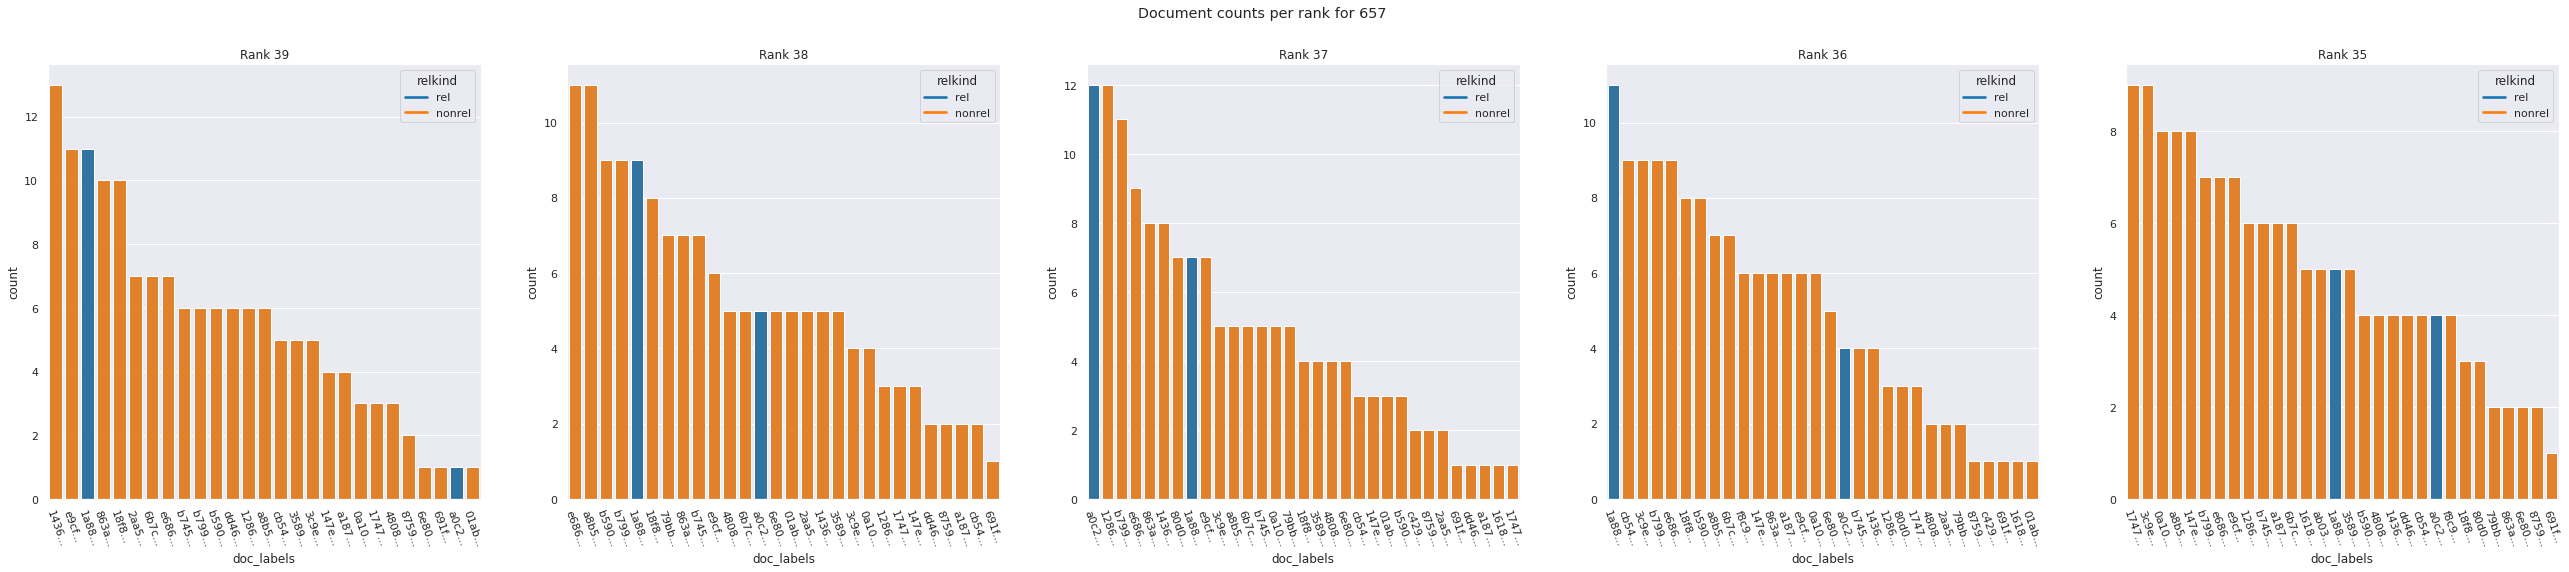

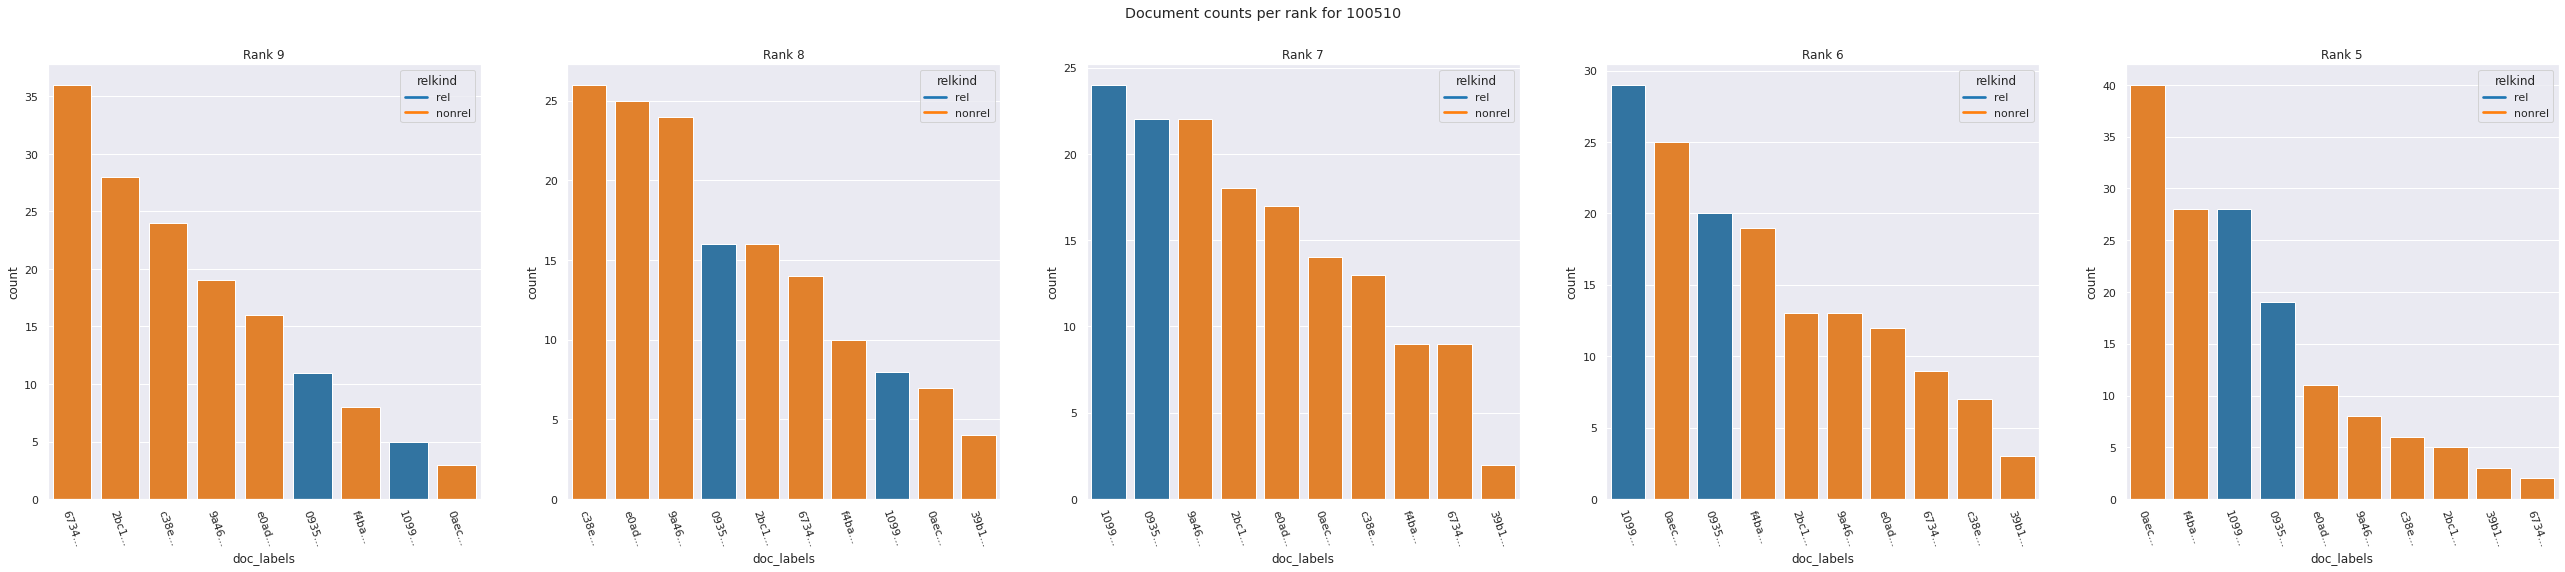

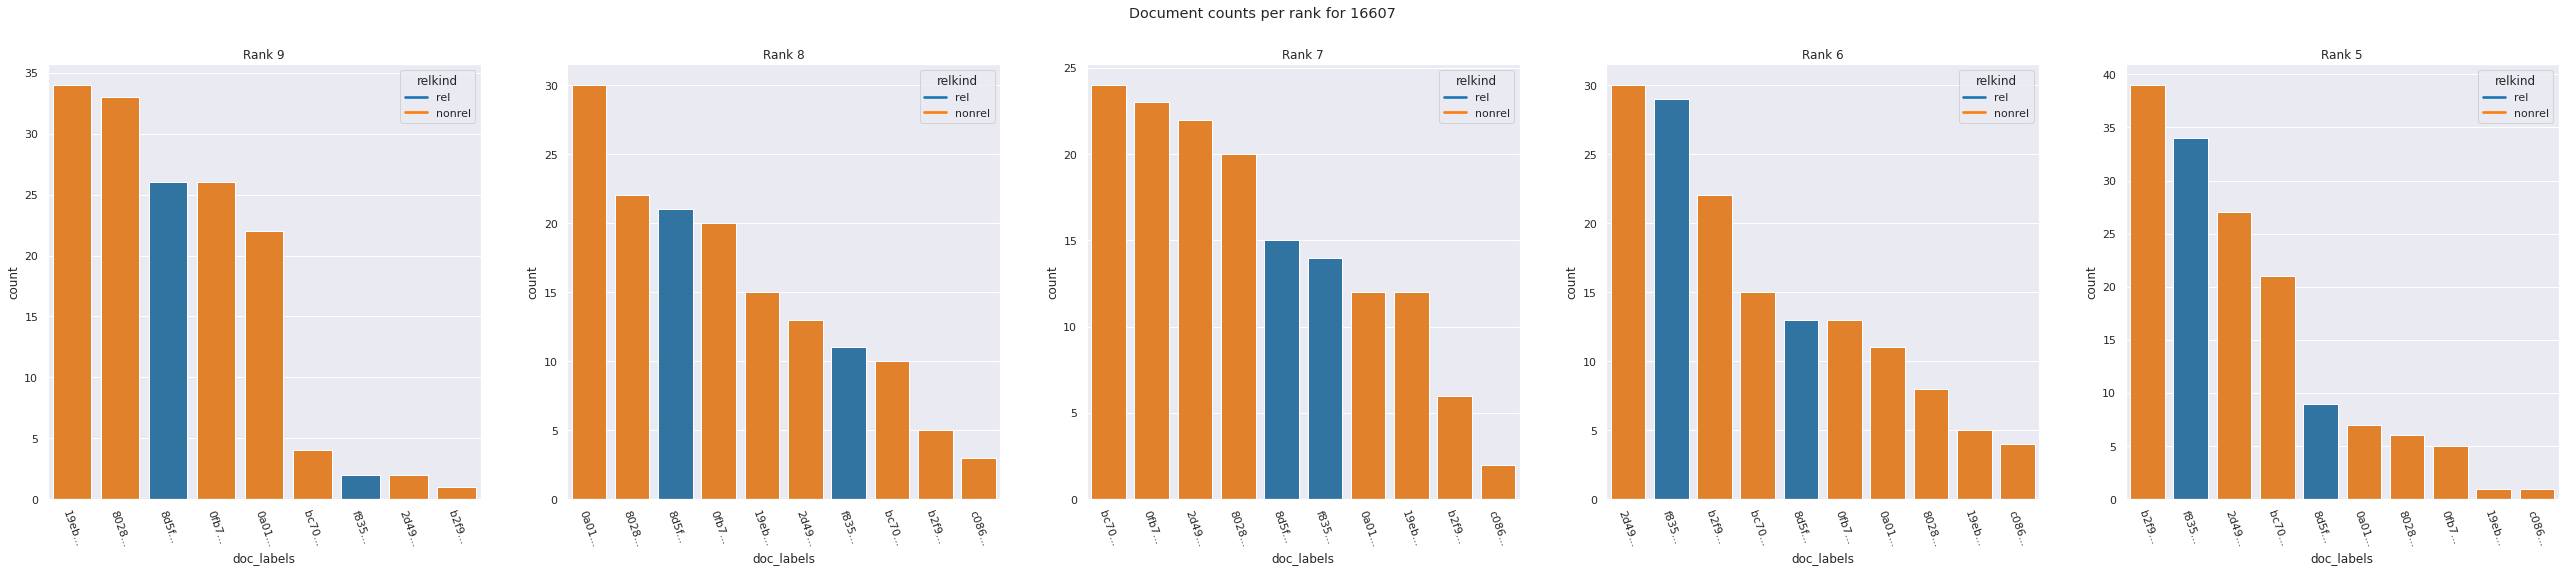

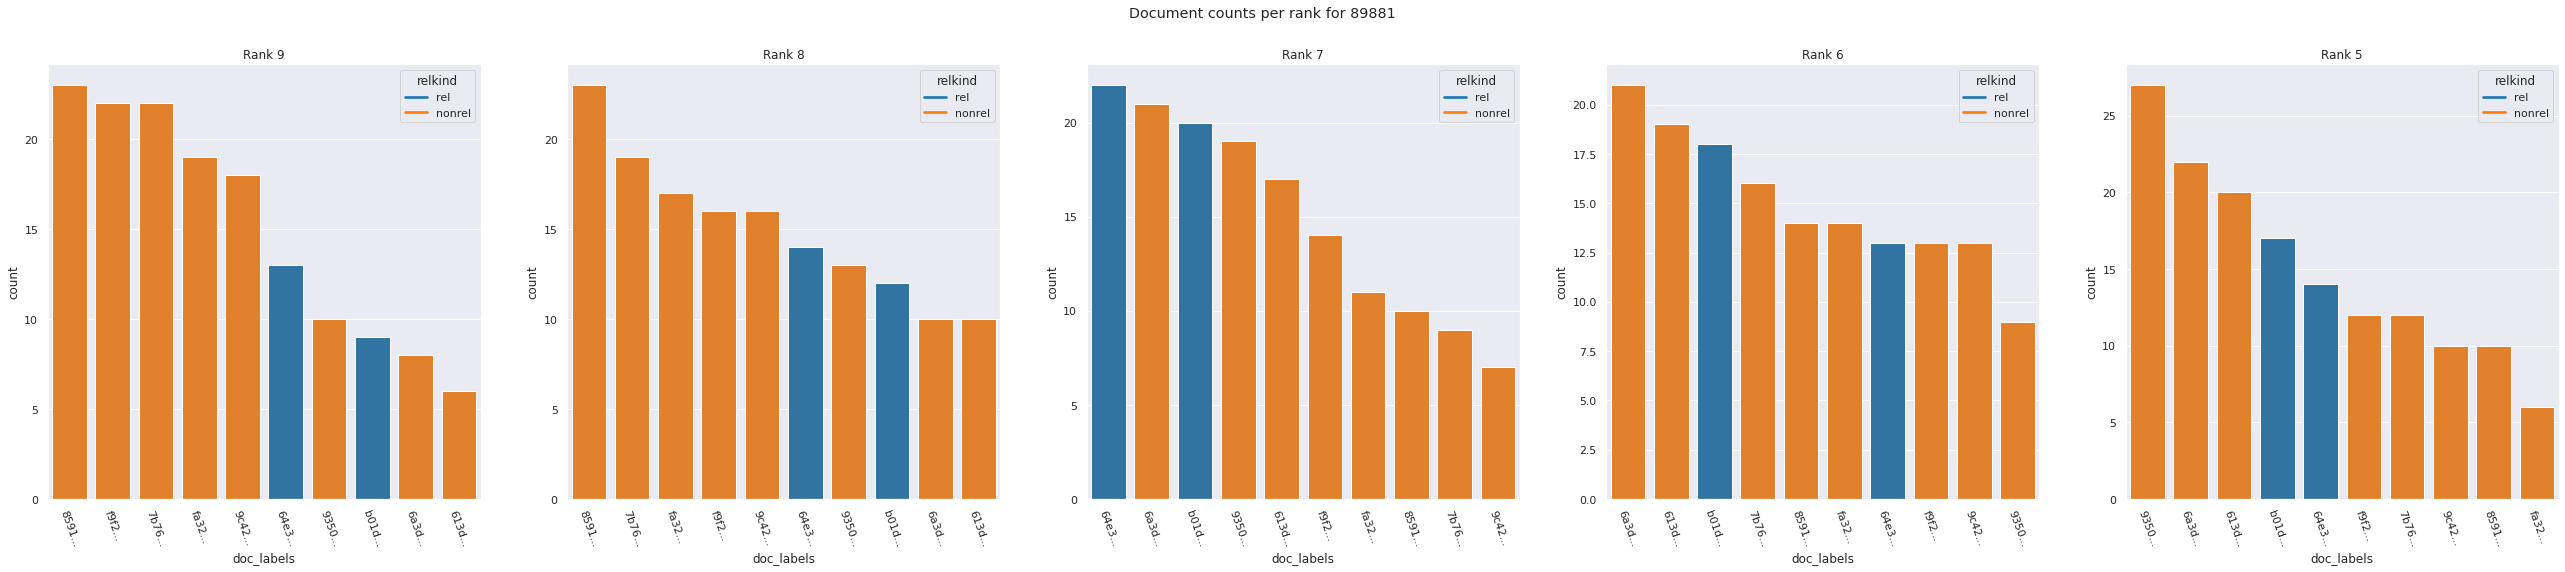

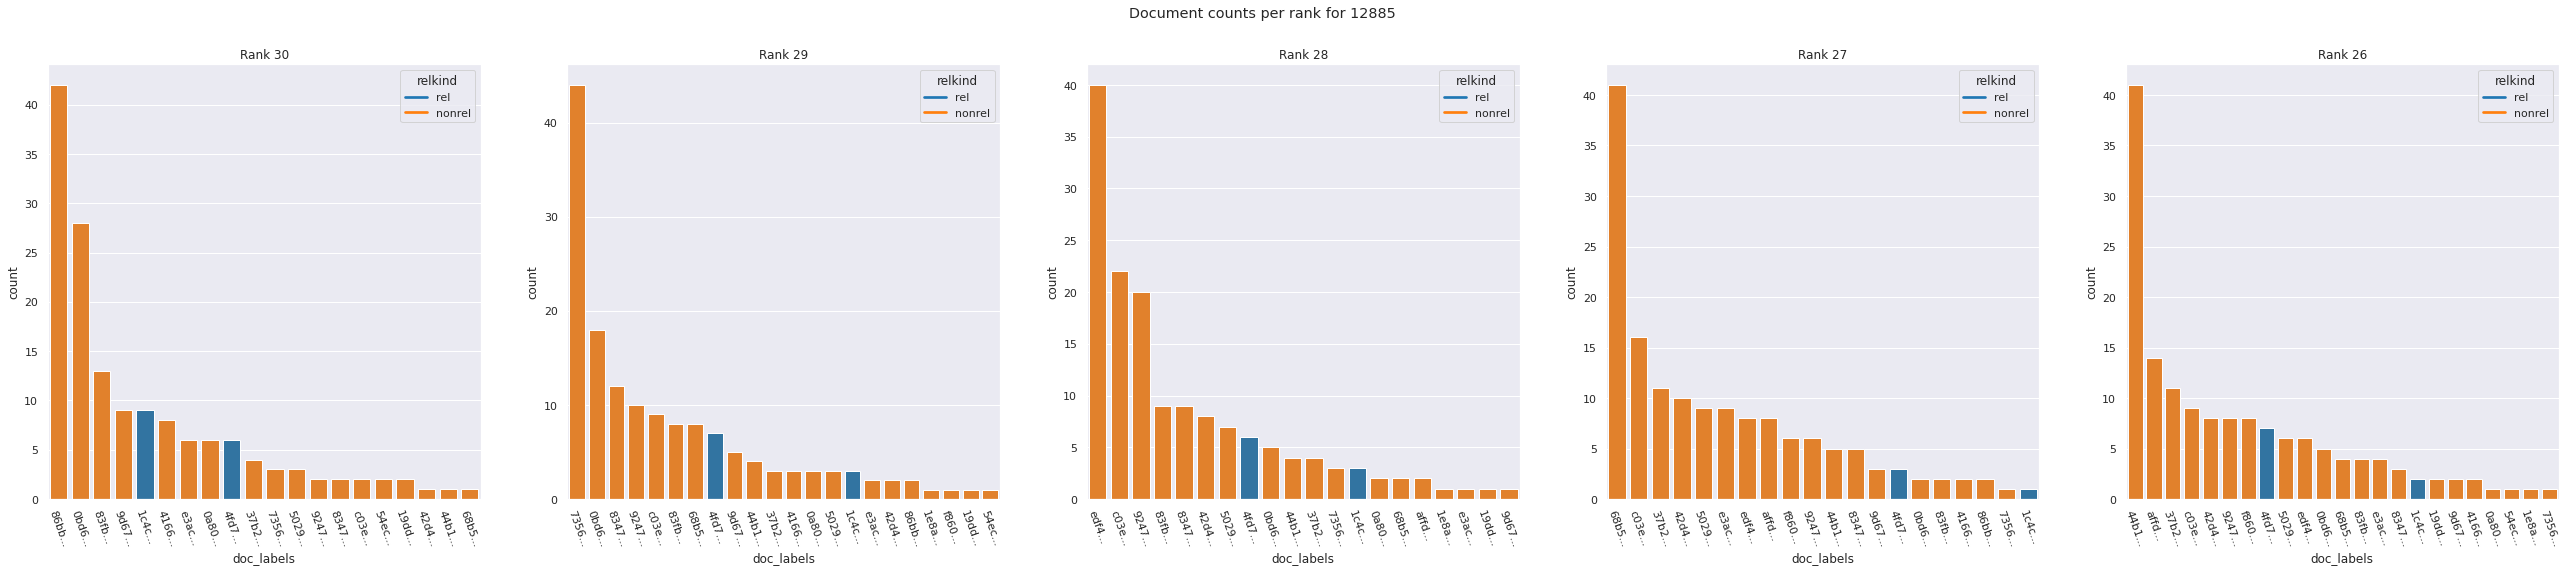

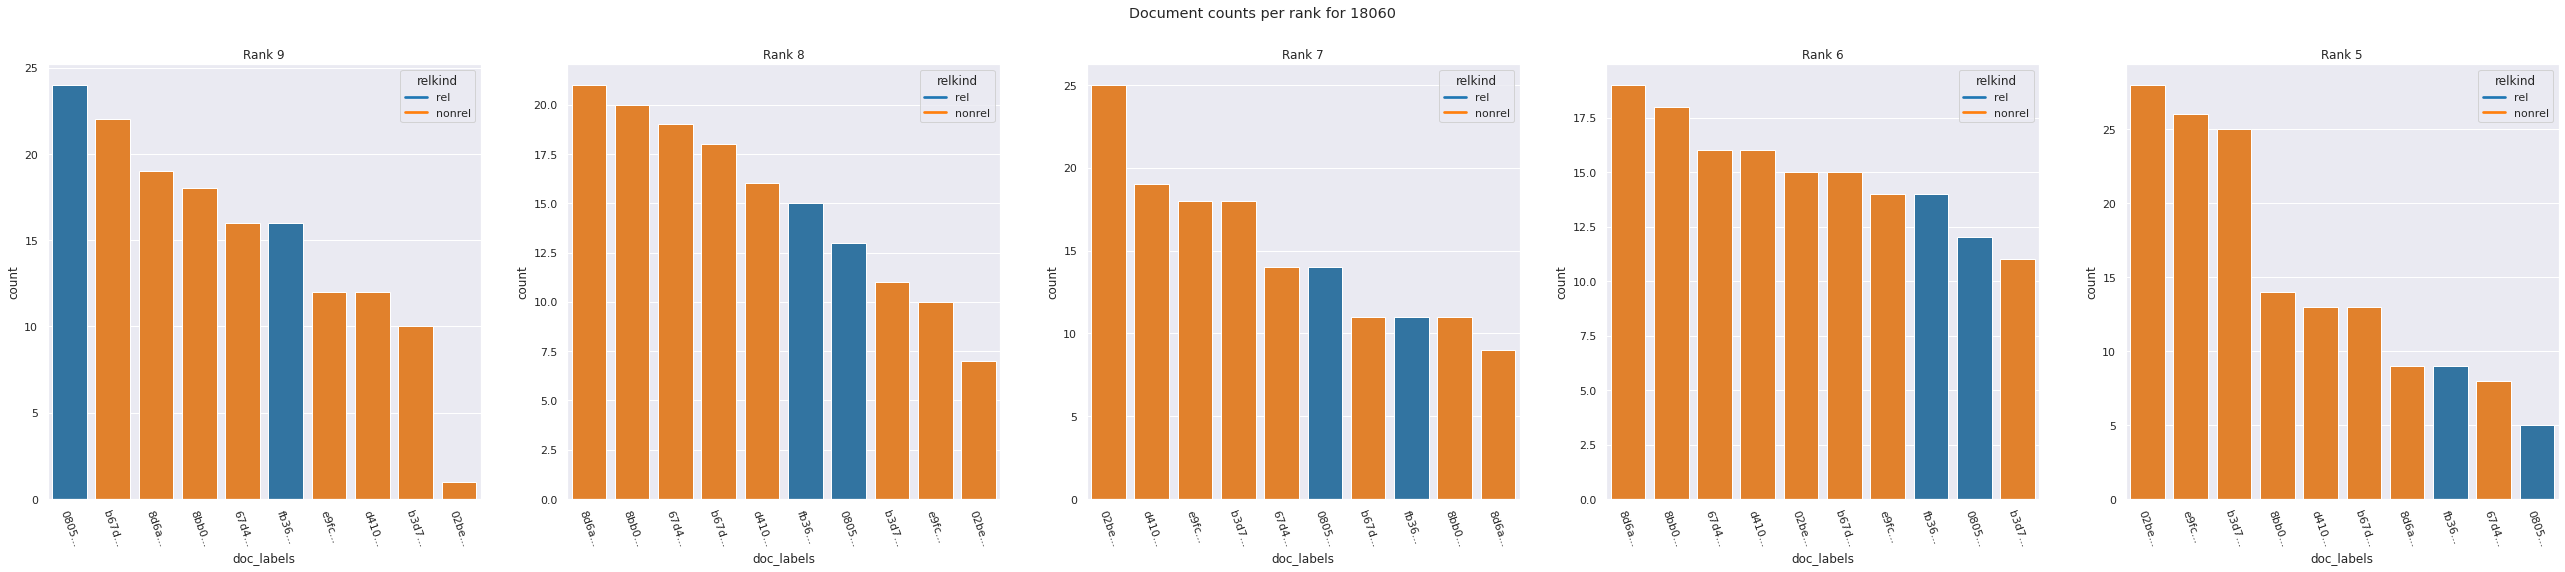

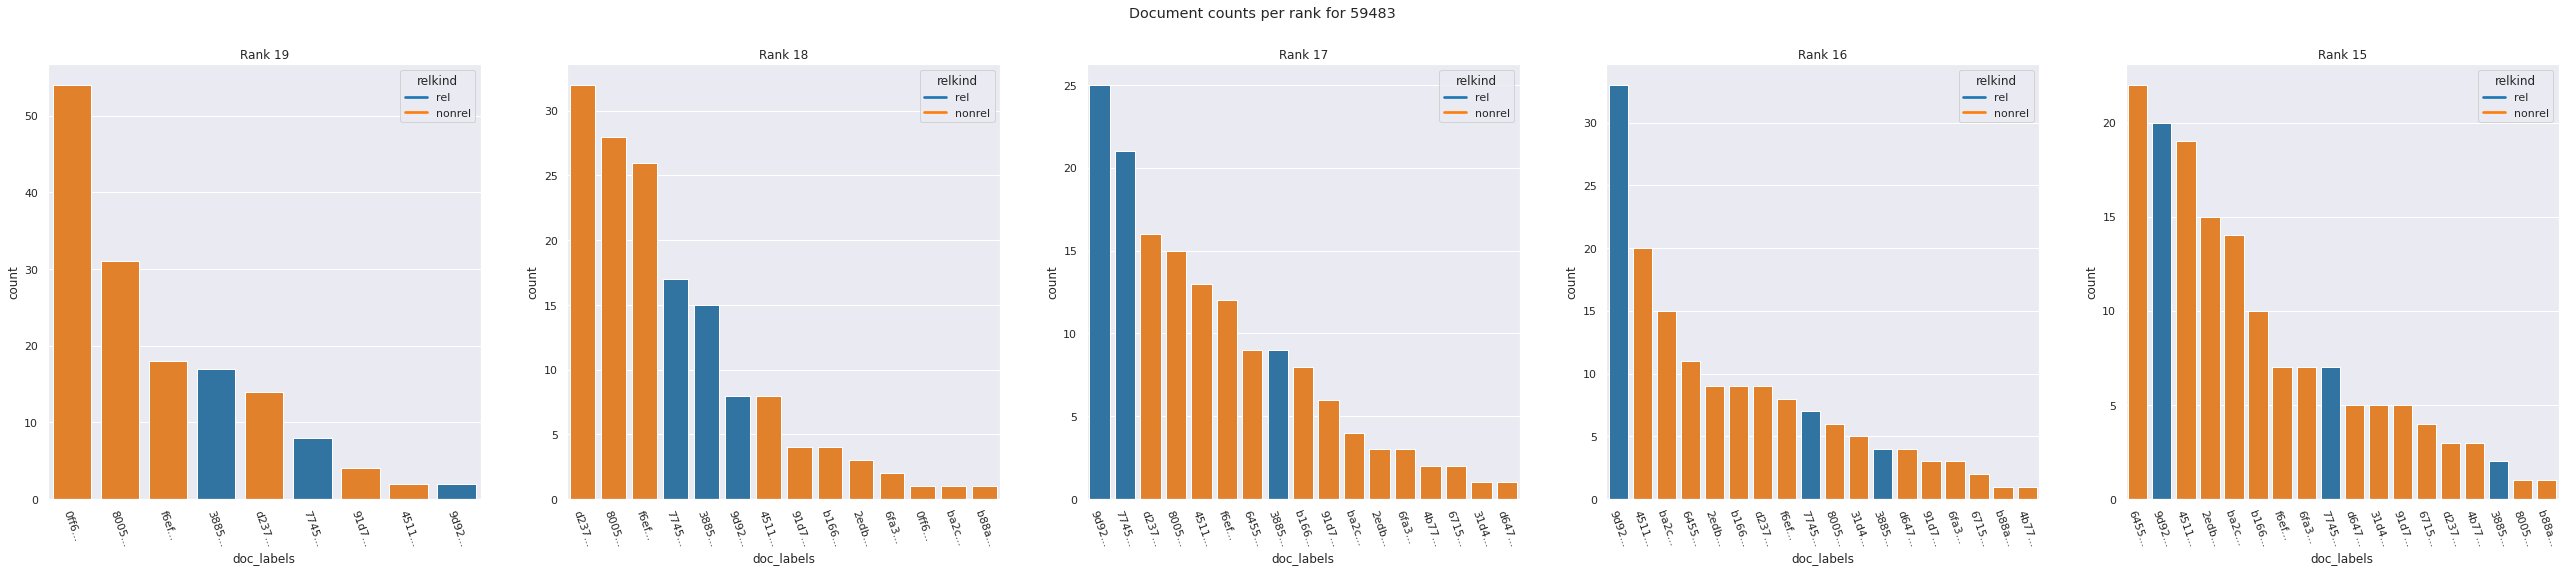

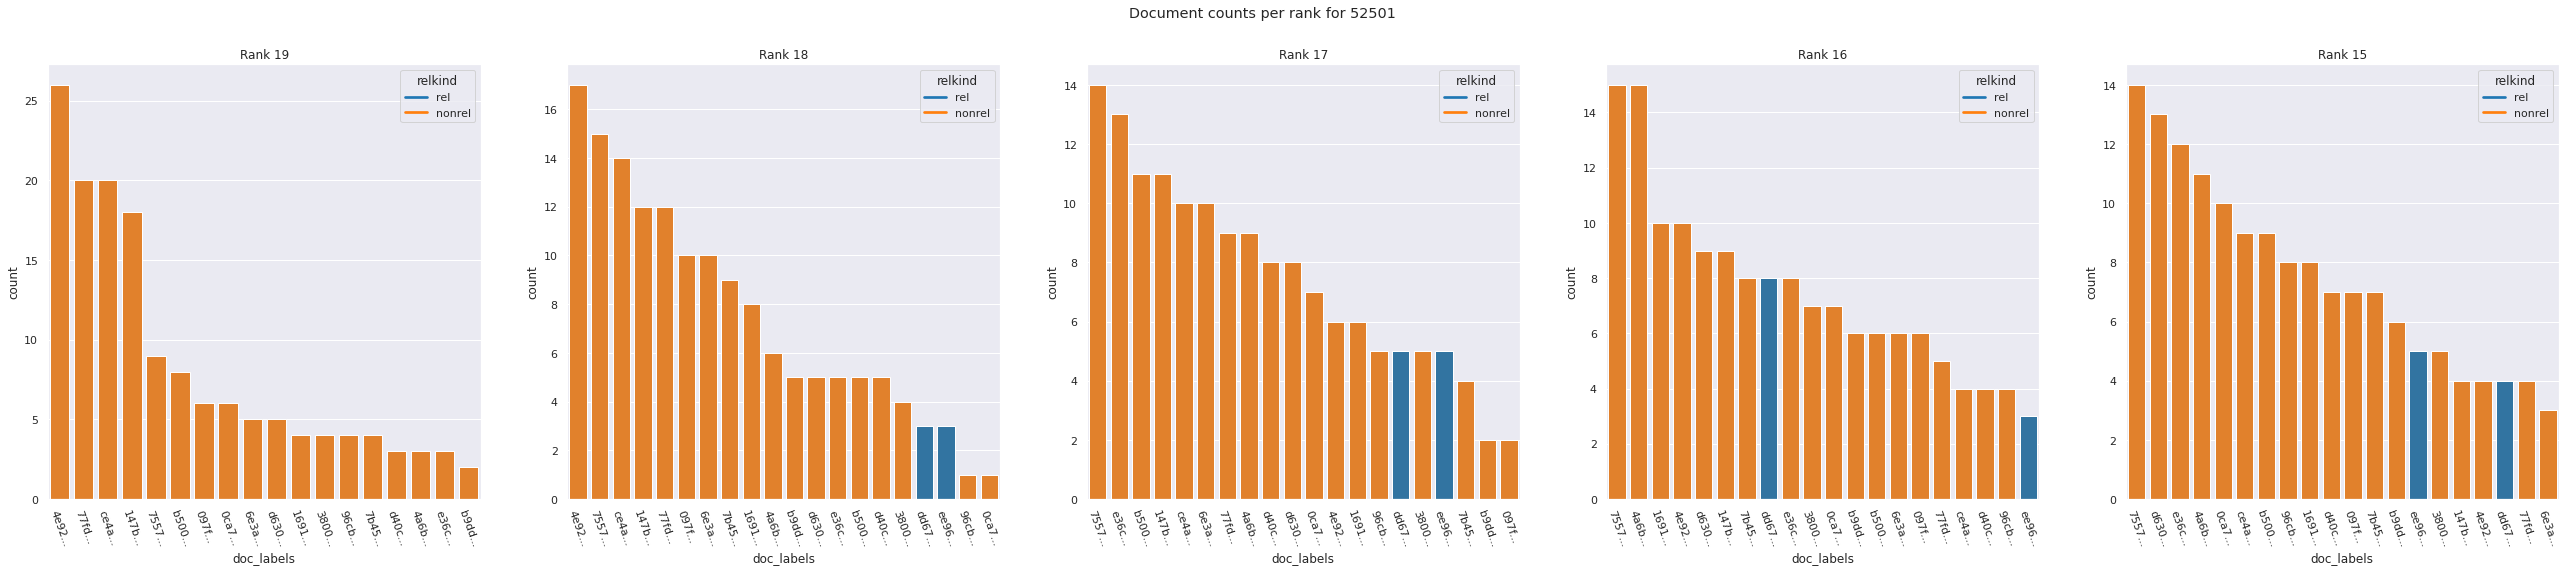

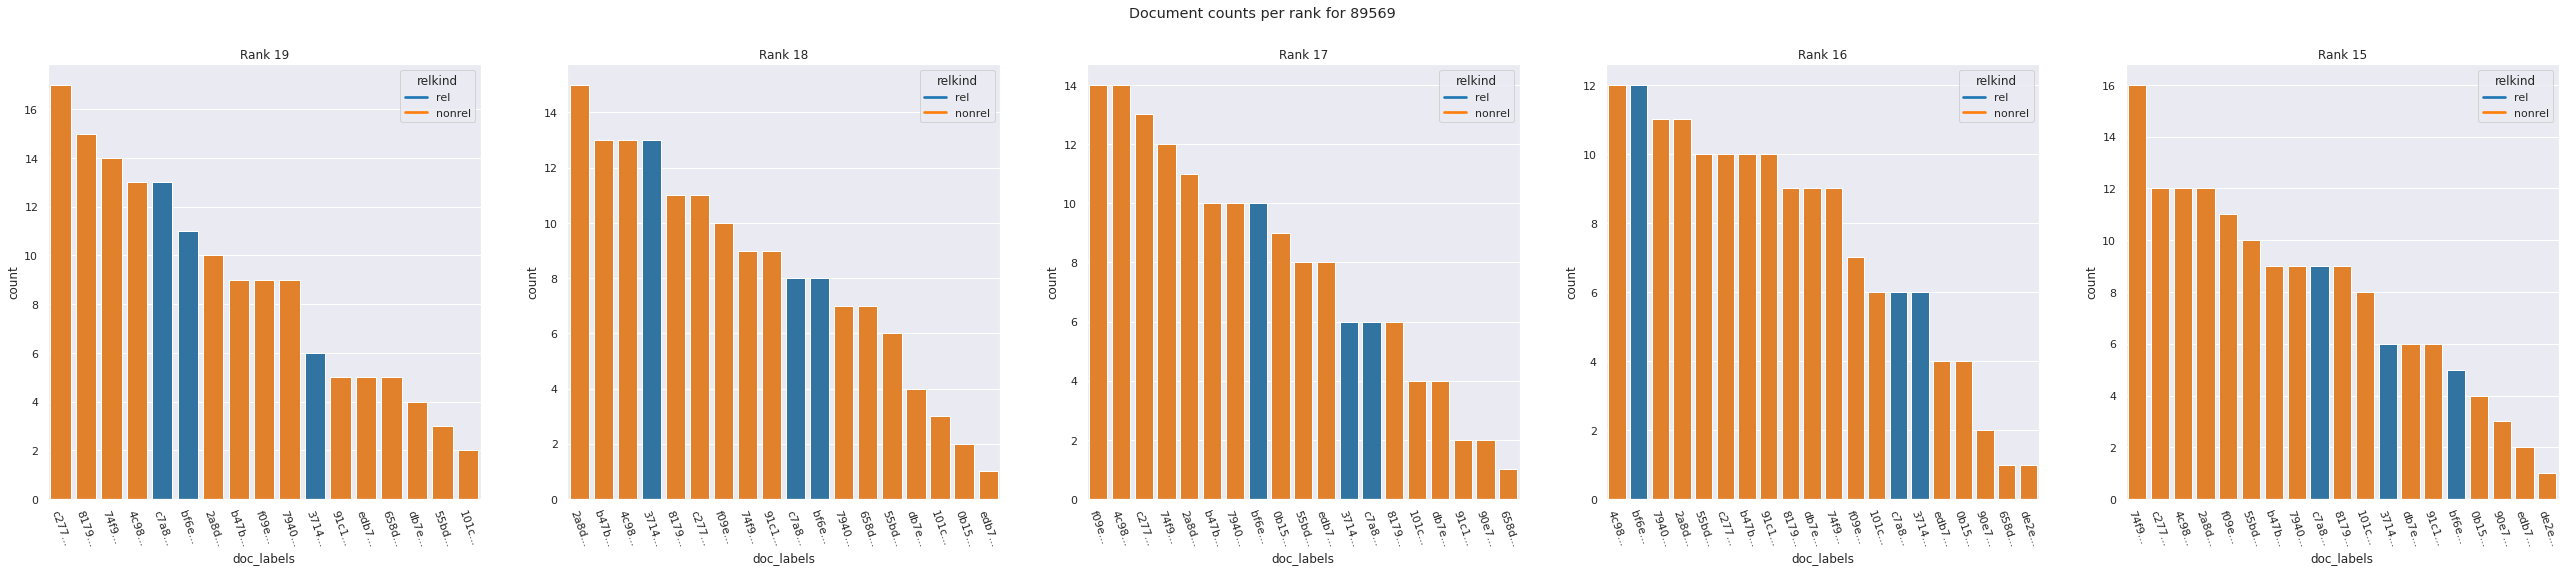

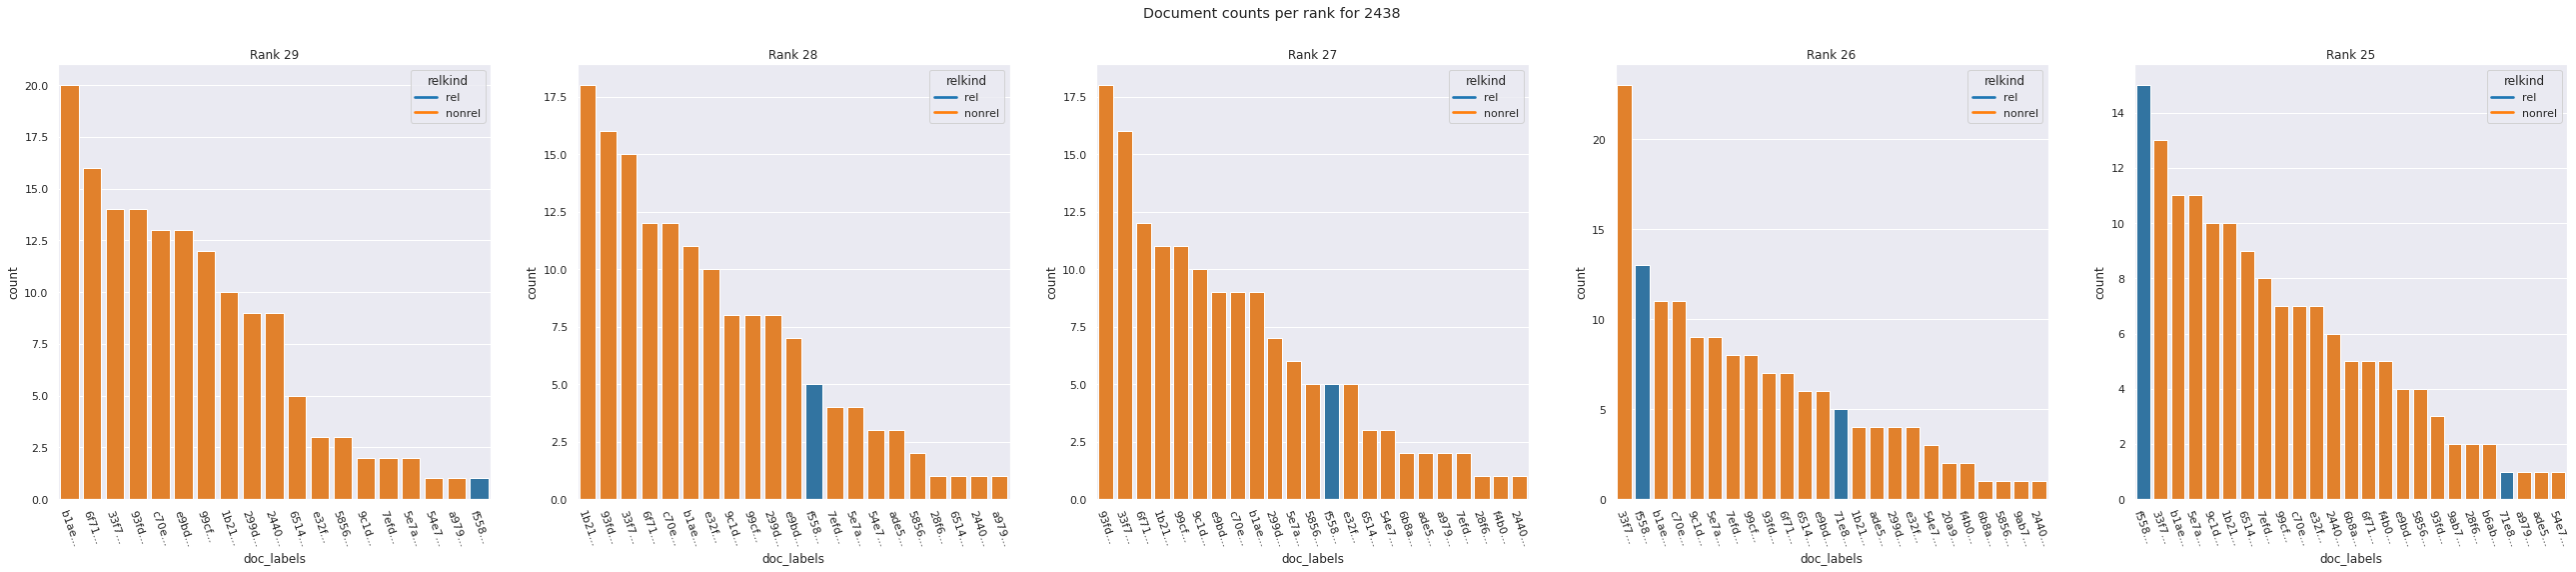

In [167]:
for q in bottomqueries.index.unique():
    rel,nonrel = count_relgrades_qid(q,reldf)
    plot_doc_occurrence_per_rank_for_qid(q,rdf,reldf,k=5,rev=True)

##### Bottom positions

The bottom positions look more regular. They diminish more gently, without big spikes. They also look pretty similar between the top and bottom queries.

An exception is top query 91643, which has a larger spike of an irrelevant document in the bottom rank.
An exception is bottom query 12885, which has a larger spike of an irrelevant document in the bottom rank.

In general, what happens in the bottom positions is less impactful than what happens at the top positions, because of the way DGEE is computed. However, for short rankings the bottom positions may still have a large influence.


### Document position (top/bottom) counts

We plot how often each document occurs in a top or bottom position. In an ideal scenario, there is a uniform distribution across relevant docs for top positions and non-relevant docs in bottom positions.

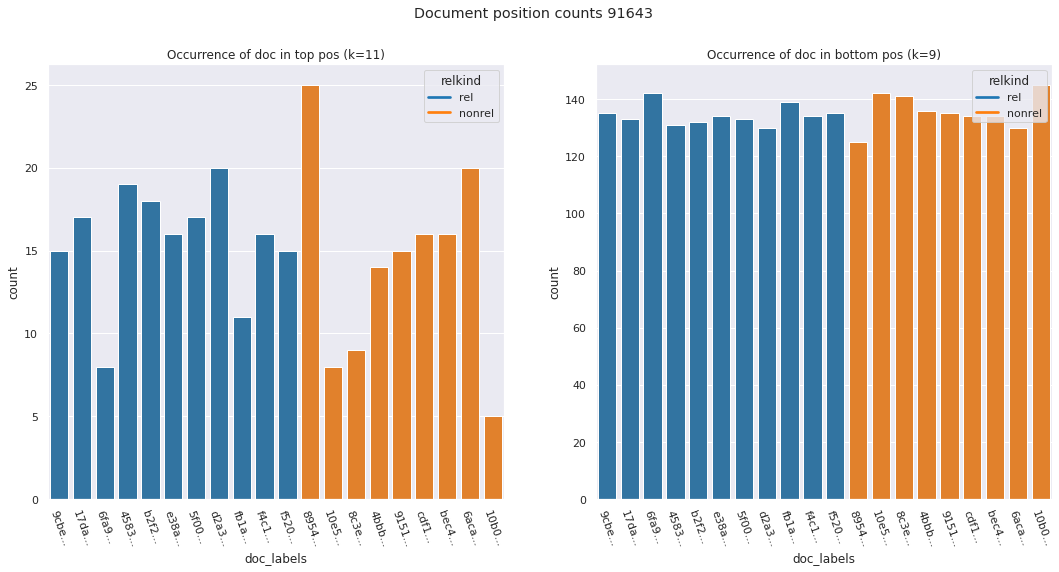

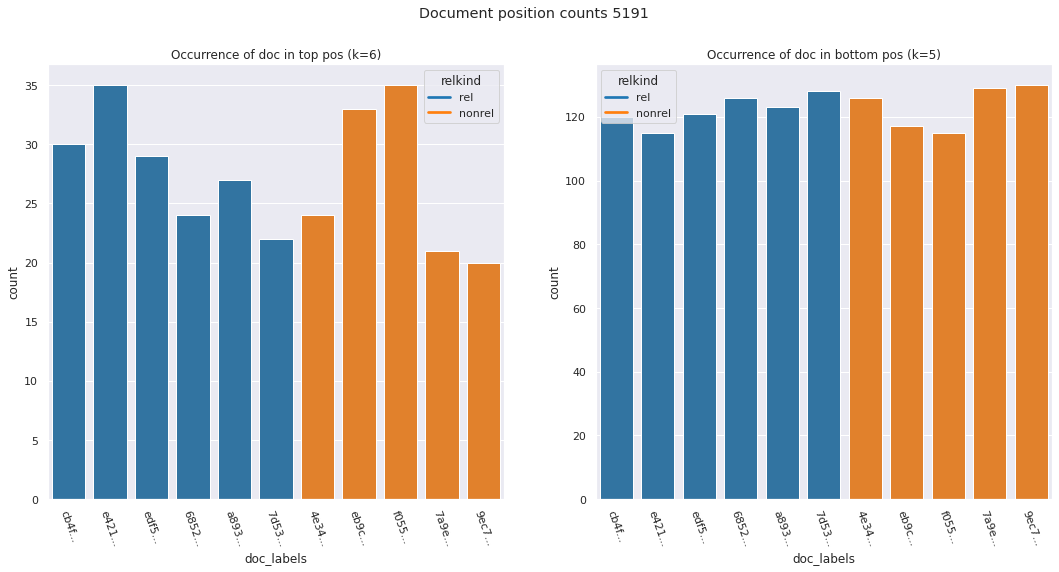

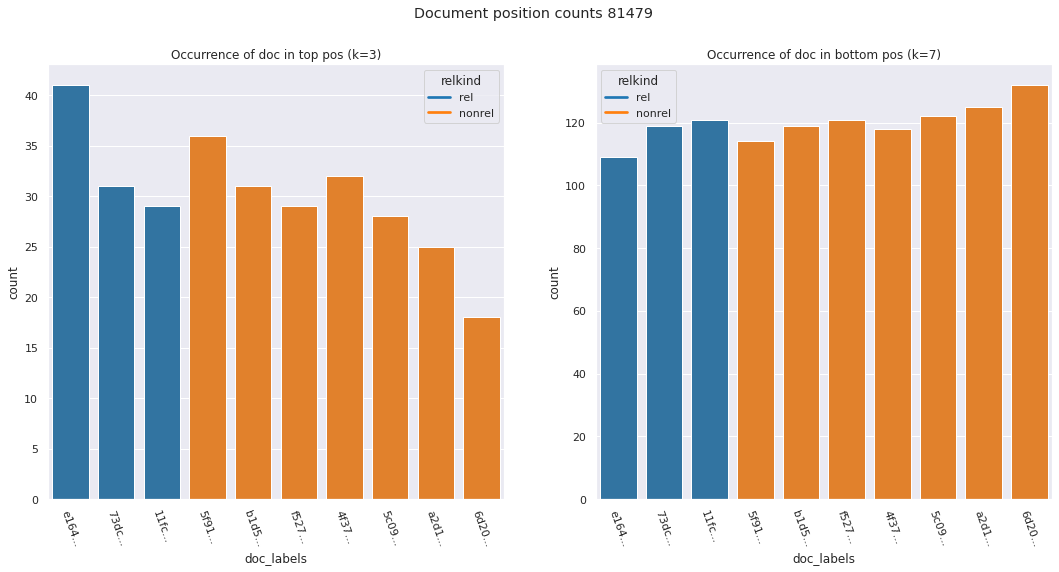

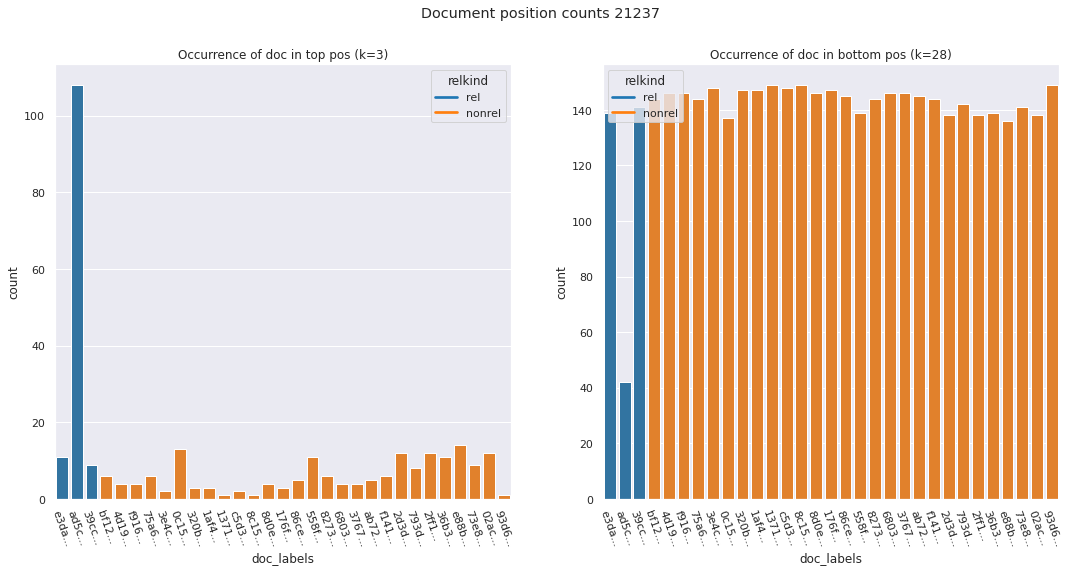

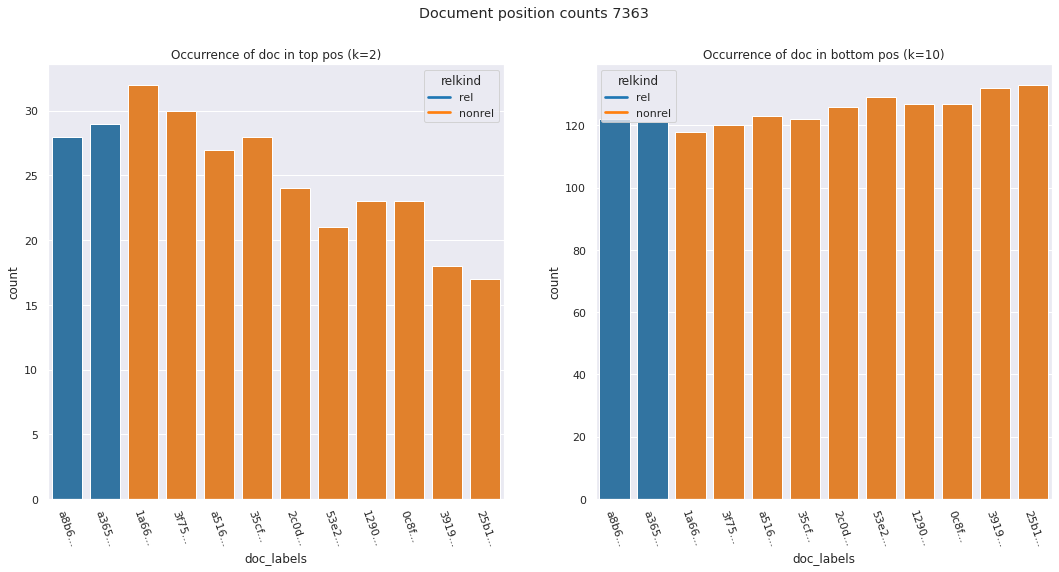

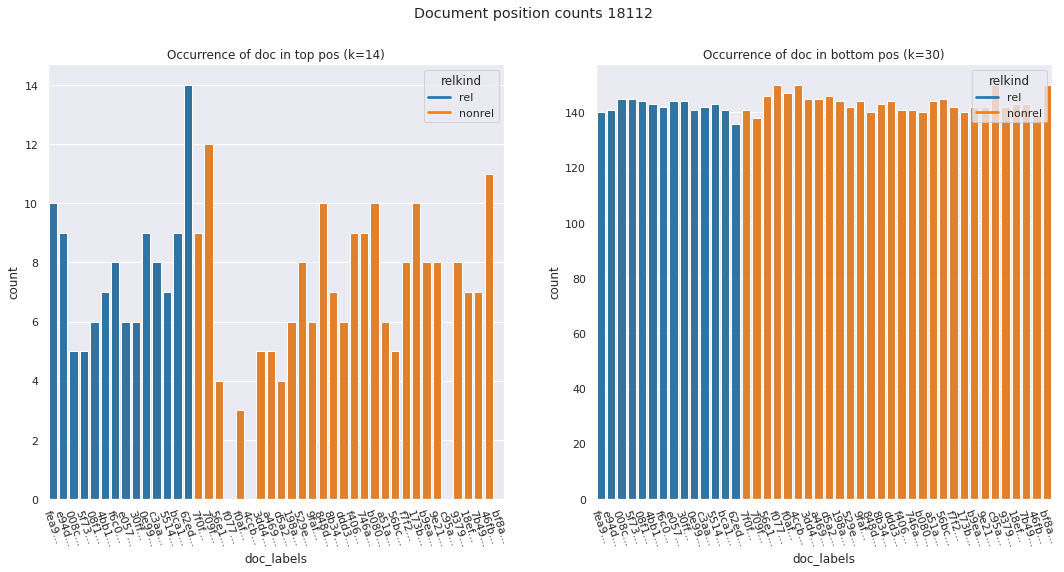

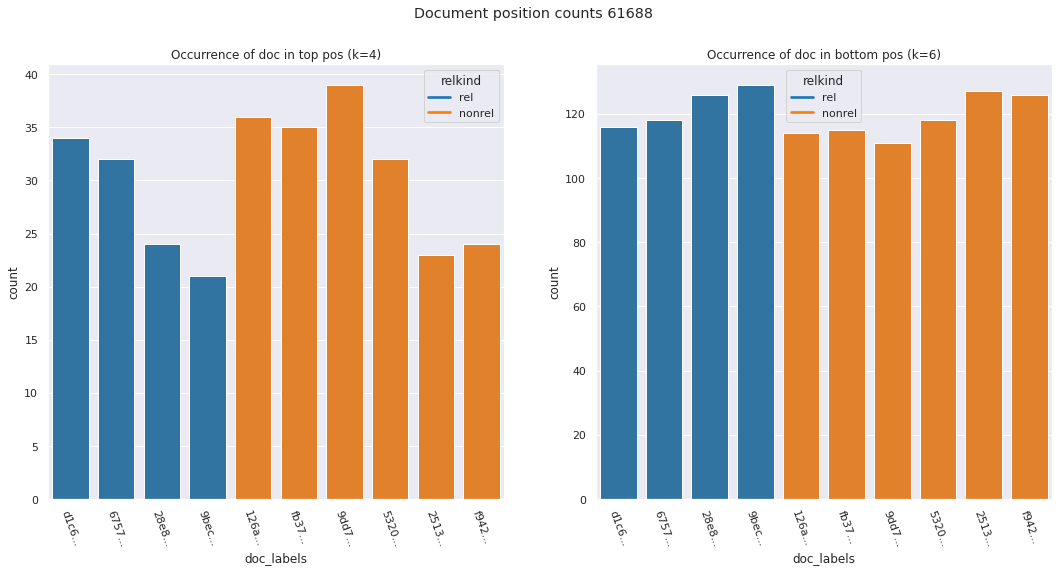

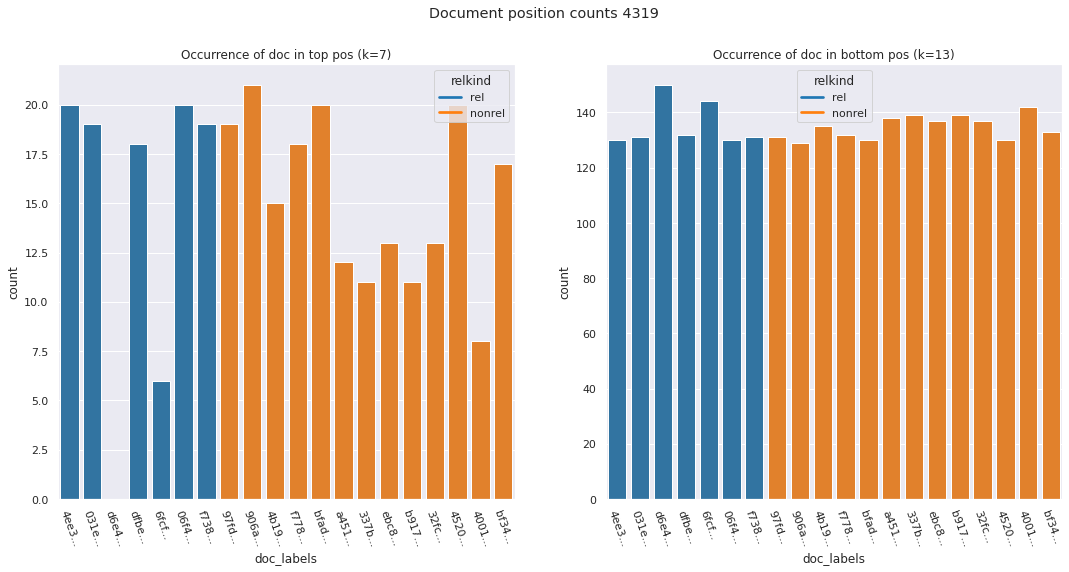

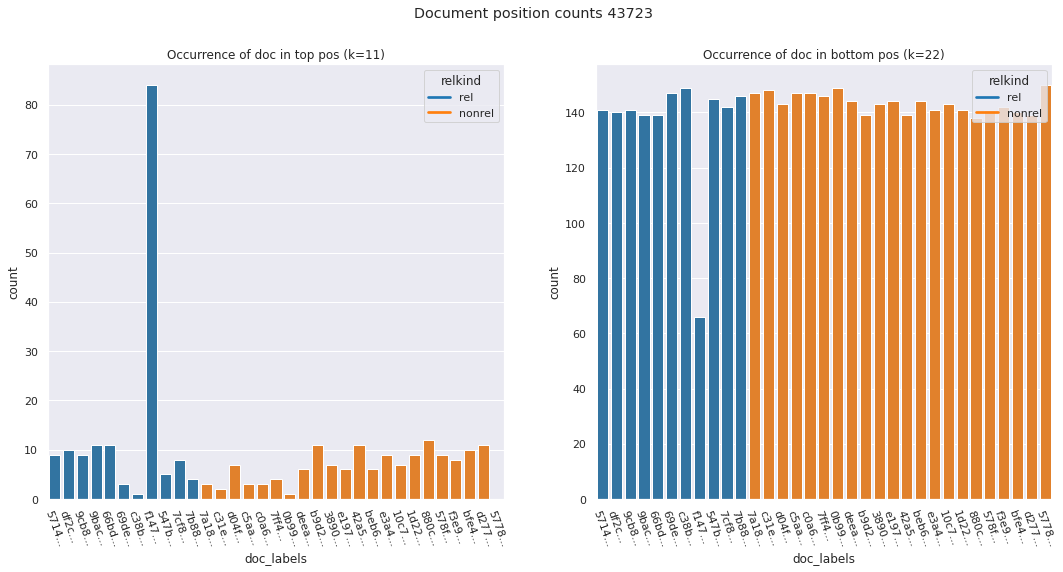

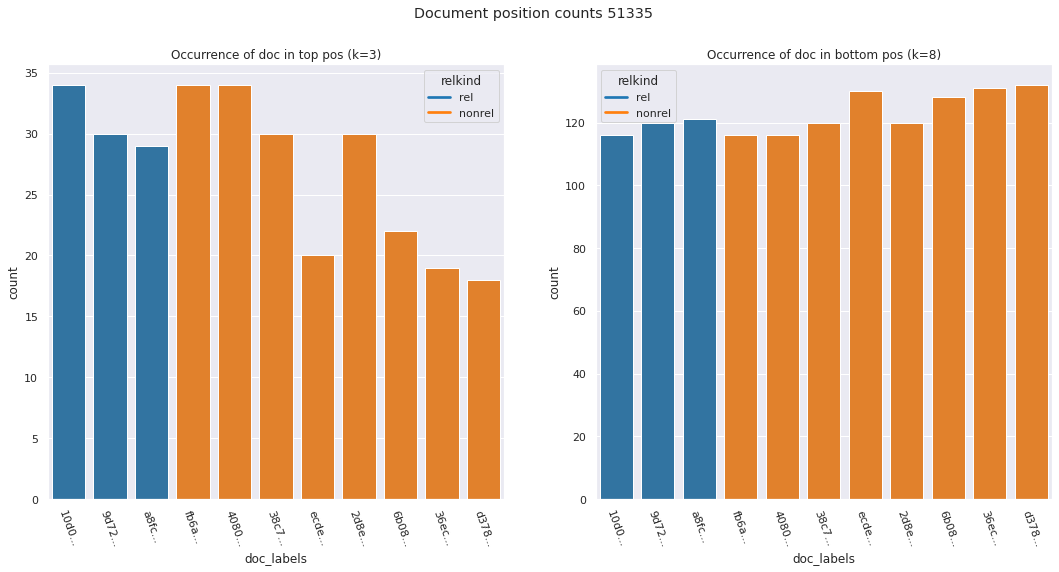

In [188]:
for q in topqueries.index.unique():
    plot_doc_pos_count_for_qid(q,rdf,reldf)

##### Top queries
Some things catch the eye:
- In general, there is a reasonably even distribution across the relevant documents in top positions and non-relevant documents in bottom positions.
- However, there are a couple of queries that have a spike for a relevant document in a top position.
    - Authorless?
- There is also qid=4319 for which the top documents are more inconsistent, and one of them is even missing.
    - Why does this query still perform well? Why is that one document missing?
- There aren't necessarily fewer non-relevant documents in top positions, but they don't spike out.
- The distribution in bottom positions is reasonably even between relevant/ non-relevant documents, bar some dips that correspond to spikes in the top positions.
    

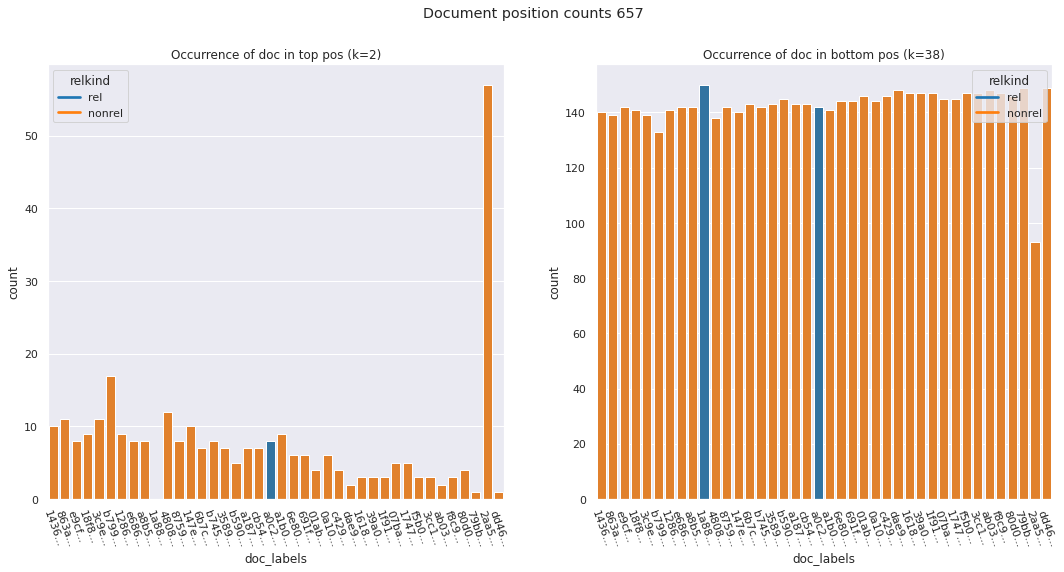

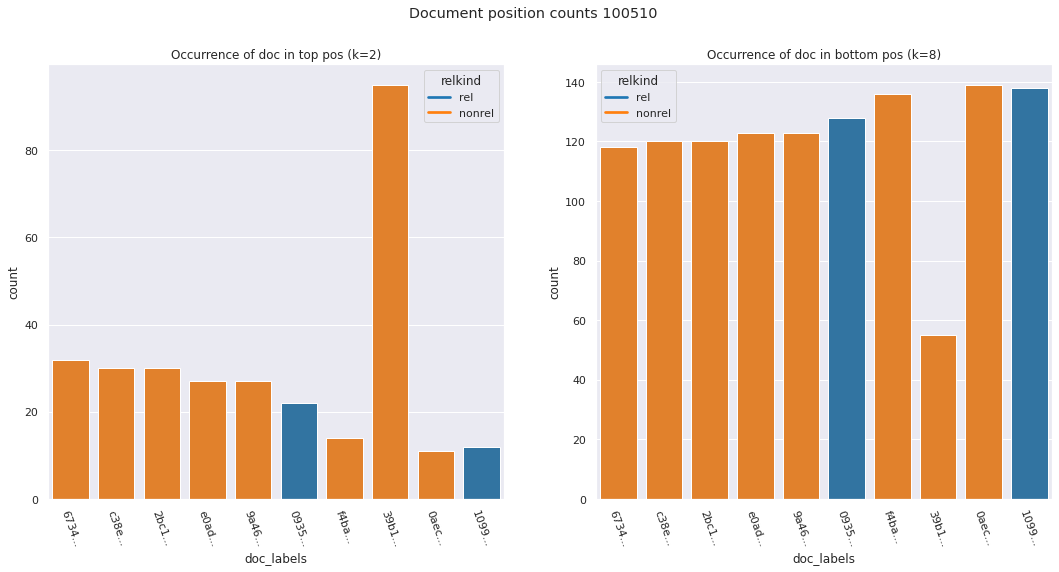

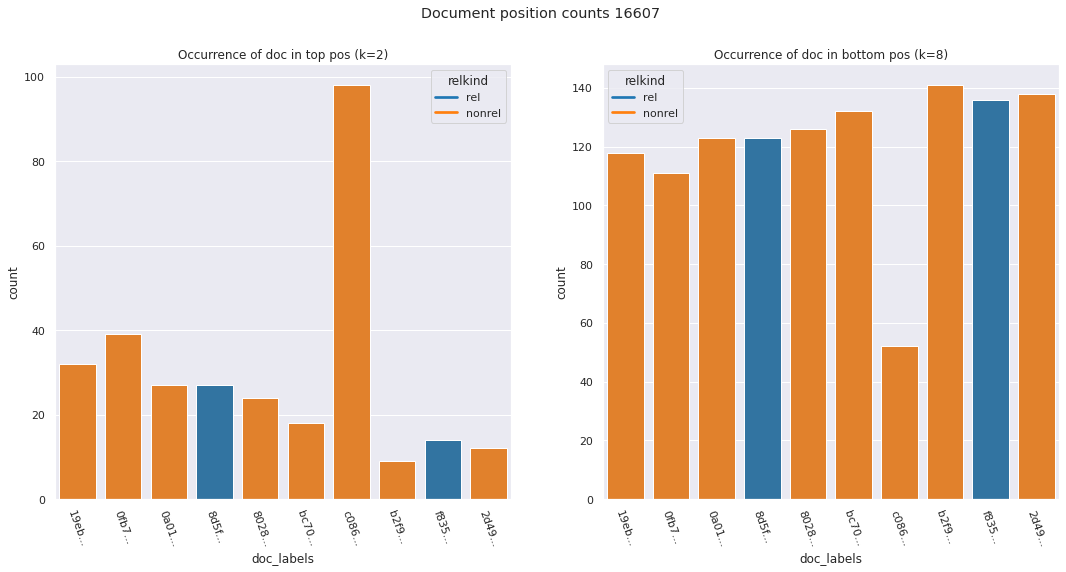

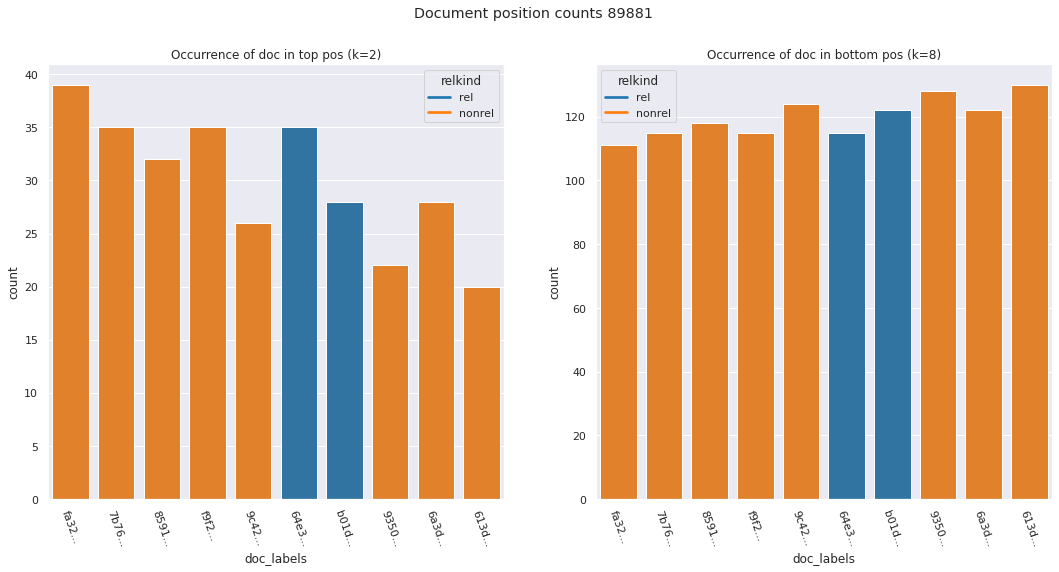

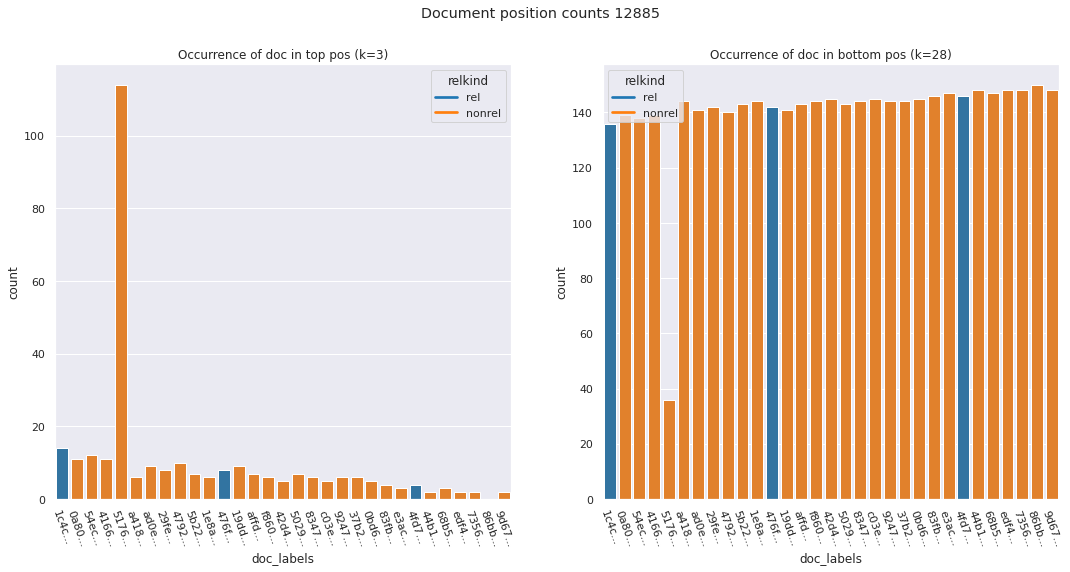

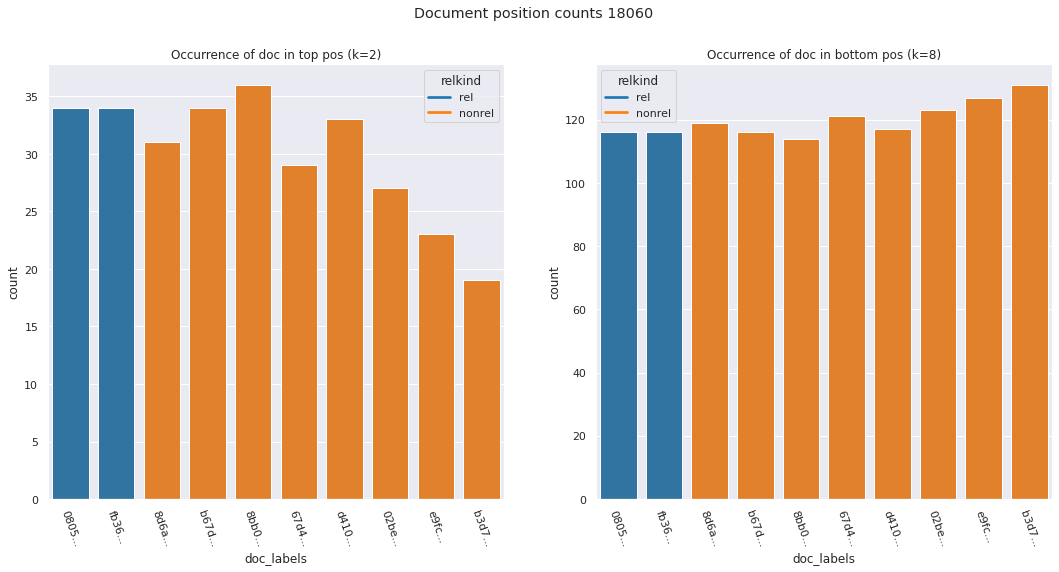

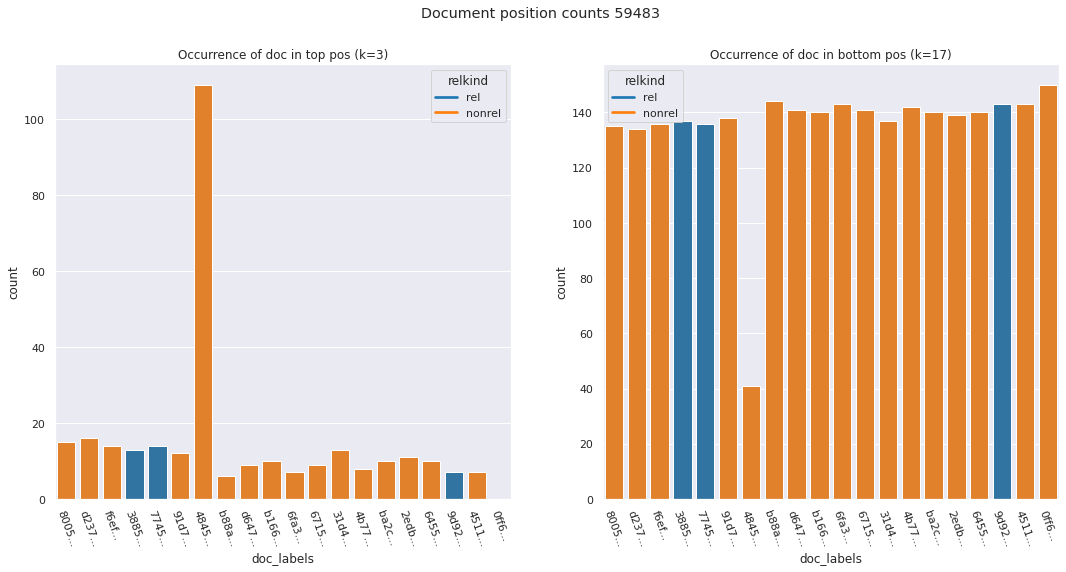

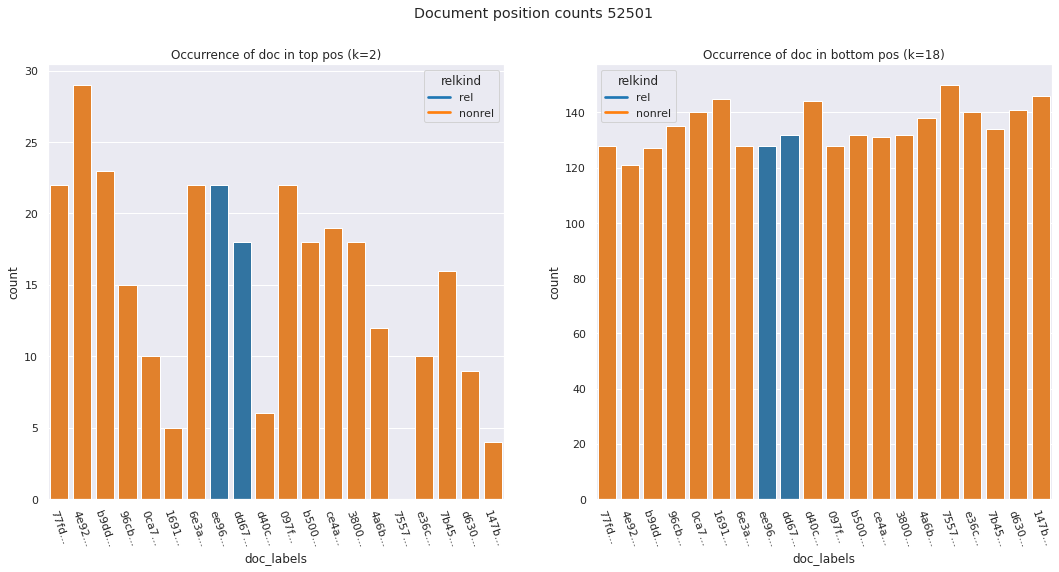

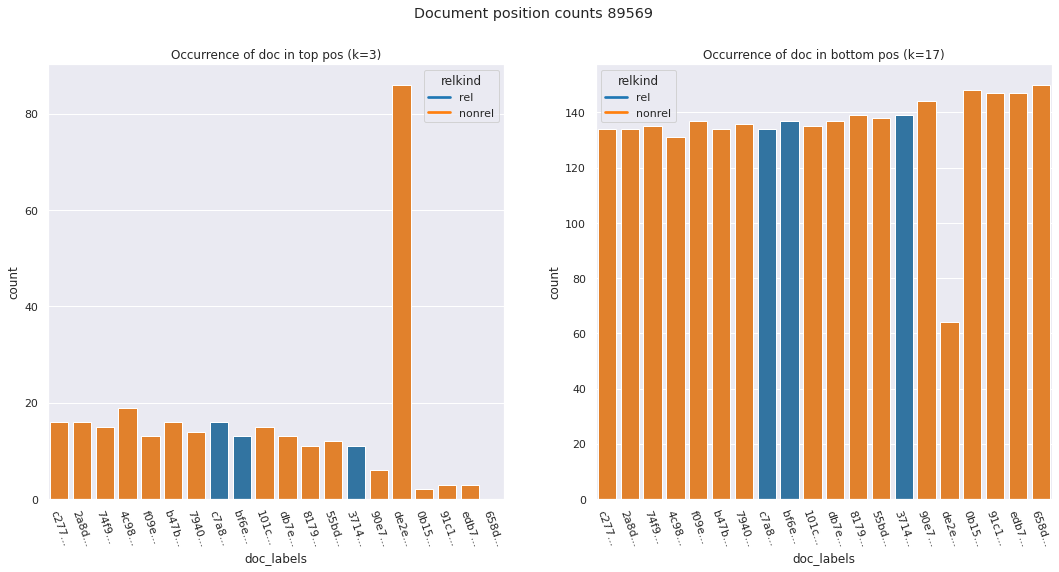

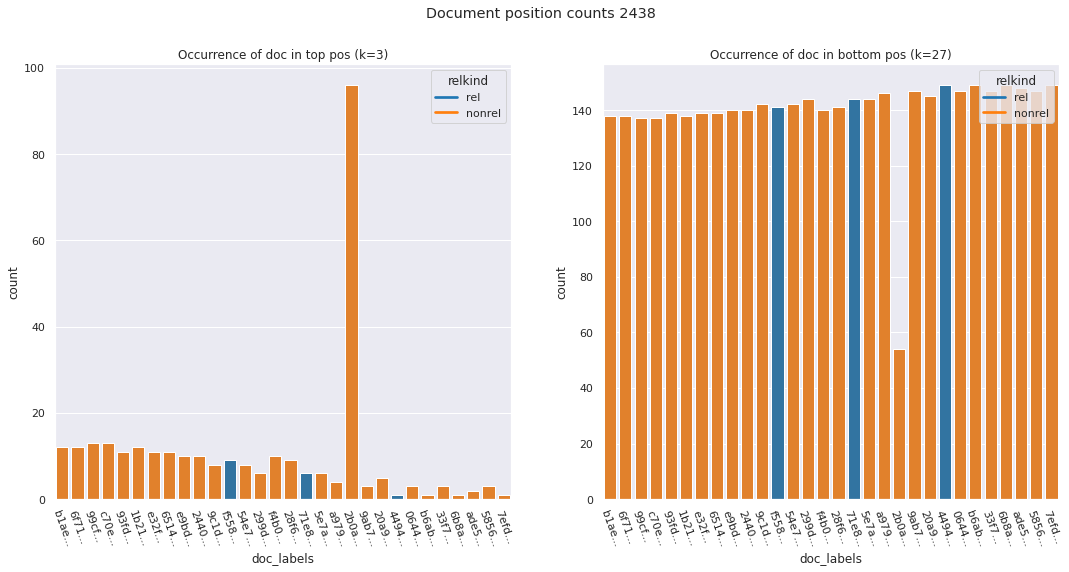

In [175]:
for q in bottomqueries.index.unique():
    plot_doc_pos_count_for_qid(q,rdf,reldf)

/home/pilmus/thesis/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()
/home/pilmus/thesis/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()
/home/pilmus/thesis/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()
/home/pilmus/thesis/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()
/home/pilmus/thesis/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()
/home/pilmus/thesis/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:16:

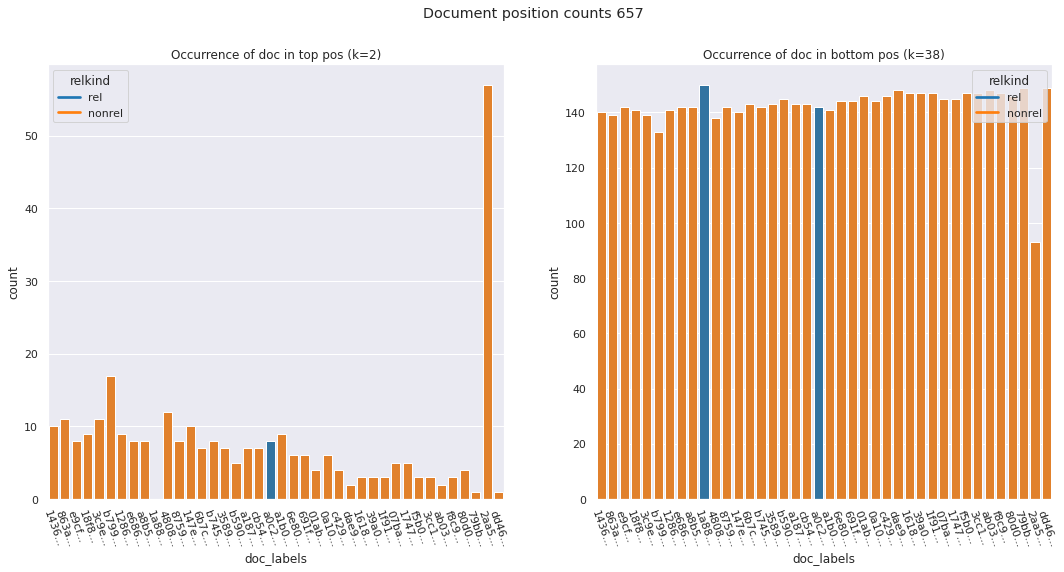

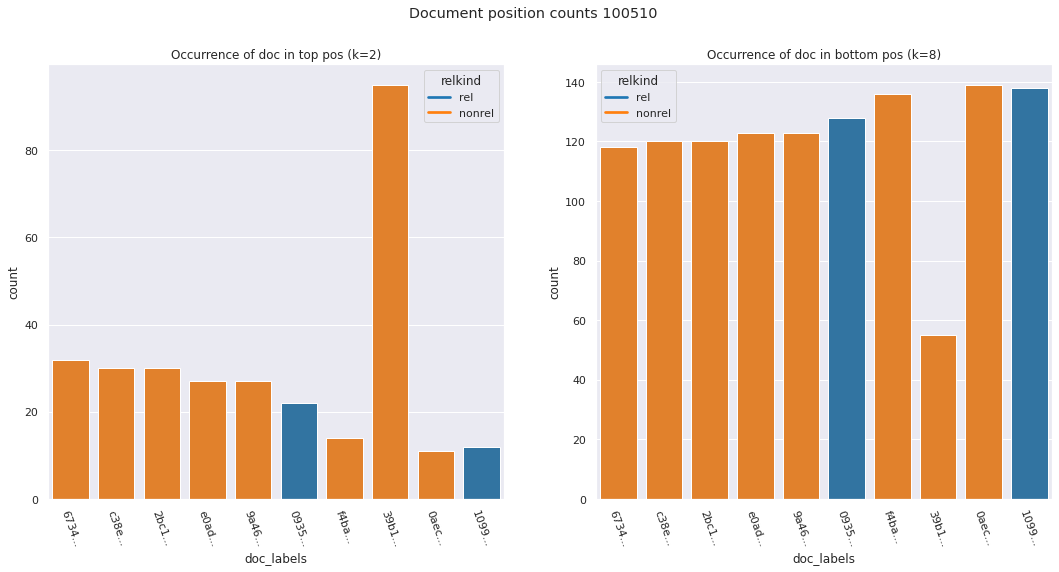

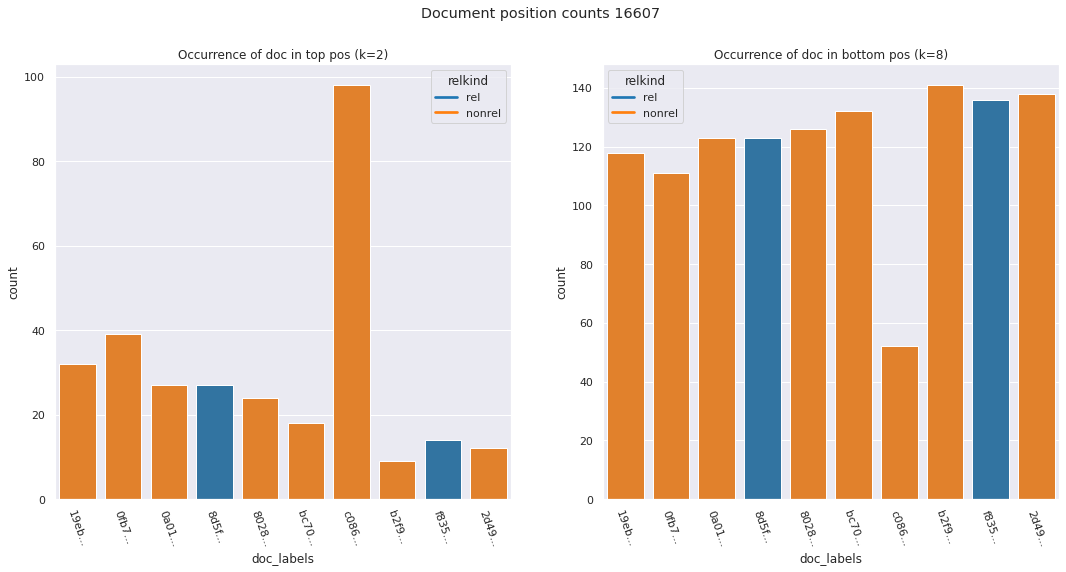

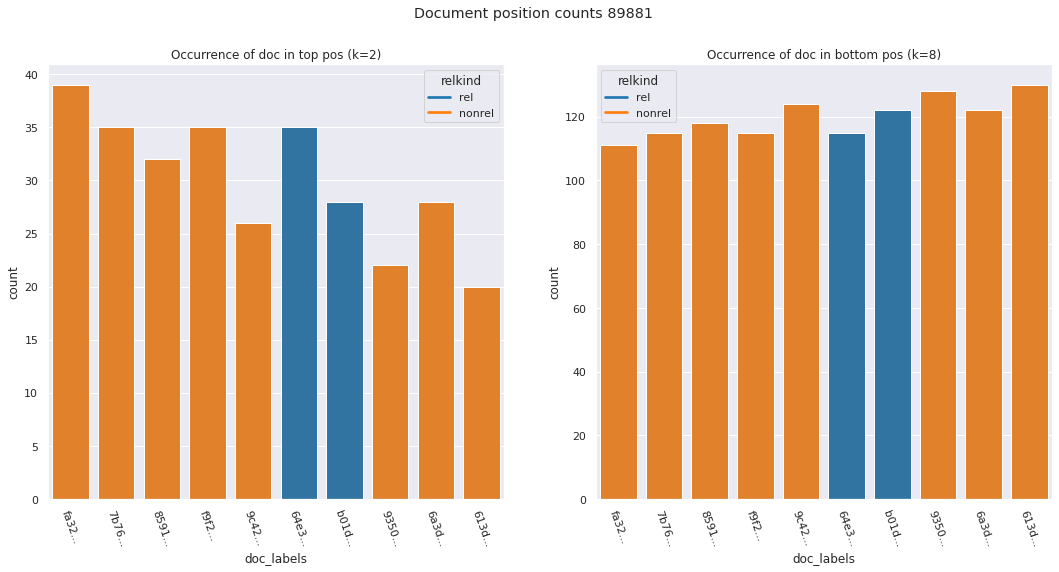

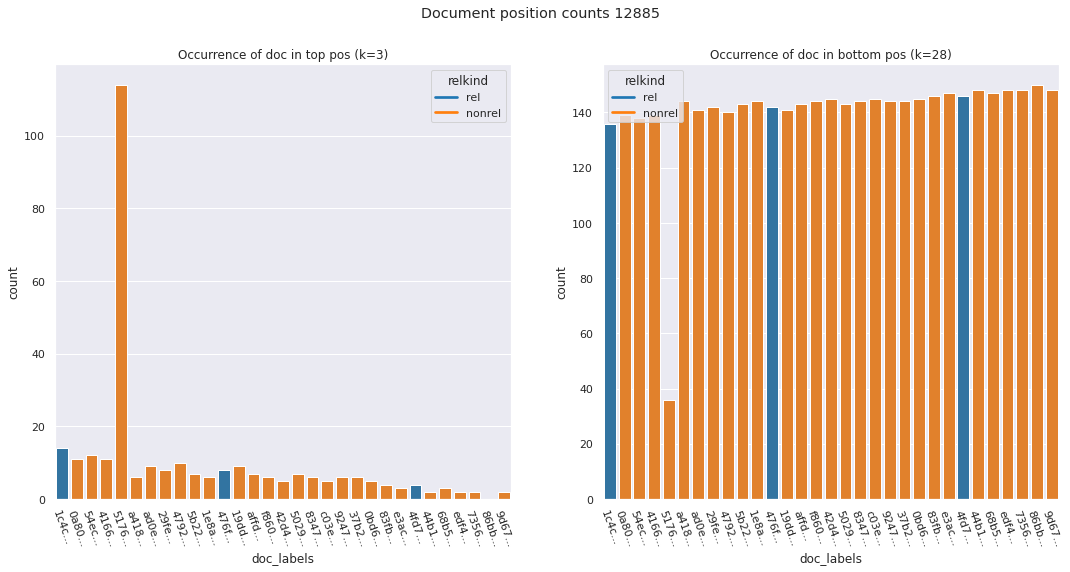

In [143]:
plot_doc_pos_count_for_qid(657,rdf,reldf)
plot_doc_pos_count_for_qid(100510,rdf,reldf)
plot_doc_pos_count_for_qid(16607,rdf,reldf)
plot_doc_pos_count_for_qid(89881,rdf,reldf)
plot_doc_pos_count_for_qid(12885,rdf,reldf)

In [130]:
print(657,': ',count_relgrades_qid(657,reldf))
print(100510,':', count_relgrades_qid(100510,reldf))
print(16607,':',count_relgrades_qid(16607,reldf))
print(89881,':',count_relgrades_qid(89881,reldf))
print(12885,':',count_relgrades_qid(12885,reldf))


657 :  (2, 38)
100510 : (2, 8)
16607 : (2, 8)
89881 : (2, 8)
12885 : (3, 28)


In [144]:
# plots_for_qid(12885,rdf,reldf)

In [145]:
# plots_for_qid(657,rdf,reldf)

In [146]:
# plots_for_qid(91643,rdf,reldf)

In [53]:
reldf[(reldf.qid == 12885) & (reldf.doc_rel == 1)]

qid       query                                    doc_id  doc_rel
141  12885  simulation  476f30d8ed96778b9de0d426d86e4133a9d0c3fc        1
141  12885  simulation  1c4c81d632eba2eae9733de143f83a34b911fa48        1
141  12885  simulation  4fd72cf38d951b2ae92fb1d9b705111335ef84ce        1

In [54]:
reldf[(reldf.qid == 657) & (reldf.doc_rel == 1)]


qid query                                    doc_id  doc_rel
161  657  iran  1a8800cdf999a01022f1db8e5c4c61306d3e43cc        1
161  657  iran  a0c27a04a05676559b89af279dd96dc4232ad4ce        1

In [55]:
reldf[(reldf.qid == 91643) & (reldf.doc_rel == 1)]

qid query                                    doc_id  doc_rel
14  91643  nazi  6fa92e5b2f8d8912026e4e7e6c9a858528499966        1
14  91643  nazi  b2f24606271b959806061c64f81130e5ad75d410        1
14  91643  nazi  fb1a4e990af505ebef7c643c9231645695d9ce31        1
14  91643  nazi  f520d727e7e76253c1d77f26c573474437858593        1
14  91643  nazi  e38a47e6a3e62abf46804dc77b6e1c1deb3eb9e8        1
14  91643  nazi  17dafc3f0318b8711ca4f07783ef428568abb64b        1
14  91643  nazi  5f009ab833e1f9ad39a7d86c70150e80378977f7        1
14  91643  nazi  9cbe474540321289c6c321bc8325f5ac28613c8f        1
14  91643  nazi  f4c12338c303514c5438645404212d95340eeca0        1
14  91643  nazi  d2a334ca26a5849c8aa47057bc19681967eef96b        1
14  91643  nazi  4583fa2cd070ba3305fb856490989a5e2b42dad8        1

In [56]:
reldf[(reldf.qid == 91643) & (reldf.doc_rel == 0)]

qid query                                    doc_id  doc_rel
14  91643  nazi  cdf1901567491b6ad5ecde7042895ec06e99e2b2        0
14  91643  nazi  10b0693b1f5fe596808c88b9cb14ea8ebc87654c        0
14  91643  nazi  4bbb91eb0fea54bd85774931e299efaaaa1b038f        0
14  91643  nazi  8954067bccf3f36cfb46f22c40df207028ecb63a        0
14  91643  nazi  6aca41972c48b8038d3a91c290b3ec032443ec6b        0
14  91643  nazi  9151adf8caa27053bd3bc4adf1390fdfb3205fa2        0
14  91643  nazi  10e5b01d166c37015a92ac938f333a7f0741f596        0
14  91643  nazi  8c3e779d0574a45ee361d66295e34cd0dabbcd37        0
14  91643  nazi  bec4c75f8bf925a5ebcd3976b30cf0790108d5b4        0

- Speculation: queries perform well (poorly) when they have many(few) relevant items?
- Poorly performing queries always have many docs without author

## Hypothesis: queries with many rel vs nonrel items perform well

In [57]:
top10 = edf.sort_values(by='difference',ascending=True).head(10)
top10

key    difference  disparity  relevance
qid                                    
91643    0.019822   1.006921   0.868206
5191     0.044683   1.448939   1.344147
81479    0.046552   2.044160   1.889465
21237    0.053041   1.358547   1.149610
7363     0.053171   1.313280   1.085770
18112    0.057675   1.327767   1.079491
61688    0.061505   1.061153   0.834400
4319     0.063171   1.892463   1.585866
43723    0.065366   1.839158   1.496630
51335    0.071198   1.577270   1.252222

In [58]:
bot10 = edf.sort_values(by='difference',ascending=False).head(10)
bot10

key     difference  disparity  relevance
qid                                     
657       3.700546   2.631709   0.255715
100510    3.252370   2.703133   0.514383
16607     3.034450   2.557715   0.550634
89881     1.987253   1.570899   0.577918
12885     1.941179   1.874742   0.848831
18060     1.725684   1.519402   0.684165
59483     1.619563   1.586472   0.469430
52501     1.429890   1.625181   0.943276
89569     1.210698   1.378091   0.572047
2438      1.193136   1.397599   0.397092

In [59]:
def get_k_results(eval_df,k=10,asc=True):
    sub = eval_df.sort_values(by='difference',ascending=asc).head(k).reset_index()
    return sub

In [60]:
def rel_nonrel_stats_df(eval_df, k=10, asc=True):
#     sub = eval_df.sort_values(by='difference',ascending=asc).head(k).reset_index()
    sub = get_k_results(eval_df,k,asc)
    sub[['r','nr']] = sub.apply(lambda row: count_relgrades_qid(row.qid,reldf), axis='columns', result_type='expand')
    sub[['rfrac','nrfrac']] = sub.apply(lambda row: {'rfrac': row.r / (row.r + row.nr), 'nrfrac': row.nr / (row.r + row.nr) }, axis='columns', result_type='expand')
    return sub

There are 62 items with a difference higher than the total mean, and 138 items with a difference lower than the total mean.

In [61]:
print(edf[edf.difference > edf.difference.mean()].describe())
print()
print(edf[edf.difference <= edf.difference.mean()].describe())

key    difference  disparity  relevance
count   62.000000  62.000000  62.000000
mean     0.960277   1.759598   0.988859
std      0.647813   0.420930   0.328687
min      0.437043   0.998512   0.255715
25%      0.561969   1.469473   0.740174
50%      0.757819   1.671765   1.037014
75%      1.068128   1.899918   1.255380
max      3.700546   2.879598   1.564463

key    difference   disparity   relevance
count  138.000000  138.000000  138.000000
mean     0.190157    1.964270    1.521551
std      0.094710    0.568135    0.452830
min      0.019822    0.985687    0.696810
25%      0.117196    1.623796    1.193393
50%      0.161651    1.865743    1.385916
75%      0.264914    2.230541    1.860925
max      0.409372    3.813899    2.685266


In [62]:
top = rel_nonrel_stats_df(edf, k=138)
bot = rel_nonrel_stats_df(edf, k=62, asc=False)

print(top.rfrac.mean(),'\t',bot.rfrac.mean())
print(top.nrfrac.mean(),'\t',bot.nrfrac.mean())
print()
print(top.head(5),'\n\n', bot.head(5))

0.18171789232594615 	 0.14500607975914462
0.8182821076740538 	 0.8549939202408553

key    qid  difference  disparity  relevance   r  nr     rfrac    nrfrac
0    91643    0.019822   1.006921   0.868206  11   9  0.550000  0.450000
1     5191    0.044683   1.448939   1.344147   6   5  0.545455  0.454545
2    81479    0.046552   2.044160   1.889465   3   7  0.300000  0.700000
3    21237    0.053041   1.358547   1.149610   3  28  0.096774  0.903226
4     7363    0.053171   1.313280   1.085770   2  10  0.166667  0.833333 

 key     qid  difference  disparity  relevance  r  nr     rfrac    nrfrac
0       657    3.700546   2.631709   0.255715  2  38  0.050000  0.950000
1    100510    3.252370   2.703133   0.514383  2   8  0.200000  0.800000
2     16607    3.034450   2.557715   0.550634  2   8  0.200000  0.800000
3     89881    1.987253   1.570899   0.577918  2   8  0.200000  0.800000
4     12885    1.941179   1.874742   0.848831  3  28  0.096774  0.903226


Taking the average across all queries that have a difference lower (higher) than the mean, the items with a lower mean have a higher fraction of relevant items than the items that have a higher mean.

In [63]:
top = rel_nonrel_stats_df(edf,k=20)
bot = rel_nonrel_stats_df(edf,k=20,asc=False)
print(top.rfrac.mean(),'\t',bot.rfrac.mean())
print(top.nrfrac.mean(),'\t',bot.nrfrac.mean())
print()
print(top,'\n\n', bot)


0.3009910461346338 	 0.12824308755760372
0.6990089538653661 	 0.8717569124423964

key    qid  difference  disparity  relevance   r  nr     rfrac    nrfrac
0    91643    0.019822   1.006921   0.868206  11   9  0.550000  0.450000
1     5191    0.044683   1.448939   1.344147   6   5  0.545455  0.454545
2    81479    0.046552   2.044160   1.889465   3   7  0.300000  0.700000
3    21237    0.053041   1.358547   1.149610   3  28  0.096774  0.903226
4     7363    0.053171   1.313280   1.085770   2  10  0.166667  0.833333
5    18112    0.057675   1.327767   1.079491  14  30  0.318182  0.681818
6    61688    0.061505   1.061153   0.834400   4   6  0.400000  0.600000
7     4319    0.063171   1.892463   1.585866   7  13  0.350000  0.650000
8    43723    0.065366   1.839158   1.496630  11  22  0.333333  0.666667
9    51335    0.071198   1.577270   1.252222   3   8  0.272727  0.727273
10    9663    0.074429   1.560314   1.389885  13  24  0.351351  0.648649
11   86754    0.080463   2.579141   2.1467

## Hypothesis: bottom queries have many items without author
- Because they aren't in the index
- Because they are in the index but don't have an author

1. Find all items in the index that do not have an author
2. Find all items that have an estimated relevance but aren't in the index
3. Check how many of the above items occur in the top and the bottom rankings

In [64]:
eval_ids = list(reldf.doc_id.unique())
eval_ids[:10]
len(eval_ids)

4693

In [65]:
est_rel_meta = '../reranking/resources/relevances/Evaluation_rel_scores_model_A.csv'
est_rel_meta = pd.read_csv(est_rel_meta)
est_rel_meta.head()

qid                                    doc_id  est_relevance
0  9087  40d8bea494d4ff4c46f7ad5cb2dcdaa6f96ed5a4       0.131015
1  9087  008a2a2c765485af2e035a2572ba9fc1102eabff       0.208199
2  9087  4a1472c575488ed9acee6c5481f68b95a0c34092       0.129001
3  9087  ff8df0745136fb183ea72b783ff38f8a7ad5ceec       0.179983
4  9087  90605deb1da5e3d5548da12dc130fc0341a6a255       0.157544

In [66]:
est_rel_ids = list(est_rel_meta.doc_id.unique())
est_rel_ids[:10]
len(est_rel_ids)

4684

In [67]:
all_ids = list(set(eval_ids).union(set(est_rel_ids)))
len(all_ids)

4693

As established earlier in the research process, there are 9 items in the evaluation sample that do not have an estimated relevance.

In [68]:
es = Elasticsearch([{'timeout':300}])

In [69]:
res = es.search(index='semanticscholar2020og', body={'size':len(all_ids),'query':{'ids':{'values':all_ids}}})
res

ConnectionError: ConnectionError(<urllib3.connection.HTTPConnection object at 0x7fa1cff06c50>: Failed to establish a new connection: [Errno 111] Connection refused) caused by: NewConnectionError(<urllib3.connection.HTTPConnection object at 0x7fa1cff06c50>: Failed to establish a new connection: [Errno 111] Connection refused)

In [ ]:
# get the returned ids
returned_ids = [hit['_id'] for hit in res['hits']['hits']]
len(returned_ids)


Out of the items in the sample file, 4605 are also in the index.

In [ ]:
not_in_index = list(set(all_ids) - set(returned_ids))
len(not_in_index)

In [ ]:
for hit in res['hits']['hits']:
    print(hit['_source']['author_ids'])

In [ ]:
no_author_in_idx = [hit['_id'] for hit in res['hits']['hits'] if not hit['_source']['author_ids']]
no_author_in_idx[:10]
len(no_author_in_idx)

26 items have no author in the index

In [ ]:
no_author = list(set(not_in_index + no_author_in_idx))
len(no_author)

In [ ]:
top = get_k_results(edf,10,True)
bot = get_k_results(edf,10,False)
print(top)
print()
print(bot)

In [ ]:
topmerge = pd.merge(top[['qid']],reldf[['qid','query','doc_id']],on='qid')
topmerge['has_author'] = topmerge.apply(lambda row: row.doc_id not in no_author,axis='columns')
topmerge.head(10)

In [ ]:
botmerge = pd.merge(bot[['qid']],reldf[['qid','query','doc_id']],on='qid')
botmerge['has_author'] = botmerge.apply(lambda row: row.doc_id not in no_author,axis='columns')
botmerge.head(10)

In [ ]:
topmerge[(topmerge.has_author == False)]

In [ ]:
botmerge[(botmerge.has_author == False)]

In [ ]:
top = get_k_results(edf,138,True)
bot = get_k_results(edf,62,False)
print(top)
print()
print(bot)

In [ ]:
topmerge = pd.merge(top[['qid']],reldf,on='qid')
topmerge['has_author'] = topmerge.apply(lambda row: row.doc_id not in no_author,axis='columns')
topmerge.head(10)

In [ ]:
botmerge = pd.merge(bot[['qid']],reldf,on='qid')
botmerge['has_author'] = botmerge.apply(lambda row: row.doc_id not in no_author,axis='columns')
botmerge.head(10)

In [ ]:
topmerge[(topmerge.has_author == False)].head(96)

only the presence of no-author files does not have to be an issue? or maybe when there are many nauthor docs on the total it levels out because they're all treated the same, so it basically devolves to "random"

In [ ]:
botmerge[(botmerge.has_author == False)]

so, the top document for the worst query doesn't exist in the index. is this one of those documents that exist in the estimated rel files but not the index? --> yes
how are authorless docs treated in this case?
if there is no author, the advantage mean is set to 0. this means that the document is treated as never having an advantage so the hscore is always the same, namely hscore * rho(document)
the rho of 2aa5e431cd45476cc0432722dfa003a641790830 for nle meta is 0.0704727832842697

In [ ]:
topmerge.head(10)

In [ ]:
edf_sorted = edf.sort_values(by='difference').reset_index().reset_index()
edf_sorted.head()
edf_sorted_with_index = pd.merge(edf_sorted,reldf, on='qid')
edf_sorted_with_index.head()

In [ ]:
allres = get_k_results(edf,200,True).reset_index()
allres.head(5)
allmerge = pd.merge(allres,reldf,on='qid')
allmerge['has_author'] = allmerge.apply(lambda row: row.doc_id not in no_author,axis='columns')
allmerge.head()

In [ ]:
all_qs_with_no_auth = allmerge.groupby('qid').filter(lambda df: not df.has_author.all())
all_qs_with_no_auth = all_qs_with_no_auth[['index','qid','difference','query','doc_id','doc_rel', 'has_author']]
len(all_qs_with_no_auth.qid.unique())

There are 58 queries for which one or more documents don't have an author.

In [ ]:
all_qs_with_no_auth.qid.unique()

In [ ]:
all_qs_with_no_auth['index'].unique().mean()

Since the mean is higher than the half of the number of rankings the later ranking are slightly heavier on docs w/out authors.

In [ ]:
rdf.head()

In [ ]:
tips = sns.load_dataset("tips")
tips.head(20)

In [ ]:
data.head(20)

In [ ]:
data[data.qid == 91643]

In [ ]:
reldf[reldf.qid == 95]

In [ ]:
data[data['index'] == 128]

In [ ]:
data = allmerge[['index', 'qid','doc_rel', 'has_author']]
data[:100]
fig, ax =  plt.subplots(1,1,figsize = (30,8.27))

# sns.barplot(x ='qid', hue = 'doc_rel',  data = data[:100], ax=ax)
sns.countplot(x="index", hue="doc_rel", data=data, ax=ax)
sns.countplot(x="index", hue="doc_rel", data=data, ax=ax)
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation = -90)

In [ ]:
data.head()


In [ ]:
fig, ax =  plt.subplots(1,1,figsize = (30,8.27))

pd.crosstab(data['index'],[data['doc_rel'],data['has_author']]).plot(kind="bar",stacked=True,ax=ax)

In [ ]:
pd.crosstab(data['index'],[data['doc_rel'],data['has_author']])

In [ ]:
data.groupby(['qid','doc_rel','has_author']).count().head()

In [ ]:
forsns = data[['qid','doc_rel','has_author']].groupby(['qid','doc_rel']).count()
forsns.head()

In [ ]:
forsns = data[['qid','doc_rel','has_author']].groupby(['qid','doc_rel','has_author']).count().reset_index()
forsns.head()

In [ ]:
fig, ax =  plt.subplots(1,1,figsize = (30,8.27))

# sns.barplot(x ='qid', hue = 'doc_rel',  data = data[:100], ax=ax)
sns.countplot(x="index", hue="doc_rel", data=forsns, ax=ax,palette='Set1')
sns.countplot(x="index", y='has_author', hue="doc_rel", data=forsns, ax=ax,palette='Set2',alpha=0.9)
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation = -90)

In [ ]:
allmerge.set_index('index').plot(kind='bar', stacked=True)

In [ ]:
data.head()

In [ ]:
crossdata = pd.crosstab(data['index'],[data['doc_rel'],data['has_author']])

In [ ]:
crossdata.head().columns

In [ ]:
crossdata[(0,False)].to_list()

In [ ]:
crossdata.head().index.to_list()

In [ ]:
np.arange(len(rel_has_author)*2,step=2)

In [ ]:
import numpy as np

rel_has_author = np.array(crossdata[(1,True)].to_list())
rel_not_has_author = np.array(crossdata[(1,False)].to_list())
nonrel_has_author = np.array(crossdata[(0,True)].to_list())
nonrel_not_has_author = np.array(crossdata[(0,False)].to_list())
qid = crossdata.index.to_list()

with sns.axes_style("white"):
    sns.set(rc={'figure.figsize':(100,17)})
    sns.set_style("ticks")
    sns.set_context("talk")
    
    # plot details
    bar_width = 5
    epsilon = .015
    line_width = 1
    opacity = 0.7
    pos_bar_positions = np.arange(len(rel_has_author)*2*bar_width,step=2*bar_width)
    neg_bar_positions = pos_bar_positions + bar_width

    # make bar plots
    rel_has_author_bar = plt.bar(pos_bar_positions, rel_has_author, bar_width,
                              color='#ED0020',
                              label='rel + author')
    print(rel_has_author)
    rel_not_has_author_bar = plt.bar(pos_bar_positions, rel_not_has_author, bar_width-epsilon,
                              bottom=rel_has_author,
                              alpha=opacity,
                              color='white',
                              edgecolor='#ED0020',
                              linewidth=line_width,
                              hatch='//',
                              label='rel + no author')
    
    nonrel_has_author_bar = plt.bar(neg_bar_positions, nonrel_has_author, bar_width,
                              color='#0000DD',
                              label='not rel + author')
    nonrel_not_has_author_bar = plt.bar(neg_bar_positions, nonrel_not_has_author, bar_width-epsilon,
                              bottom=nonrel_has_author,
                              color="white",
                              hatch='//',
                              edgecolor='#0000DD',
                              ecolor="#0000DD",
                              linewidth=line_width,
                              label='not rel + no author')
    
    plt.xticks(neg_bar_positions, qid, rotation=90)
    plt.ylabel('Percentage of Samples')
    plt.legend(loc='best')
    sns.despine()

In [ ]:
crossdata.index.to_list()[-10:]

In [ ]:
crossdata.index.to_list()[-10:]

In [ ]:
crossdata.index.to_list()[len(crossdata.index.to_list())-10:len(crossdata.index.to_list())]

In [ ]:
crossdata.index.to_list()[:10]

In [ ]:
plot_has_authors(crossdata)

In [ ]:
plot_has_authors(crossdata,asc=False)

In [ ]:
import numpy as np

def plot_has_authors(crossdata,k=10,asc=True):
    if asc:
        slstart = 0
        slend = k
    else:
        slstart = len(crossdata.index.to_list())-k
        slend = len(crossdata.index.to_list())
    
    
    rel_has_author = np.array(crossdata[(1,True)].to_list()[slstart:slend])
    rel_not_has_author = np.array(crossdata[(1,False)].to_list()[slstart:slend])
    nonrel_has_author = np.array(crossdata[(0,True)].to_list()[slstart:slend])
    nonrel_not_has_author = np.array(crossdata[(0,False)].to_list()[slstart:slend])
    qid = crossdata.index.to_list()[slstart:slend]

    with sns.axes_style("white"):
        sns.set(rc={'figure.figsize':(100,17)})
        sns.set_style("ticks")
        sns.set_context("talk")

        # plot details
        bar_width = 4
        epsilon = .015
        line_width = 1
        opacity = 0.7
        pos_bar_positions = np.arange(len(rel_has_author)*2*bar_width,step=2*bar_width)
        neg_bar_positions = pos_bar_positions + bar_width

        # make bar plots
        rel_has_author_bar = plt.bar(pos_bar_positions, rel_has_author, bar_width,
                                  color='#ED0020',
                                  label='rel + author')
        print(rel_has_author)
        rel_not_has_author_bar = plt.bar(pos_bar_positions, rel_not_has_author, bar_width-epsilon,
                                  bottom=rel_has_author,
                                  alpha=opacity,
                                  color='white',
                                  edgecolor='#ED0020',
                                  linewidth=line_width,
                                  hatch='//',
                                  label='rel + no author')

        nonrel_has_author_bar = plt.bar(neg_bar_positions, nonrel_has_author, bar_width,
                                  color='#0000DD',
                                  label='not rel + author')
        nonrel_not_has_author_bar = plt.bar(neg_bar_positions, nonrel_not_has_author, bar_width-epsilon,
                                  bottom=nonrel_has_author,
                                  color="white",
                                  hatch='//',
                                  edgecolor='#0000DD',
                                  ecolor="#0000DD",
                                  linewidth=line_width,
                                  label='not rel + no author')

        plt.xticks(neg_bar_positions, qid, rotation=90)
        plt.ylabel('Num docs')
        plt.legend(loc='best')
        sns.despine()

In [ ]:
dat = crossdata.unstack().reset_index().rename({0:'count'},axis=1)
# dat[dat['index'] <= 10]

In [ ]:
dat = crossdata.unstack().reset_index().rename({0:'count'},axis=1)
# fig, ax = plt.subplots(1,1,figsize = (17.7,8.27))

g = sns.catplot(x="index", y="count",
                hue="has_author", col="doc_rel",
                data=dat[dat['index'] <= 20], kind="bar",
                height=4, aspect=1)
g.fig.set_size_inches(22,8.27)


In [ ]:
g = sns.catplot(x="index", y="count",
                hue="has_author", col="doc_rel",
                data=dat[dat['index'] >= len(dat['index'].unique()) - 20], kind="bar",
                height=4, aspect=1)
g.fig.set_size_inches(22,8.27)

Hypothesis was: bottom queries have many items without author


- Bottom queries mainly have nonrel items without author
- Top queries have both rel and nonrel items without author

Still to check: 
- for top/bottom queries, are the top non-author documents mainly relevant?
    - for each query for each rank, how often does a no-author document appear there and is it relevant or not?
    
    
- for top/bottom queries, compare the estimated relevance to the actual relevance
    --> estimated relevance is used to compute the h_score
    --> if the estimated relevance is low compared to the actual relevance the h-score will be lower than it should be

- for top/bottom queries, compare the estimated relevance to the actual relevance
    --> estimated relevance is used to compute the h_score
    --> if the estimated relevance is low compared to the actual relevance the h-score will be lower than it should be

In [ ]:
est_rel_meta.describe()

In [ ]:
reldf.describe()

In [ ]:
pd.merge(est_rel_meta,reldf,on=['qid','doc_id'],how='outer').describe()

In [ ]:
est_and_rel = pd.merge(est_rel_meta,reldf,on=['qid','doc_id'],how='outer').fillna(0)
est_and_rel.head()

In [ ]:
 sns.stripplot(x="doc_rel", y="est_relevance", data=est_and_rel)

interestingly, none of the estimated values are very high? why is that? and there are three points that have rel 1 but are estimated very low, interesting to see if those cause some low results in the rankings

## Bibliography

[1] Buckley, ‘Reliable Information Access Final Workshop Report’.